# COVID-19 Data Analyses using Johns Hopkins Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is the Johns Hopkins University's Center for Systems Science and Engineering (CSSE) 
[COVID-19 data repository](https://github.com/CSSEGISandData/COVID-19).

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the Johns Hopkins COVID-19 CSV files into a [Pandas](https://pandas.pydata.org/) DataFrame. It
then manipulates, queries, and plots the DataFrame.

[**I don't want to look at code. Take me to the first graph!**](#United-States)

[bmc/covid19]: https://github.com/bmc/covid19/

## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import csv
import os
import sys
import re
import math
from pprint import pprint
from enum import Enum
from itertools import chain
from lib.common import *
from lib.plot import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")

Using Python 3.8.4
Using matplotlib 3.2.2
Using Pandas 1.0.5


In [2]:
JOHNS_HOPKINS_US_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us'
# The detailed path contains other countries and has data down to the US county level.
JOHNS_HOPKINS_DETAILED_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports'
SOURCE = "Johns Hopkins University Center for Systems Science and Engineering (CSSE)"

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## Helpers

In [4]:
def read_raw_data(dir: str) -> pd.DataFrame:
    """
    Read the raw data, consisting of a number of CSV files
    with timestamped names, into a single Pandas DataFrame.
    Does not translate the columns or clean anything up.
    """
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    data_frames = []
    for f in os.listdir(dir):
        # Skip any file that doesn't match the regex. It'd
        # probably be sufficient to check the extension, but
        # this approach is more robust.
        m = f_pat.match(f)
        if m is None:
            continue
        df = pd.read_csv(os.path.join(dir, f))
        file_date = datetime.strptime(m.group(1), '%m-%d-%Y')
        if file_date < STARTING_DATE:
            continue

        df['Date'] = file_date
        # Now, convert to Pandas datetime. You can't store a regular
        # Python date or datetime in Pandas and then operate on it
        # using Pandas datetime functions. It has to be a Pandas
        # datetime.
        df['Date'] = pd.to_datetime(df['Date'])
        data_frames.append(df)

    return pd.concat(data_frames, ignore_index=True)

def read_top_level_us_data() -> pd.DataFrame:
    """
    Read all CSV files into a single Pandas DataFrame, normalizing
    the column names and discarding the ones we don't want.
    
    The DataFrame will be sorted by date.
    """
    df = read_raw_data(JOHNS_HOPKINS_US_DIR_PATH)[[
        'Date', 'Province_State', 'Confirmed', 'Deaths', 'Recovered',
        'People_Tested', 'People_Hospitalized'
    ]]

    final_df = df.rename(columns={
        'Province_State':      COL_REGION,
        'Date':                COL_DATE,
        'Deaths':              COL_DEATHS,
        'People_Tested':       COL_TESTS,
        'Confirmed':           COL_CASES,
        'Recovered':           COL_RECOVERIES,
        'People_Hospitalized': COL_HOSPITALIZATIONS
    })

    for col in (COL_DEATHS, COL_CASES, COL_TESTS, COL_RECOVERIES, COL_HOSPITALIZATIONS):
        final_df[col] = final_df[col].fillna(0)

    final_df = final_df.astype({
        COL_DEATHS: int,
        COL_CASES: int,
        COL_HOSPITALIZATIONS: int,
        COL_RECOVERIES: int,
        COL_TESTS: int
    })

    make_month_day_column(final_df)

    final_df.sort_values(by=[COL_DATE], inplace=True)
    return final_df

In [5]:
def read_us_county_data() -> pd.DataFrame:
    """
    Reads the Johns Hopkins COVID-19 data that contains
    more detailed data, down to the county. Then, weed
    out non-US data and normalize the rest somewhat.
    """
    df = read_raw_data(JOHNS_HOPKINS_DETAILED_DIR_PATH)
    df2 = df.loc[df['Country_Region'] == 'US'][[
        'Date', 'Admin2', 'Province_State', 'Confirmed',
        'Deaths', 'Recovered'
    ]]

    final_df = df2.rename(columns={
        'Date':           COL_DATE,
        'Admin2':         COL_COUNTY,
        'Province_State': COL_REGION,
        'Confirmed':      COL_CASES,
        'Deaths':         COL_DEATHS,
        'Recovered':      COL_RECOVERIES,
    })

    for col in (COL_DEATHS, COL_CASES, COL_RECOVERIES):
        final_df[col] = final_df[col].fillna(0)

    make_month_day_column(final_df)
    final_df.sort_values(by=[COL_DATE], inplace=True)
    return final_df

## Read the data

### Load the state population data

In [6]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,340


### Load the Johns Hopkins data

In [7]:
%ls $JOHNS_HOPKINS_US_DIR_PATH

04-12-2020.csv  05-07-2020.csv  06-01-2020.csv  06-26-2020.csv  07-21-2020.csv
04-13-2020.csv  05-08-2020.csv  06-02-2020.csv  06-27-2020.csv  07-22-2020.csv
04-14-2020.csv  05-09-2020.csv  06-03-2020.csv  06-28-2020.csv  07-23-2020.csv
04-15-2020.csv  05-10-2020.csv  06-04-2020.csv  06-29-2020.csv  07-24-2020.csv
04-16-2020.csv  05-11-2020.csv  06-05-2020.csv  06-30-2020.csv  07-25-2020.csv
04-17-2020.csv  05-12-2020.csv  06-06-2020.csv  07-01-2020.csv  07-26-2020.csv
04-18-2020.csv  05-13-2020.csv  06-07-2020.csv  07-02-2020.csv  07-27-2020.csv
04-19-2020.csv  05-14-2020.csv  06-08-2020.csv  07-03-2020.csv  07-28-2020.csv
04-20-2020.csv  05-15-2020.csv  06-09-2020.csv  07-04-2020.csv  07-29-2020.csv
04-21-2020.csv  05-16-2020.csv  06-10-2020.csv  07-05-2020.csv  07-30-2020.csv
04-22-2020.csv  05-17-2020.csv  06-11-2020.csv  07-06-2020.csv  07-31-2020.csv
04-23-2020.csv  05-18-2020.csv  06-12-2020.csv  07-07-2020.csv  08-01-2020.csv
04-24-2020.csv  05-19-2020.csv  06-13-2020.csv  07-0

In [8]:
%head $JOHNS_HOPKINS_US_DIR_PATH/04-12-2020.csv

Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3563,93,,3470,1,75.98802021,21583,437,2.610159978,84000001,USA,460.3001516,12.26494527
Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66,264,2,45.50404936,8038,31,2.941176471,84000002,USA,1344.711576,11.39705882
Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,,3427,4,48.66242224,42109,,3.246753247,84000004,USA,578.5222863,
Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367,1253,5,49.43942261,19722,130,2.109375,84000005,USA,761.7533537,10.15625
California,US,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,,22155,6,58.13772584,190328,5234,2.81202018,84000006,USA,485.4238685,22.9611757
Colorado,US,2020-04-12 23:18:15,39.0598,-105.3111,7307,289,,7018,8,128.943729,34873,1376,3.955111537,84000008,USA,615.3899908,18.8312577
C

In [9]:
df = read_top_level_us_data()

In [10]:
df

date          region   cases  deaths  recoveries    tests  \
2553 2020-04-12      Washington   10609     506           0    93615   
2533 2020-04-12          Nevada    2836     112           0    24611   
2534 2020-04-12   New Hampshire     929      23         236    10925   
2535 2020-04-12      New Jersey   61850    2350           0   126735   
2536 2020-04-12      New Mexico    1245      26         235    28692   
...         ...             ...     ...     ...         ...      ...   
5445 2020-08-11      New Mexico   22643     693        9428   632997   
5444 2020-08-11      New Jersey  185475   15890       33223  2350310   
5443 2020-08-11   New Hampshire    6861     419        6126   175399   
5412 2020-08-11  American Samoa       0       0           0     1396   
5440 2020-08-11         Montana    5104      77        3542   194412   

      hospitalizations month_day  
2553               642     04/12  
2533               282     04/12  
2534               146     04/12  
2535              7604     04/12  
2536                78     04/12  
...                ...       ...  
5445              2870     08/11  
5444             22052     08/11  
5443               705     08/11  
5412                 0     08/11  
5440               276     08/11  

[7094 rows x 8 columns]

In [11]:
jhu_starting_date = df.date.min().date()
jhu_ending_date = df.date.max().date()
# See https://stackoverflow.com/a/15411596
total_unique_dates = len(df.groupby('date').date.nunique())
print(f"Loaded data for {total_unique_dates} days.")
# len(dataframe.index) is the idiom for getting the number of rows.
print(f"Total rows: {len(df.index):,}")
print(f"Starting date: {datestr(jhu_starting_date, include_year=True)}")
print(f"Ending date: {datestr(jhu_ending_date, include_year=True)}")

Loaded data for 122 days.
Total rows: 7,094
Starting date: 04/12/2020
Ending date: 08/11/2020


In [12]:
df_counties = read_us_county_data()

In [13]:
df_counties

date        county      region  cases  deaths  recoveries  \
155688 2020-04-12        Hardin        Iowa      1       0           0   
156492 2020-04-12        Orange  California   1277      19           0   
156493 2020-04-12        Orange     Florida    949      13           0   
156494 2020-04-12        Orange     Indiana     17       3           0   
156495 2020-04-12        Orange    New York   5027     145           0   
...           ...           ...         ...    ...     ...         ...   
332142 2020-08-11        Tooele        Utah    584       0           0   
332141 2020-08-11  Central Utah        Utah    430       2           0   
332140 2020-08-11        Oscoda    Michigan     24       1           0   
332158 2020-08-11          Pope    Illinois     11       0           0   
335518 2020-08-11         Comal       Texas   1929      70           0   

       month_day  
155688     04/12  
156492     04/12  
156493     04/12  
156494     04/12  
156495     04/12  
...          ...  
332142     08/11  
332141     08/11  
332140     08/11  
332158     08/11  
335518     08/11  

[372912 rows x 7 columns]

In [14]:
print(f"COUNTY DATA:")
print(f"Read data for {len(df_counties[COL_DATE].unique())} days.")
print(f"Starting date: {datestr(df_counties[COL_DATE].min(), include_year=True)}")
print(f"Ending date: {datestr(df_counties[COL_DATE].max(), include_year=True)}")

COUNTY DATA:
Read data for 122 days.
Starting date: 04/12/2020
Ending date: 08/11/2020


## Deaths and cases in a single region

### United States

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b189add30>)

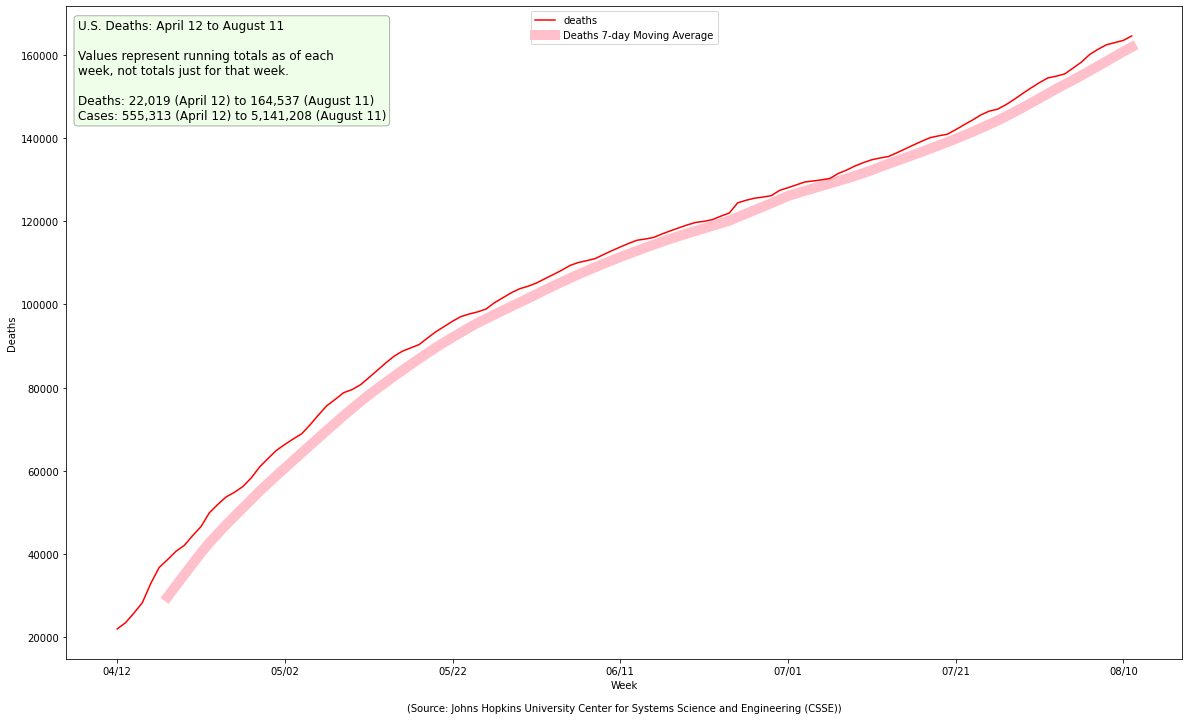

In [15]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS}, moving_average=True,
                   image_file='jhu-us-deaths.png', textbox_heading="U.S. Deaths")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed360d90>)

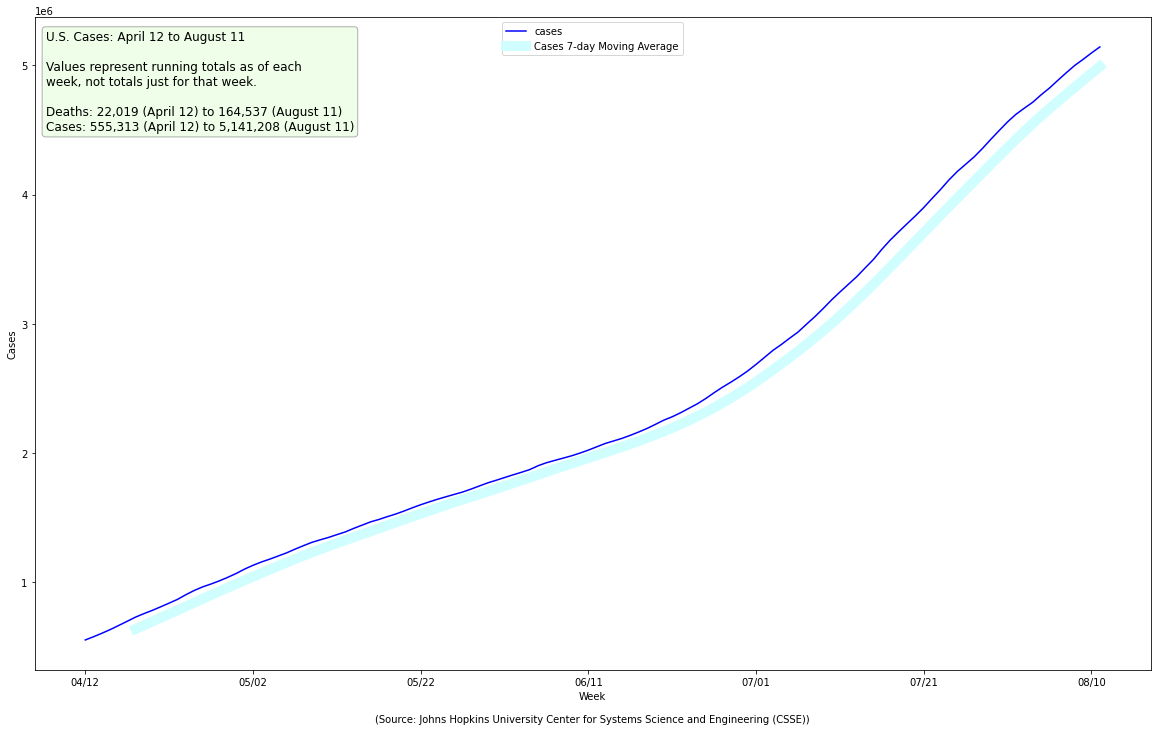

In [16]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.CASES}, moving_average=True,
                   image_file='jhu-us-cases.png', textbox_heading="U.S. Cases")

#### Positivity Rate

The positivity rate is problematic. At the beginning of the pandemic,
we weren't testing much at all, and the tests were reserved largely
for those showing symptoms. So the positivity rate was, not surprisingly,
quite high. It will have declined over time, because we're testing more
of the population, including more people who come up negative.

Rather than plot the positivity rate since April, which is somewhat
misleading, just plot the positivity rate for the last 45 days.

**Note**: A drop-off toward the end isn't necessarily cause for celebration.
Reporting of cases probably lags.

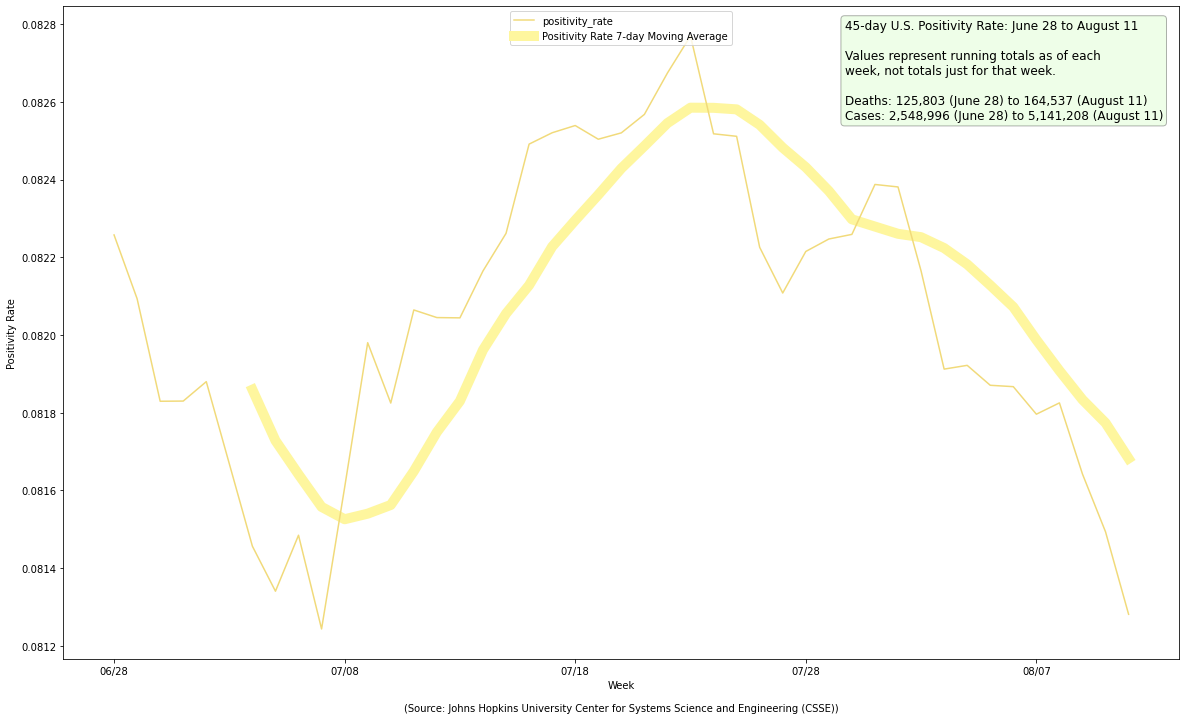

In [17]:
delta = timedelta(days=45)
cutoff = date_to_datetime(today - delta)
df_positivity_dates = df.loc[df.date >= cutoff]
fig, ax = plot_stats_by_date(df_positivity_dates, SOURCE, metrics={MetricType.POSITIVITY},
                             image_file='jhu-us-positivity-rate.png', 
                             textbox_heading="45-day U.S. Positivity Rate",
                             textbox_loc=(0.7, 0.98),
                             moving_average=True)

#### Daily values, instead of cumulative values

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee895550>)

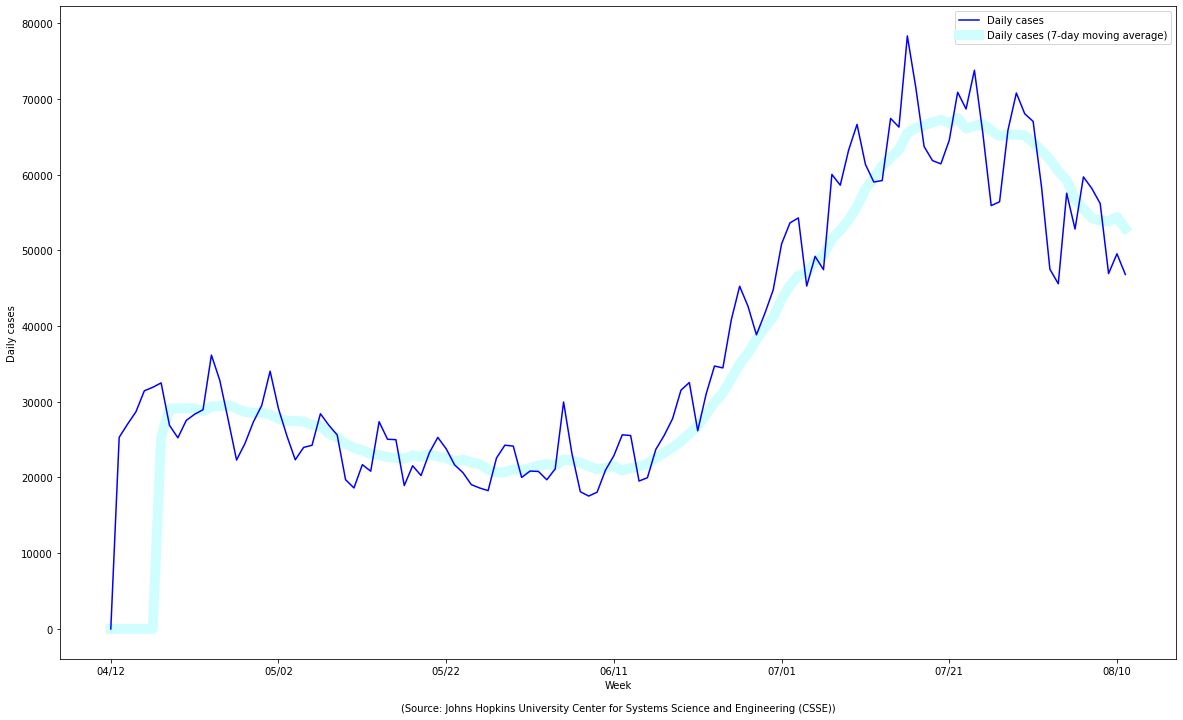

In [18]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='United States',
                 moving_average=True,
                 image_file="jhu-us-cases-daily.png")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed9685b0>)

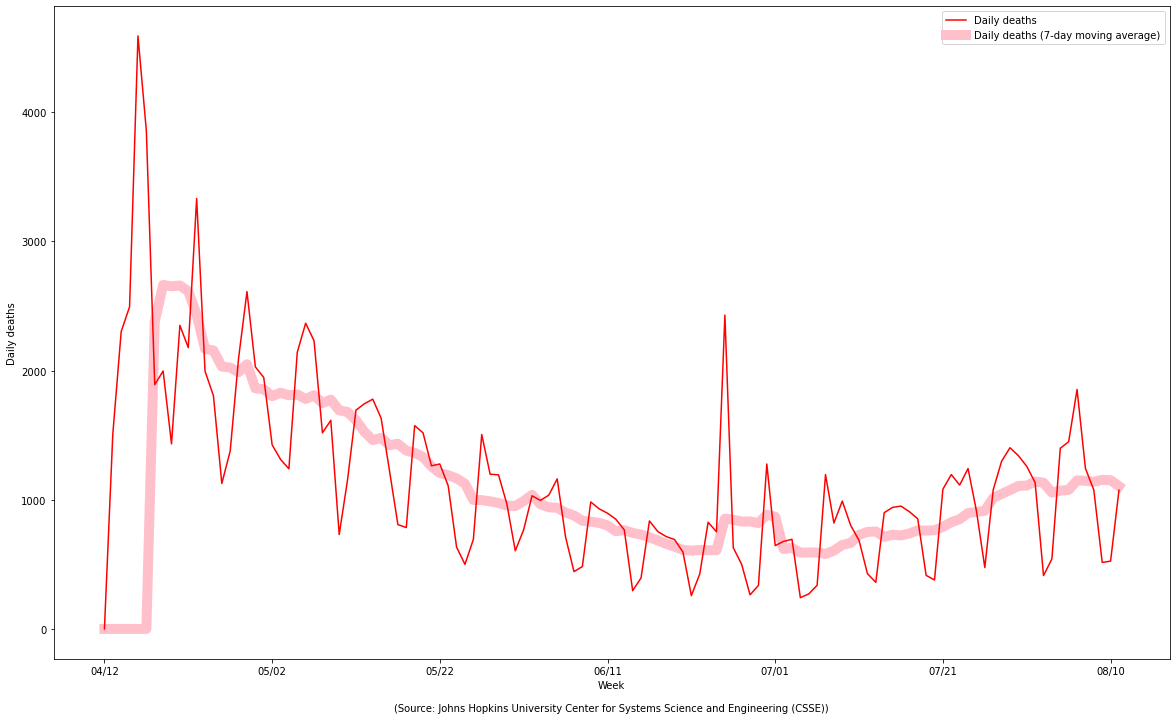

In [19]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='United States',
                 moving_average=True,
                 image_file="jhu-us-deaths-daily.png")

#### Just the past week

In [20]:
week_delta = timedelta(days=6)
six_days_prior = jhu_ending_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(jhu_ending_date, hour=23, minute=59, second=59)

df_past_week = df.loc[(df[COL_DATE] >= last_week_start) & (df[COL_DATE] <= last_week_end)]

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee350490>)

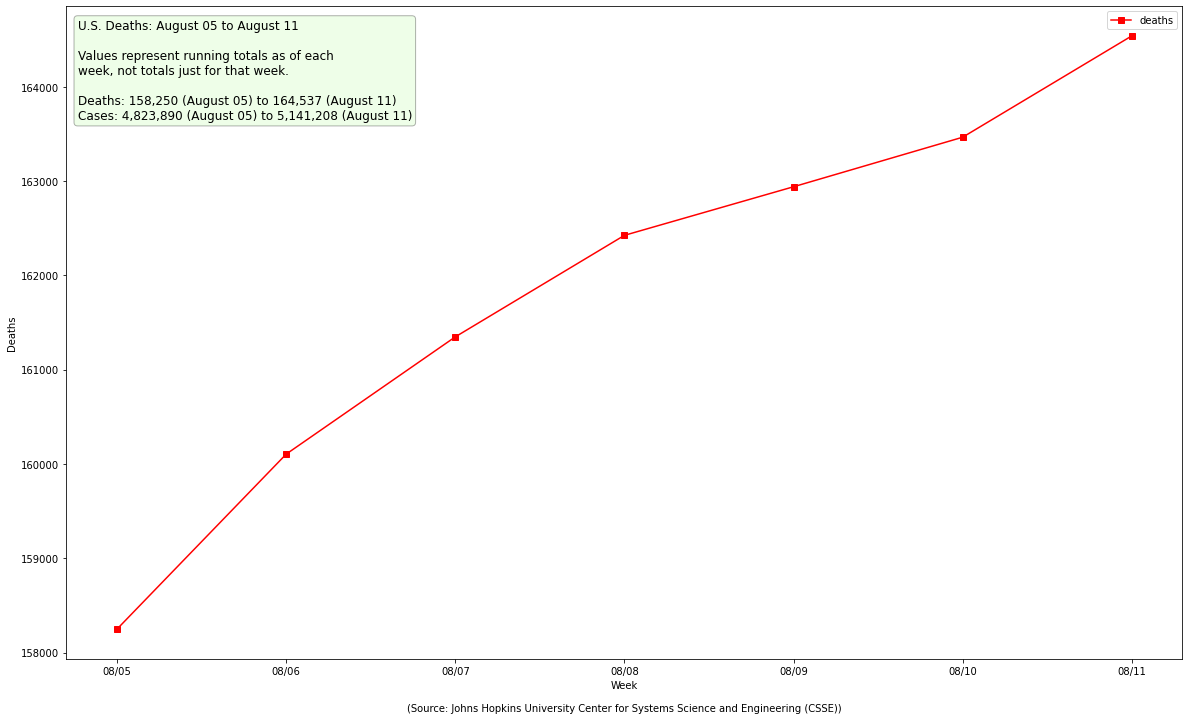

In [21]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='jhu-us-deaths-past-week.png')

#### Deaths vs. Cases

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee0de850>)

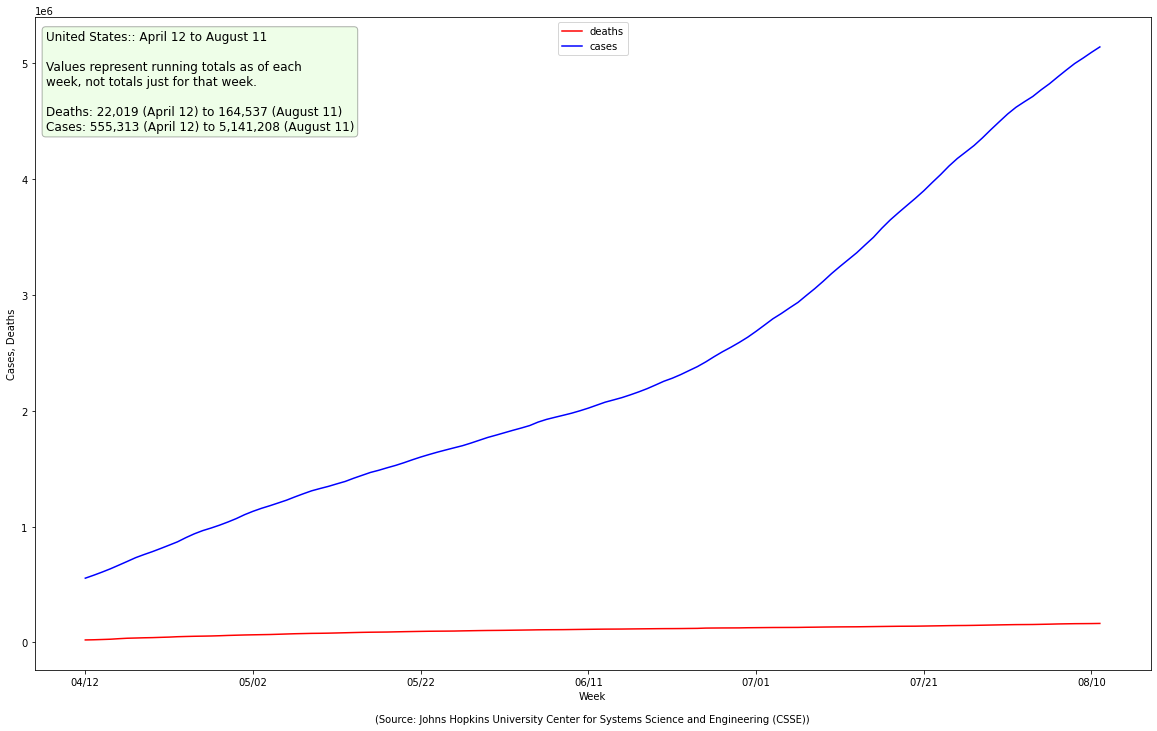

In [22]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS, MetricType.CASES}, 
                   textbox_heading="United States:", image_file="jhu-us-deaths-and-cases.png")

### Individual States

#### Pennsylvania

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aef2812b0>)

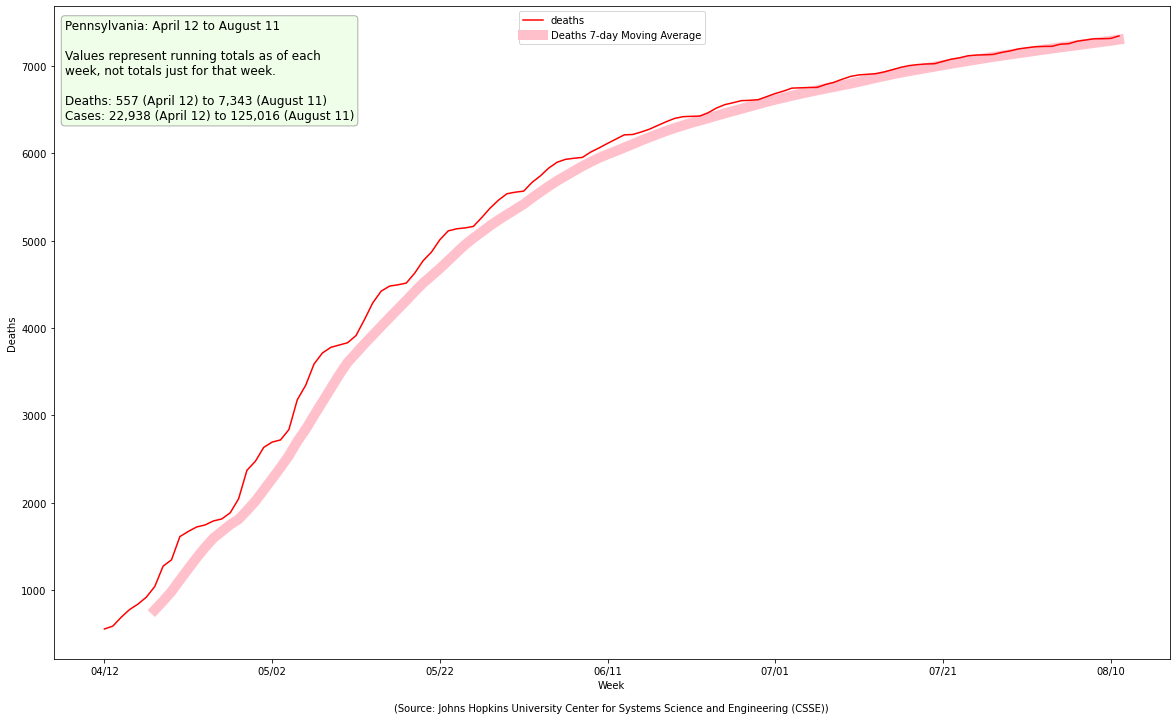

In [23]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aef28df40>)

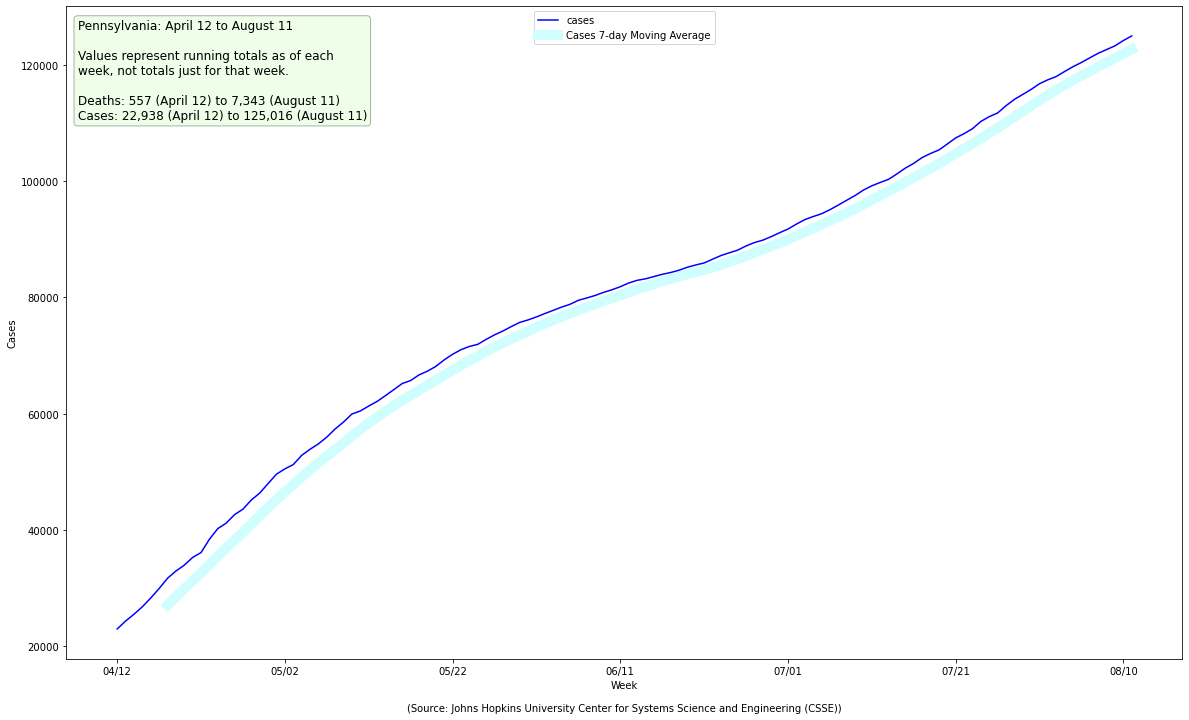

In [24]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed1046d0>)

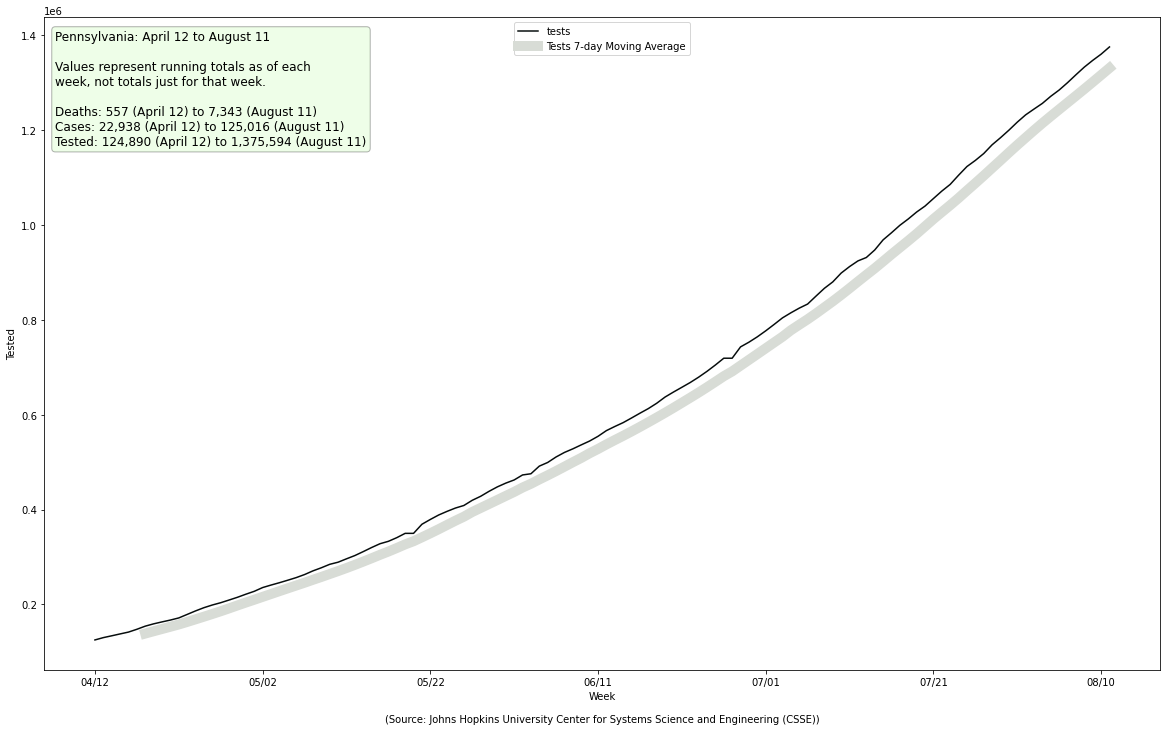

In [25]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee2cd070>)

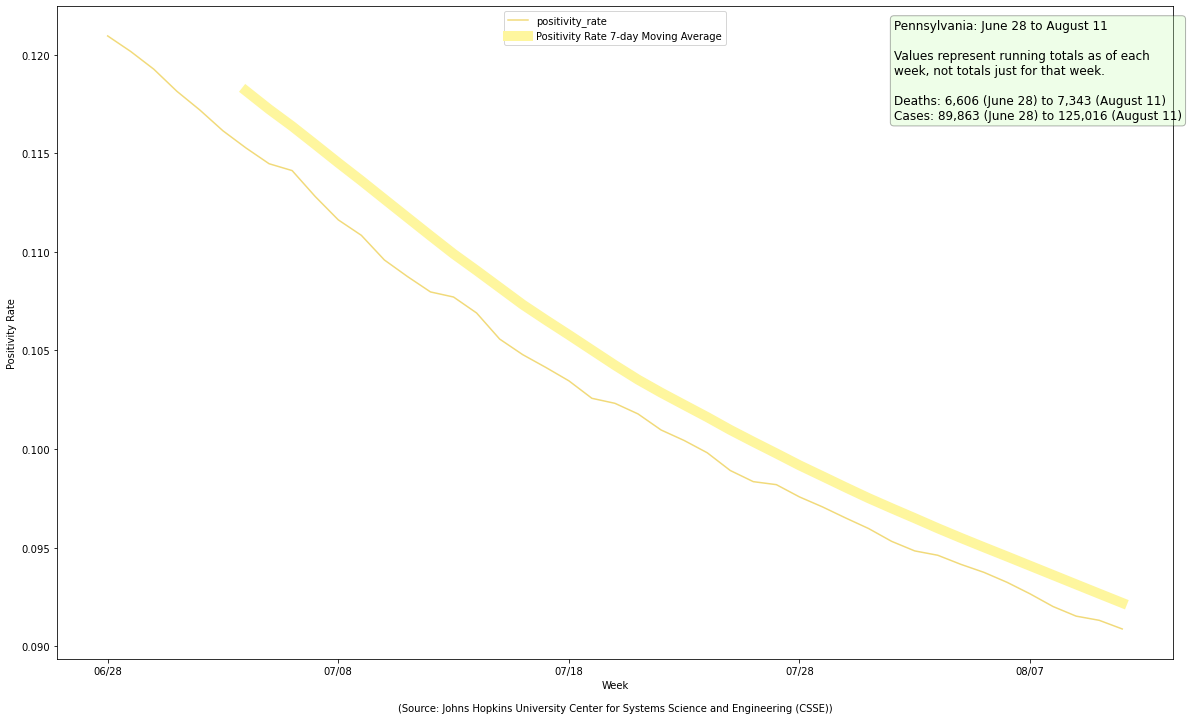

In [26]:
# Note caveats on positivity rate in the U.S. section, above.
plot_state(df_positivity_dates, SOURCE, 'Pennsylvania', metrics={MetricType.POSITIVITY},
           image_file='jhu-pa-positivity.png', moving_average=True, textbox_loc=(0.75, 0.98))

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee5a83d0>)

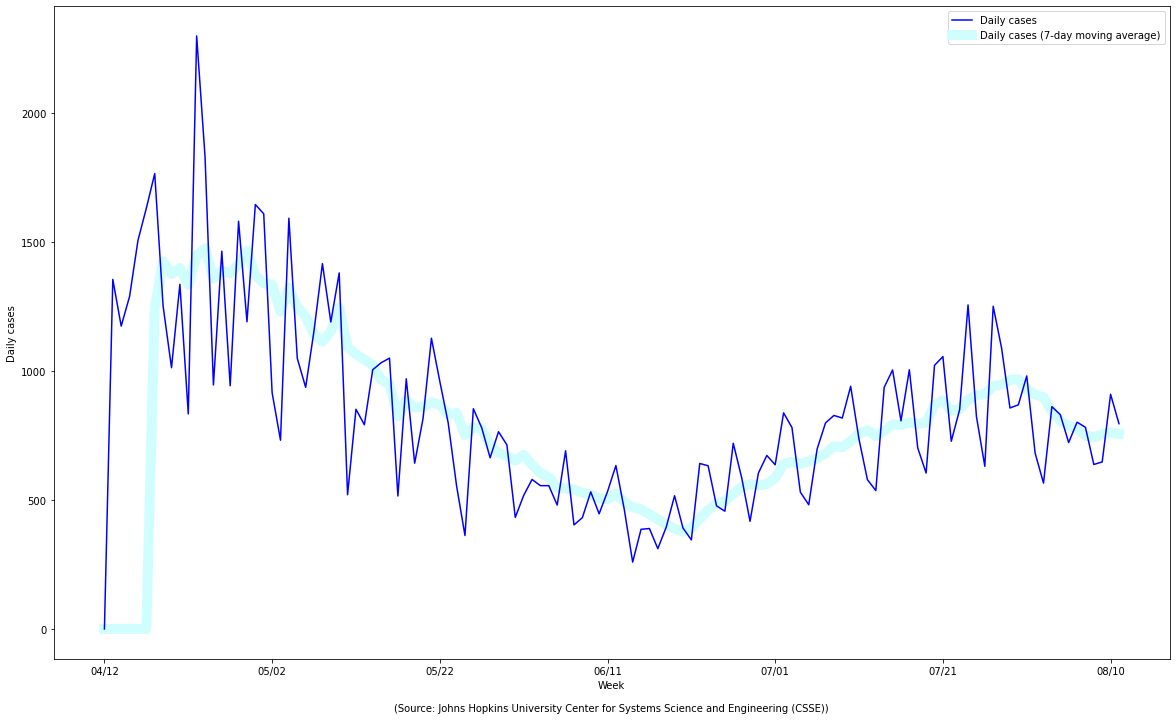

In [27]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-cases-daily.png")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aecd8f280>)

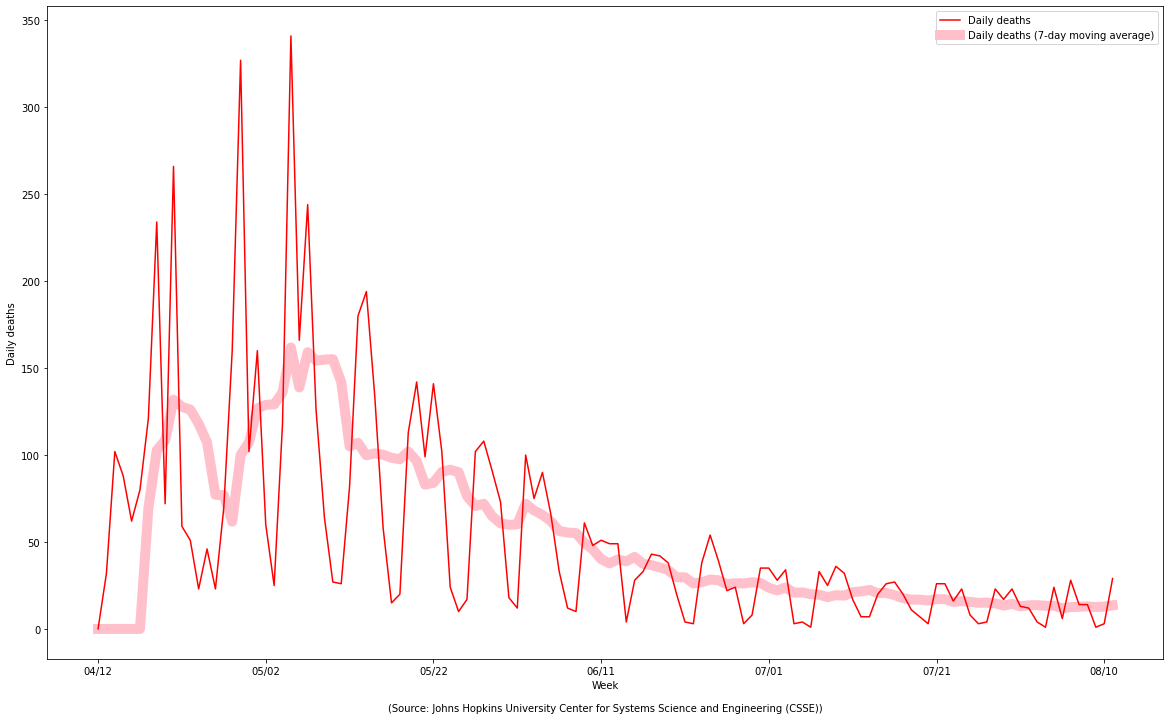

In [28]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-deaths-daily.png")

#### New York

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aede0cbe0>)

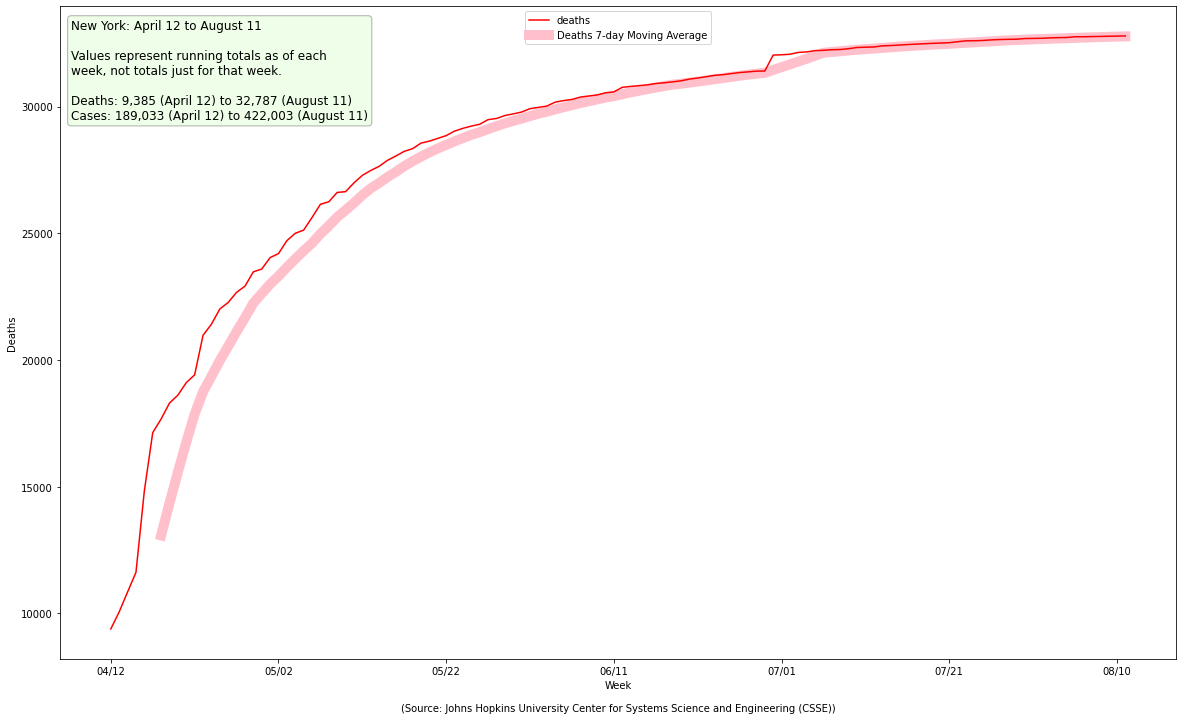

In [29]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee9e77f0>)

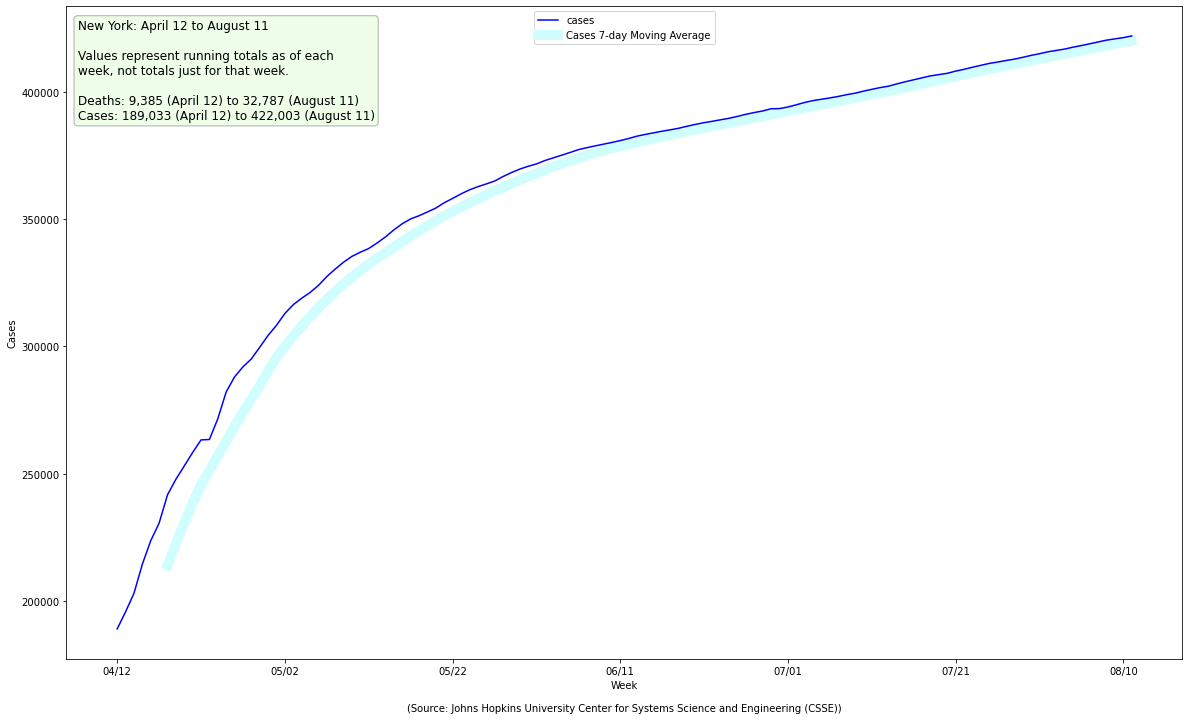

In [30]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee081e80>)

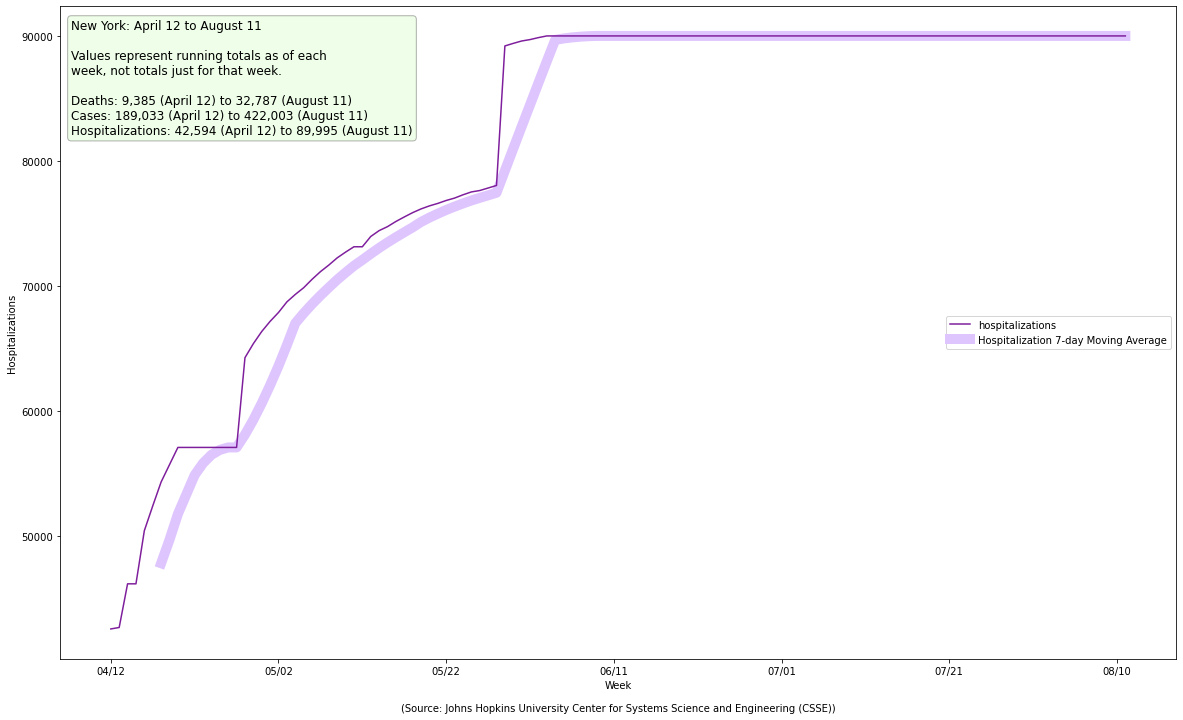

In [31]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, 
           moving_average=True, legend_loc='center right')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee5d2fa0>)

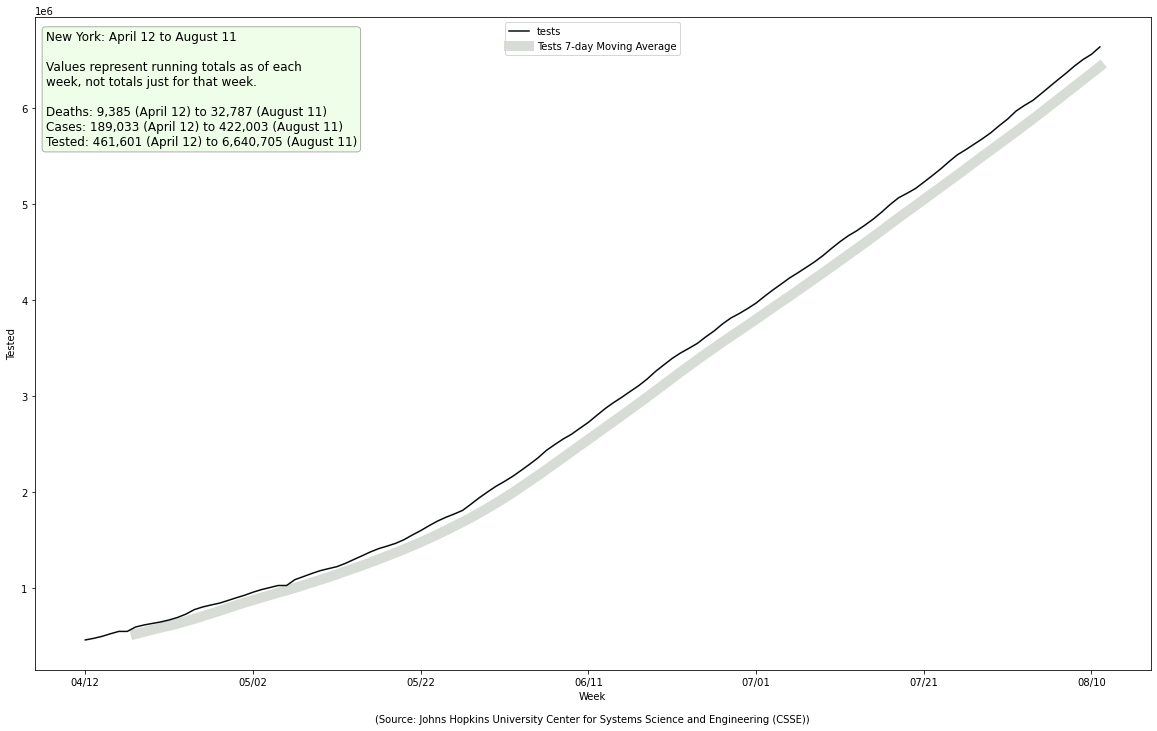

In [32]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aece941c0>)

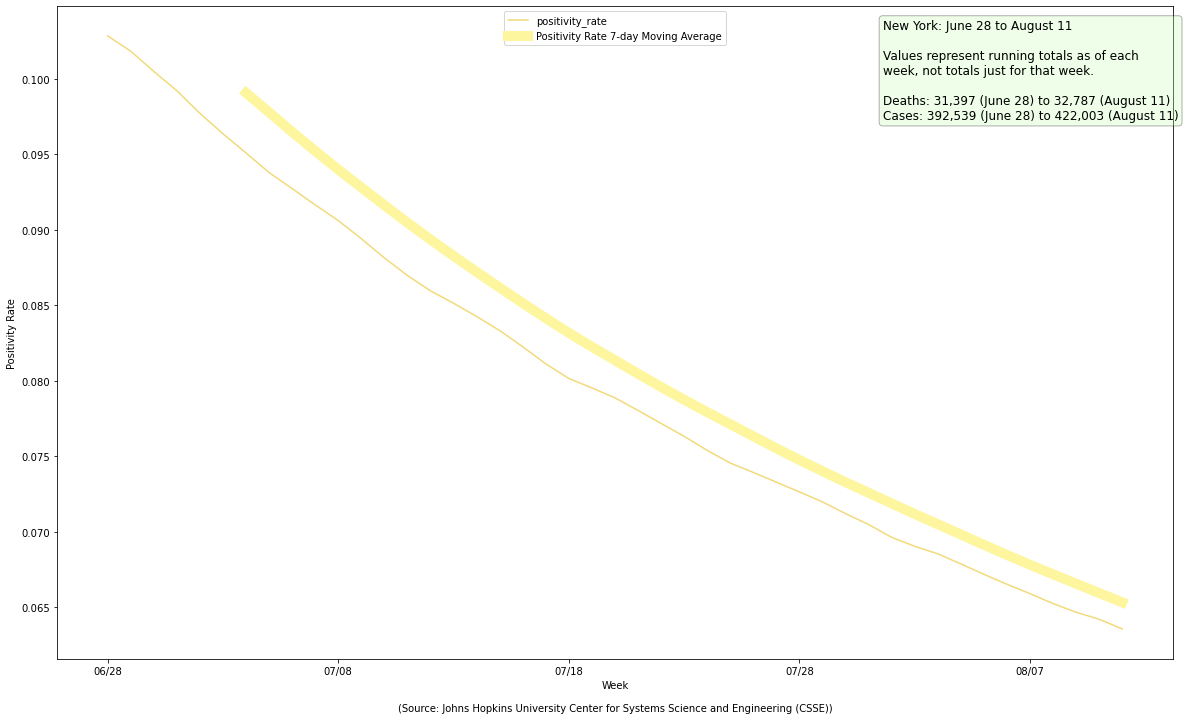

In [33]:
plot_state(df_positivity_dates, SOURCE, 'New York', image_file='jhu-ny-pos.png', 
           metrics={MetricType.POSITIVITY}, textbox_loc=(0.74, 0.98), moving_average=True)

#### California

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee3ee670>)

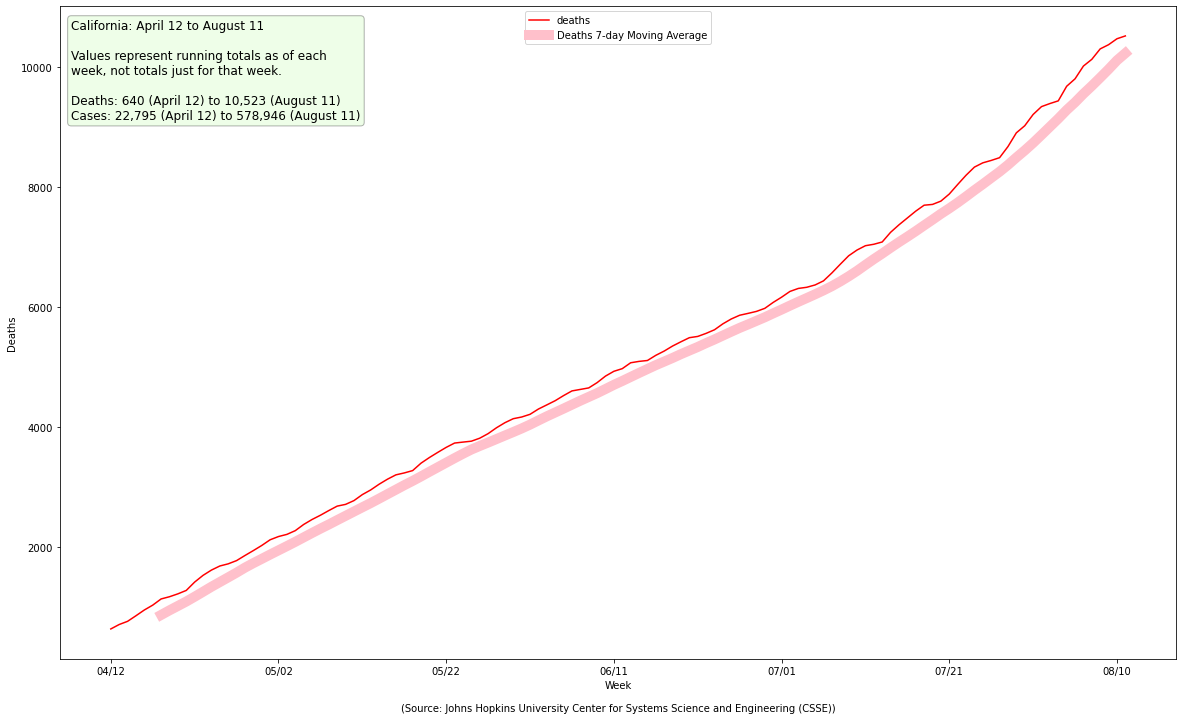

In [34]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aecc226a0>)

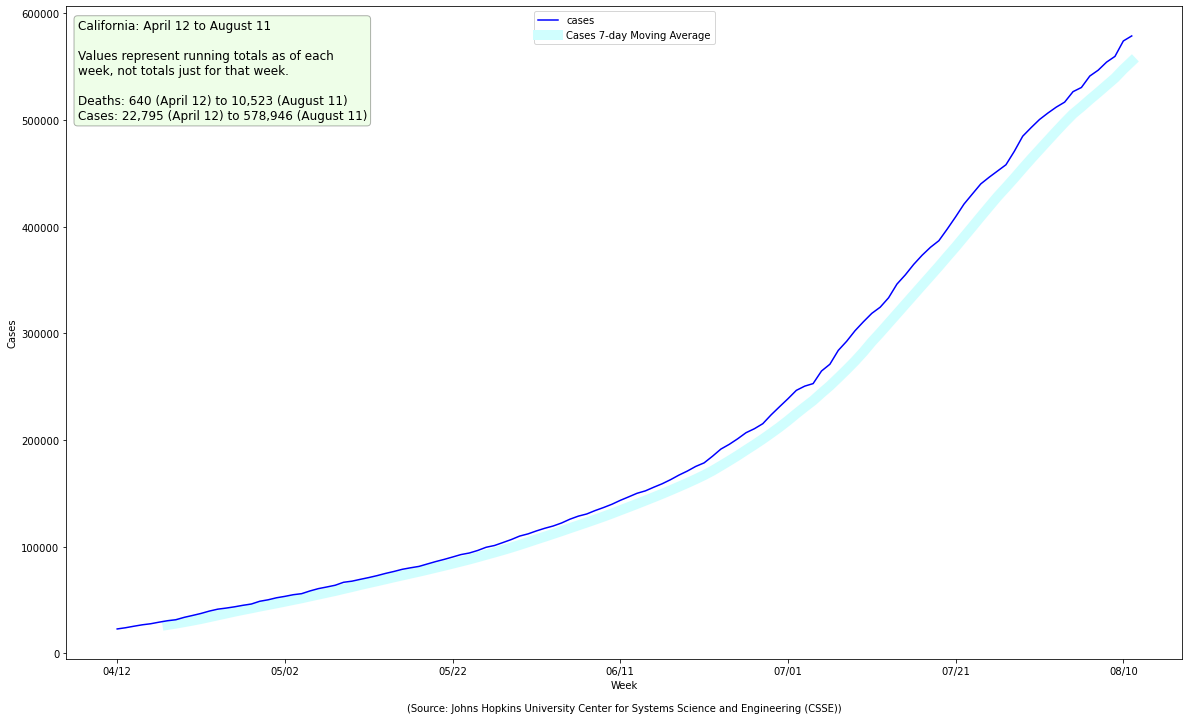

In [35]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aef0d36a0>)

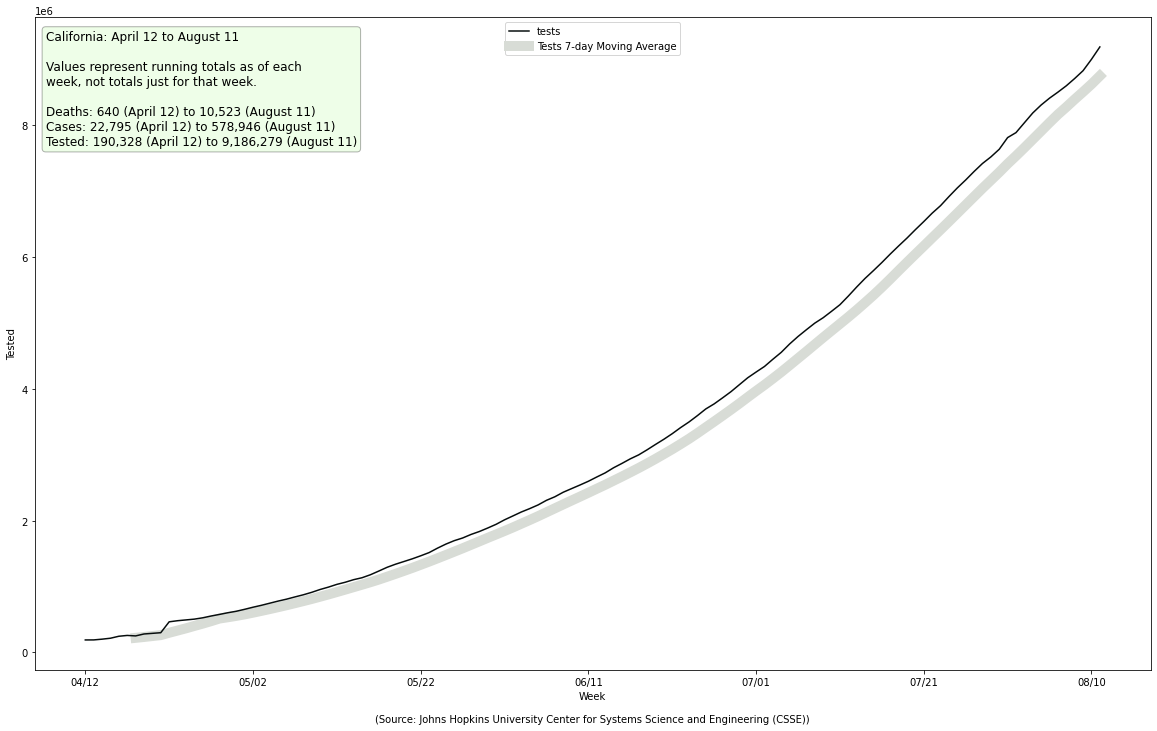

In [36]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-tests.png', 
           metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aec867730>)

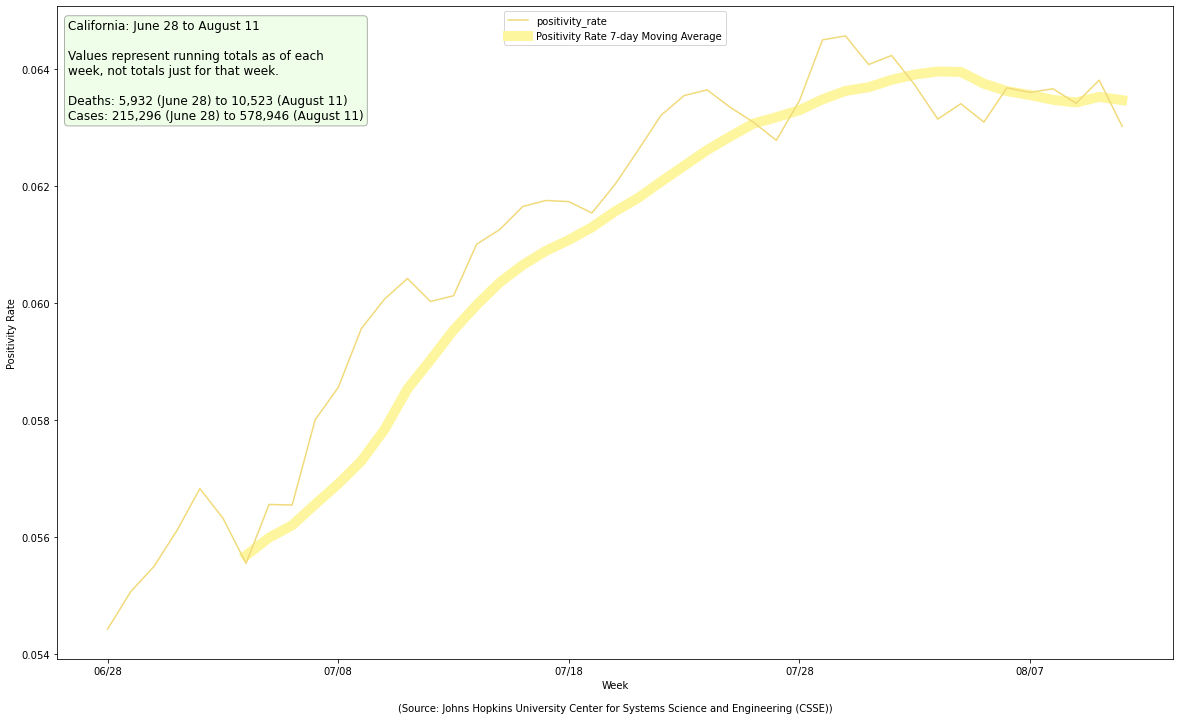

In [37]:
plot_state(df_positivity_dates, SOURCE, 'California', image_file='jhu-ca-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

#### Washington

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed2c9f70>)

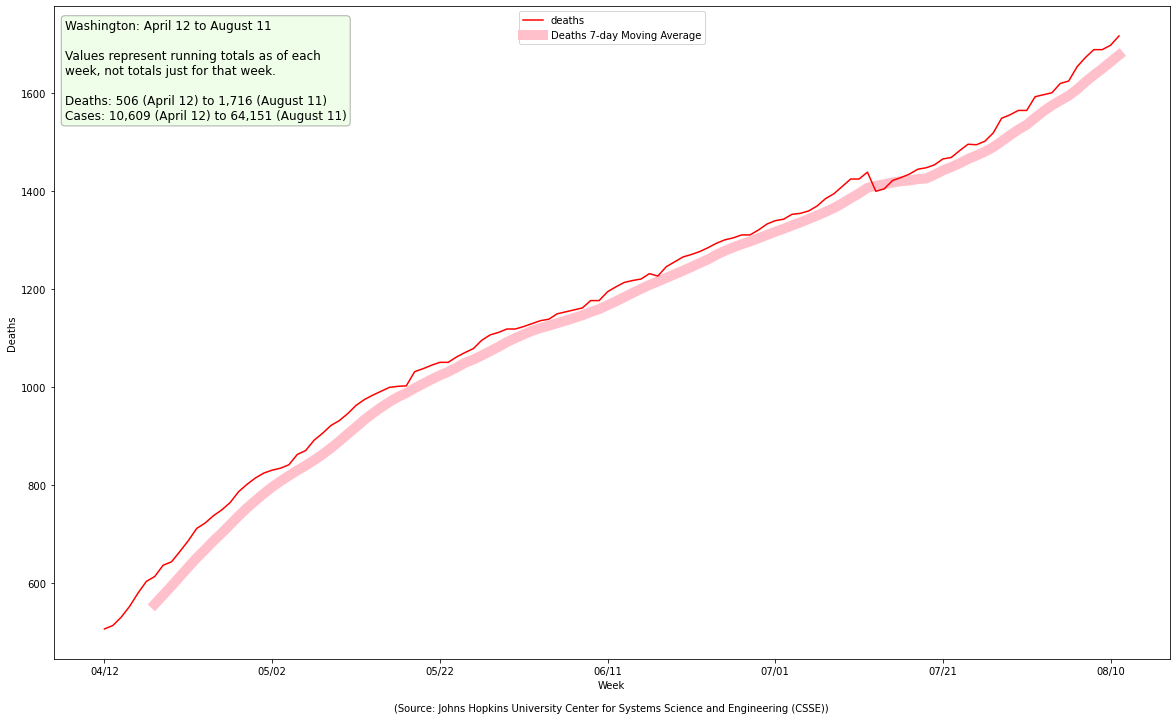

In [38]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aeee7a460>)

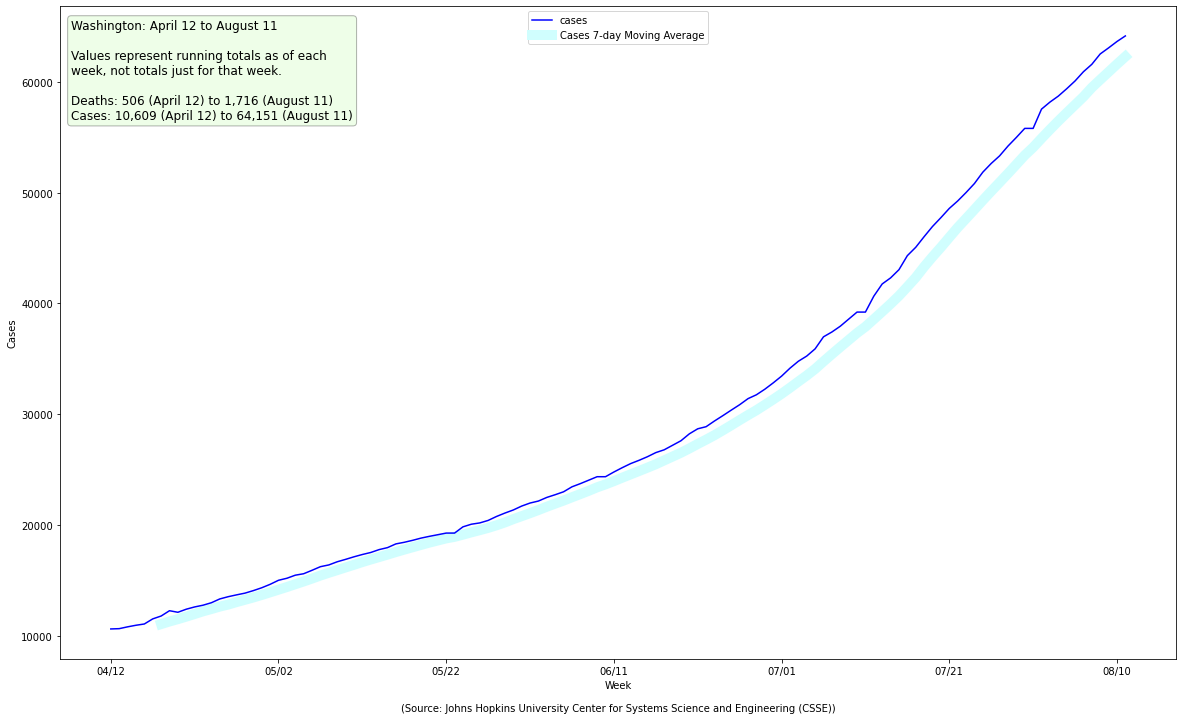

In [39]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aec8b1d60>)

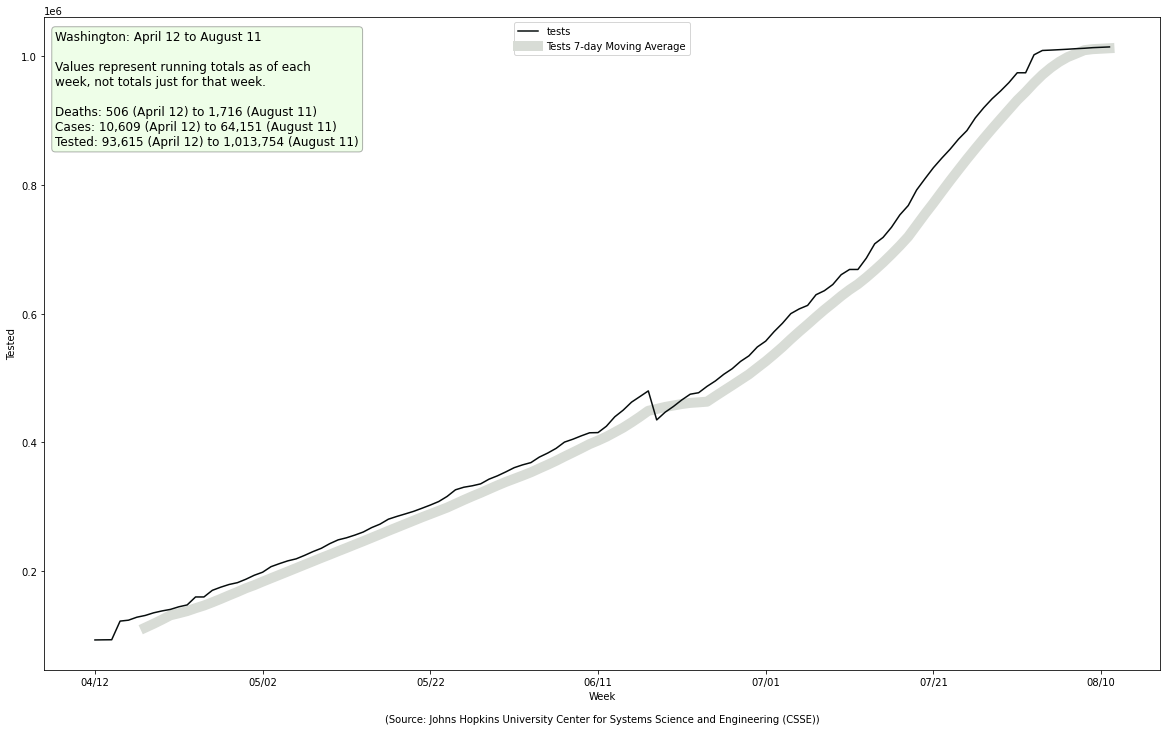

In [40]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aeda539a0>)

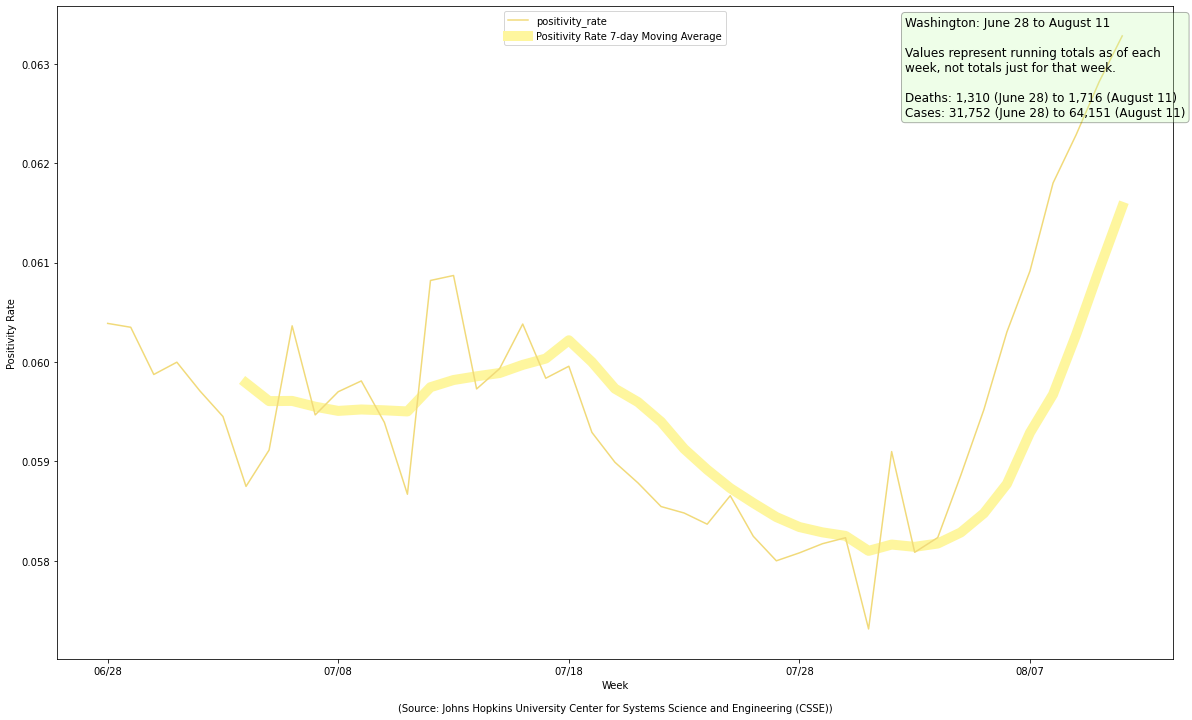

In [41]:
plot_state(df_positivity_dates, SOURCE, 'Washington', image_file='jhu-wa-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True, textbox_loc=(0.76, 0.985))

#### Delaware

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aef47fb20>)

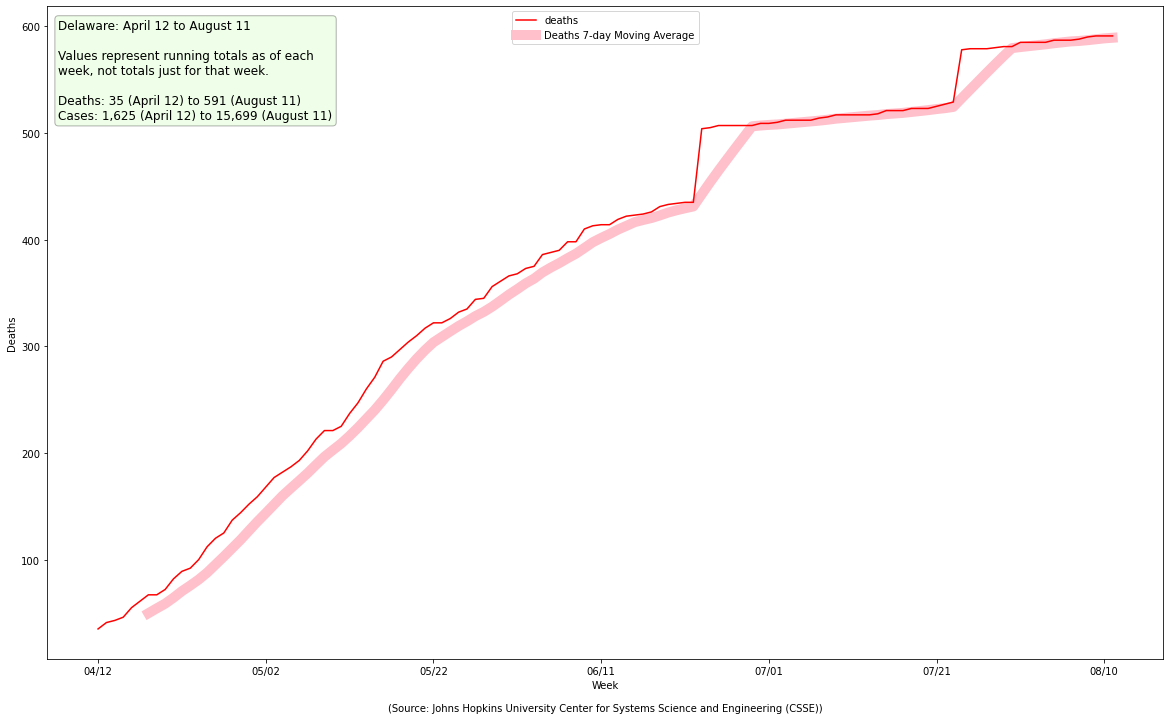

In [42]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aec871a30>)

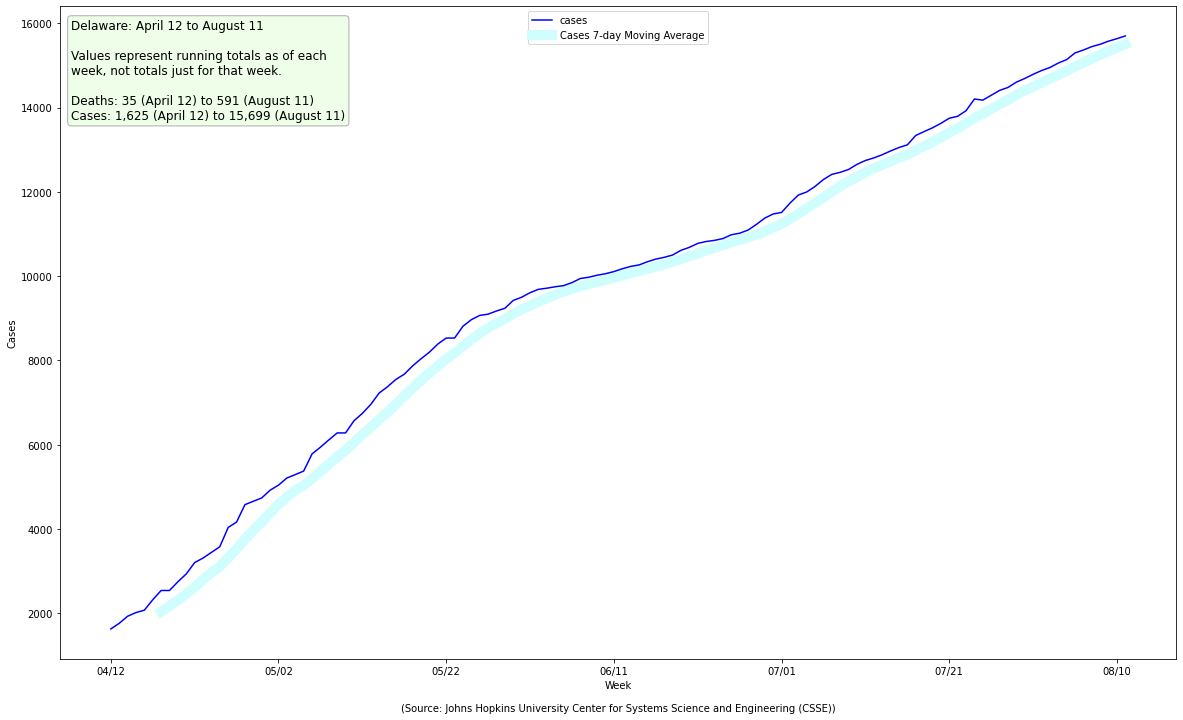

In [43]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-cases.png', metrics={MetricType.CASES}, moving_average=True)

#### Texas

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aef5eedf0>)

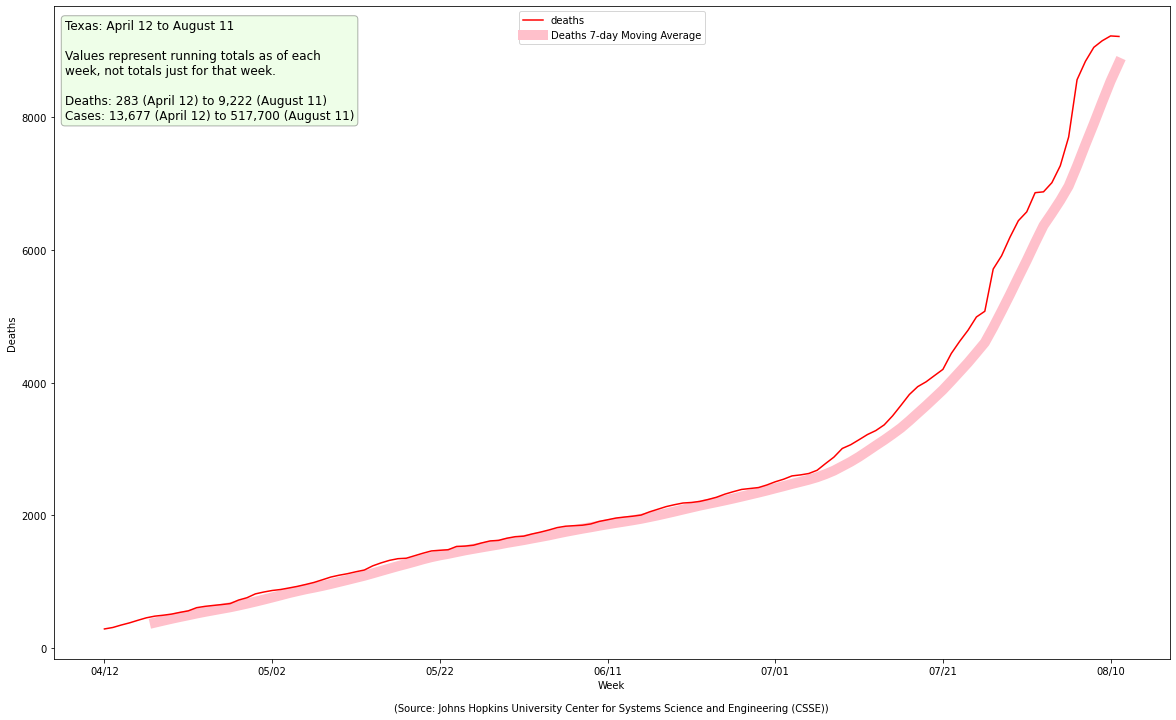

In [44]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aeca54430>)

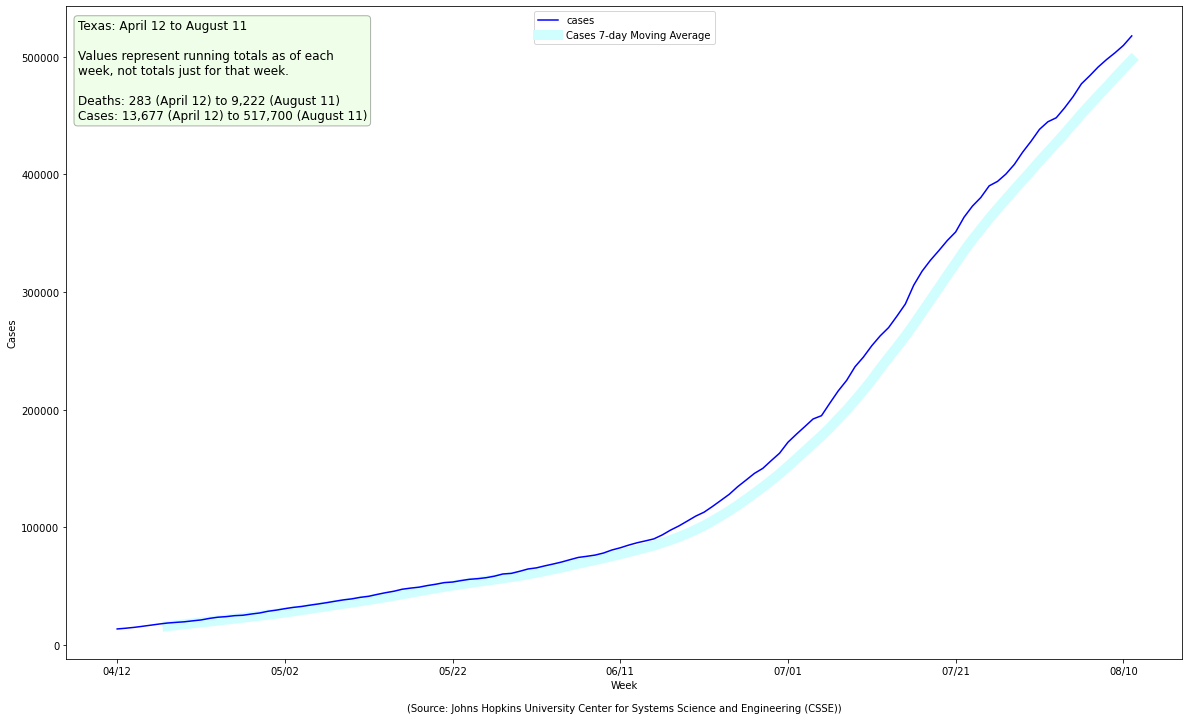

In [45]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed4545b0>)

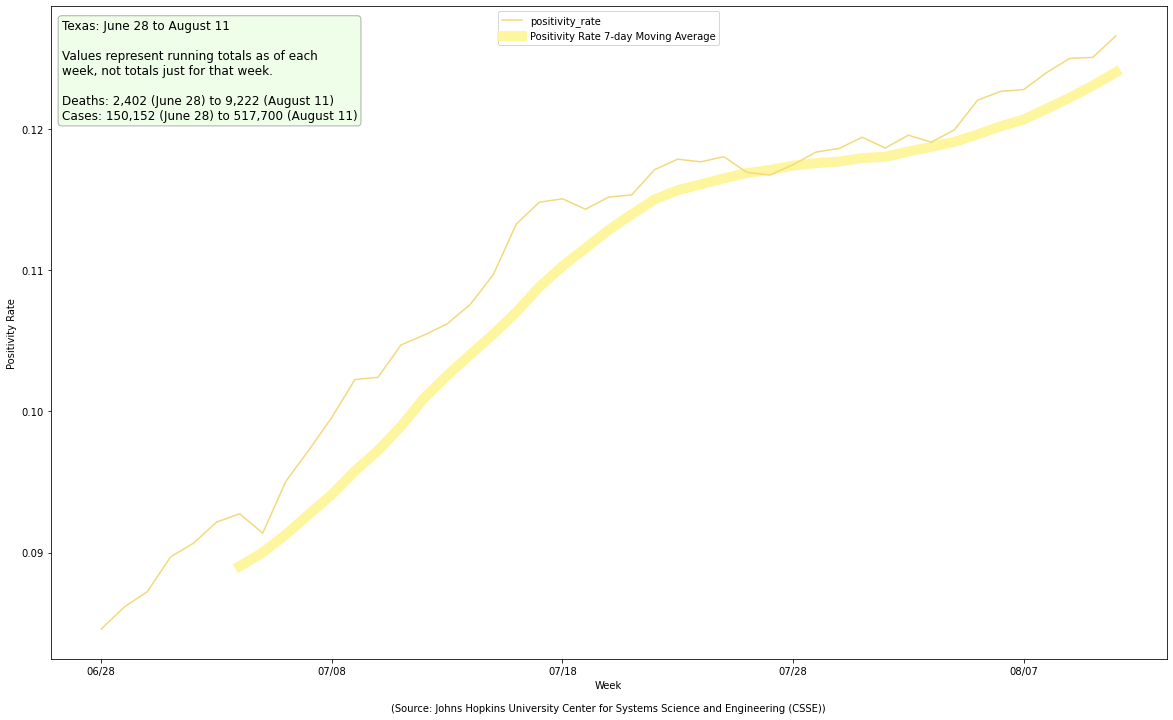

In [46]:
plot_state(df_positivity_dates, SOURCE, 'Texas', image_file='jhu-tx-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aeee209a0>)

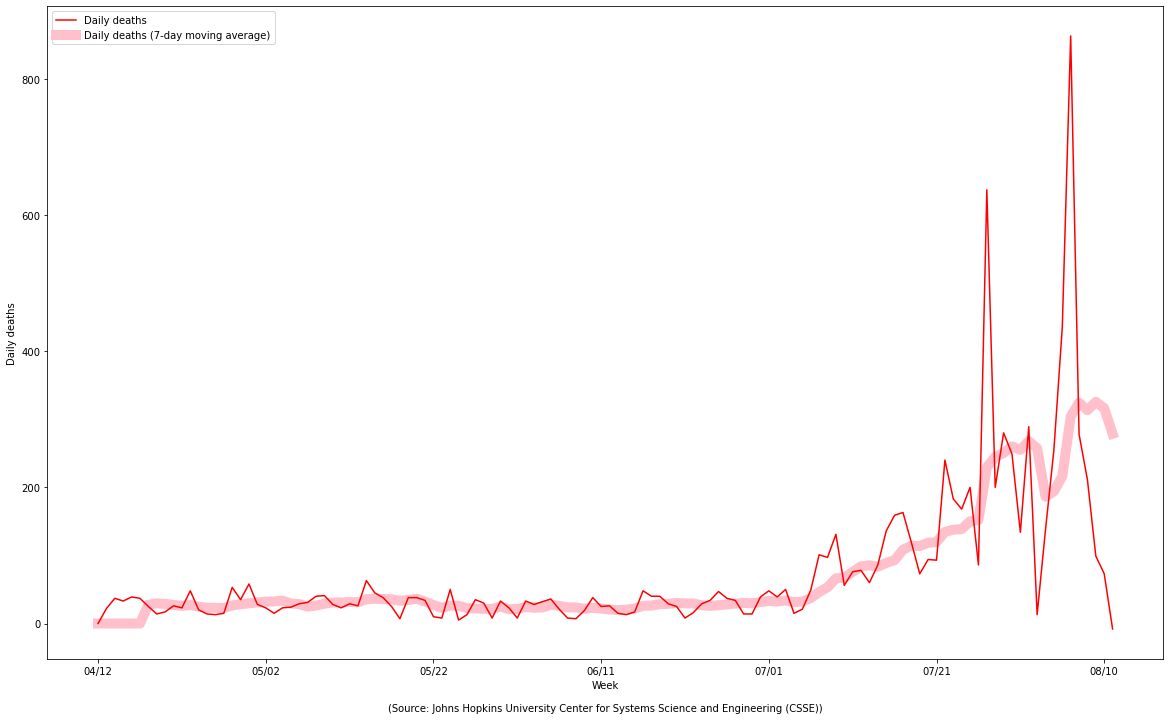

In [47]:
plot_daily_stats(df, SOURCE, region='Texas', metric=MetricType.DEATHS, moving_average=True, image_file="jhu-tx-daily-deaths.png")

#### Georgia

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee7cbbb0>)

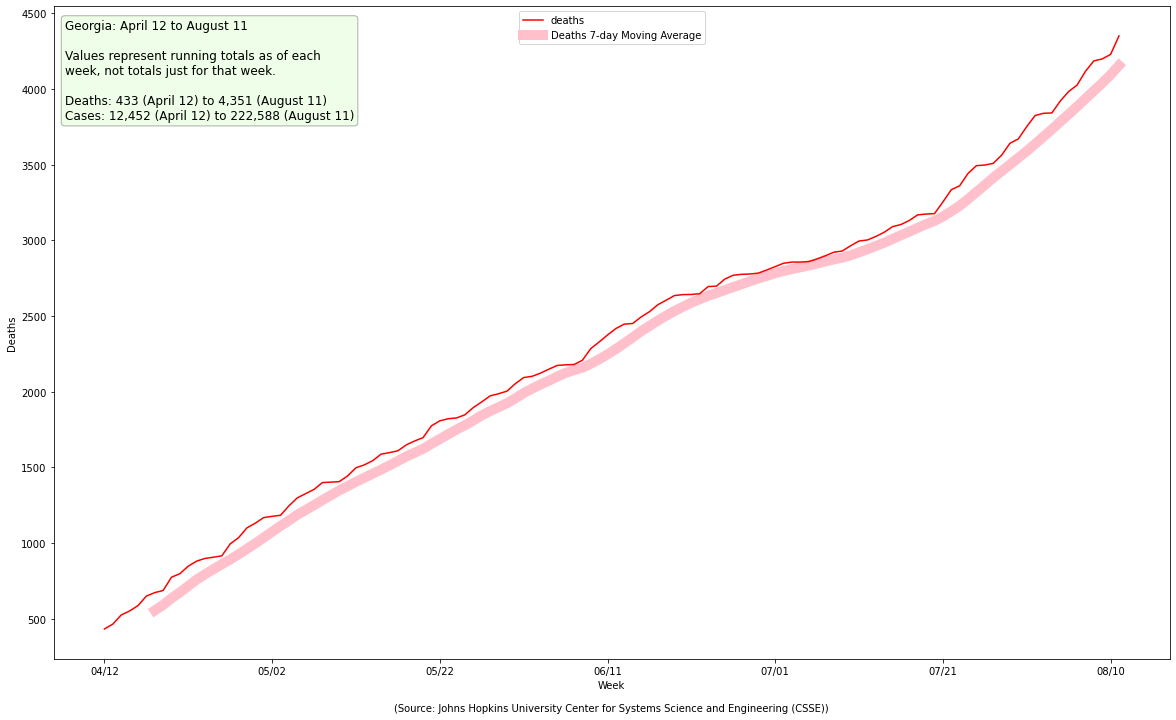

In [48]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aef184430>)

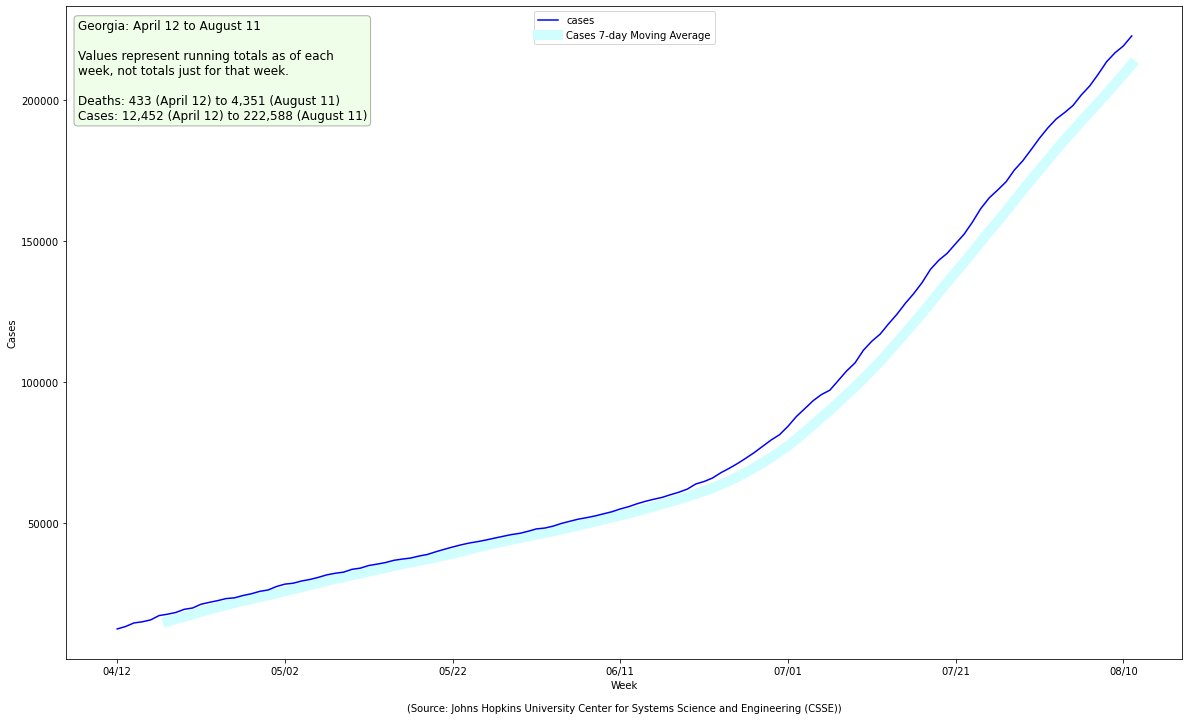

In [49]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aeca04a60>)

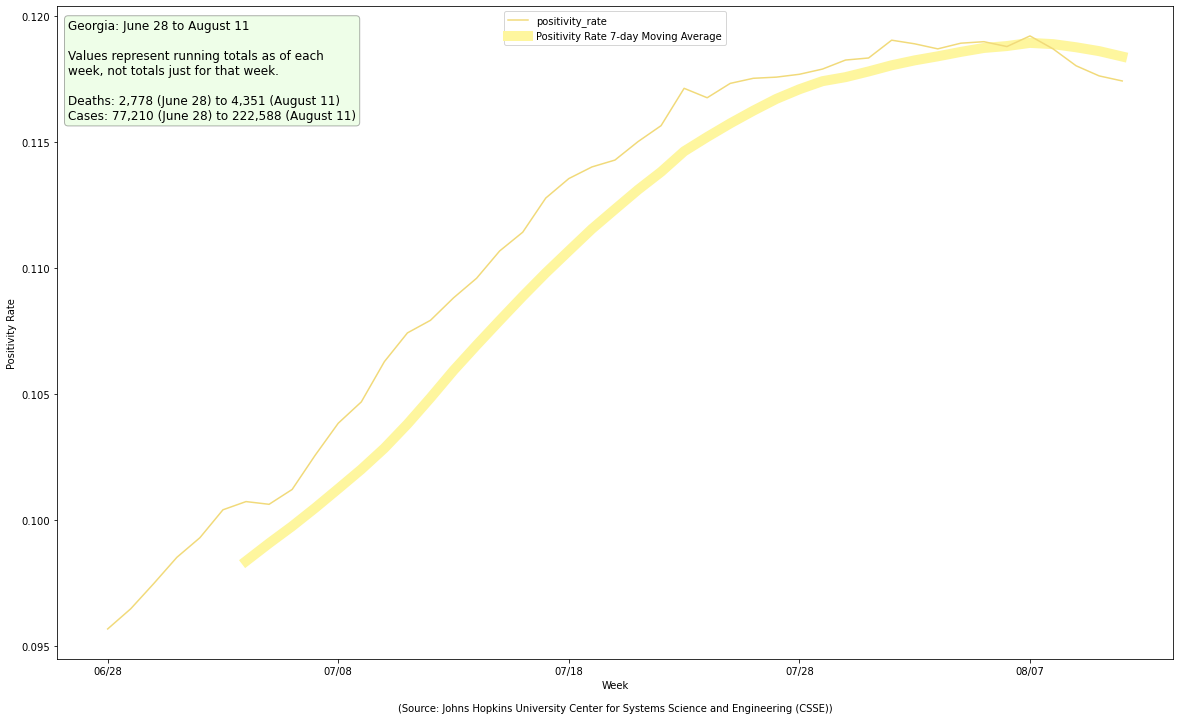

In [50]:
plot_state(df_positivity_dates, SOURCE, 'Georgia', image_file='jhu-ga-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed8e5250>)

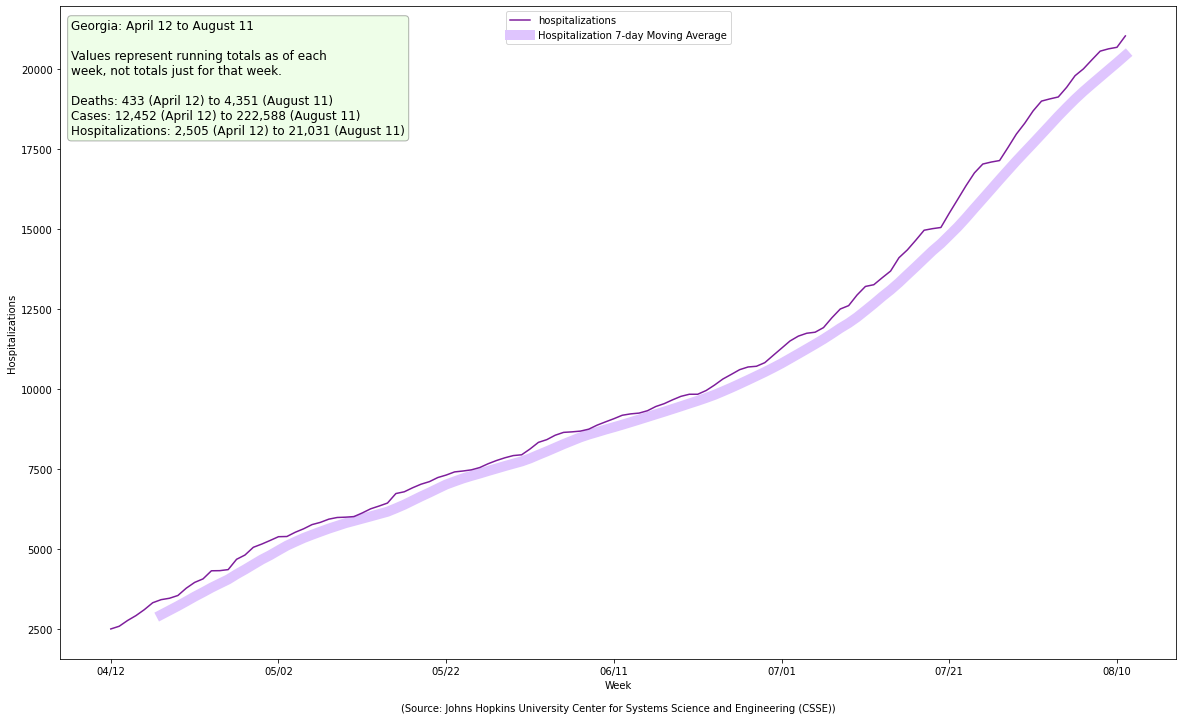

In [51]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aedebe9a0>)

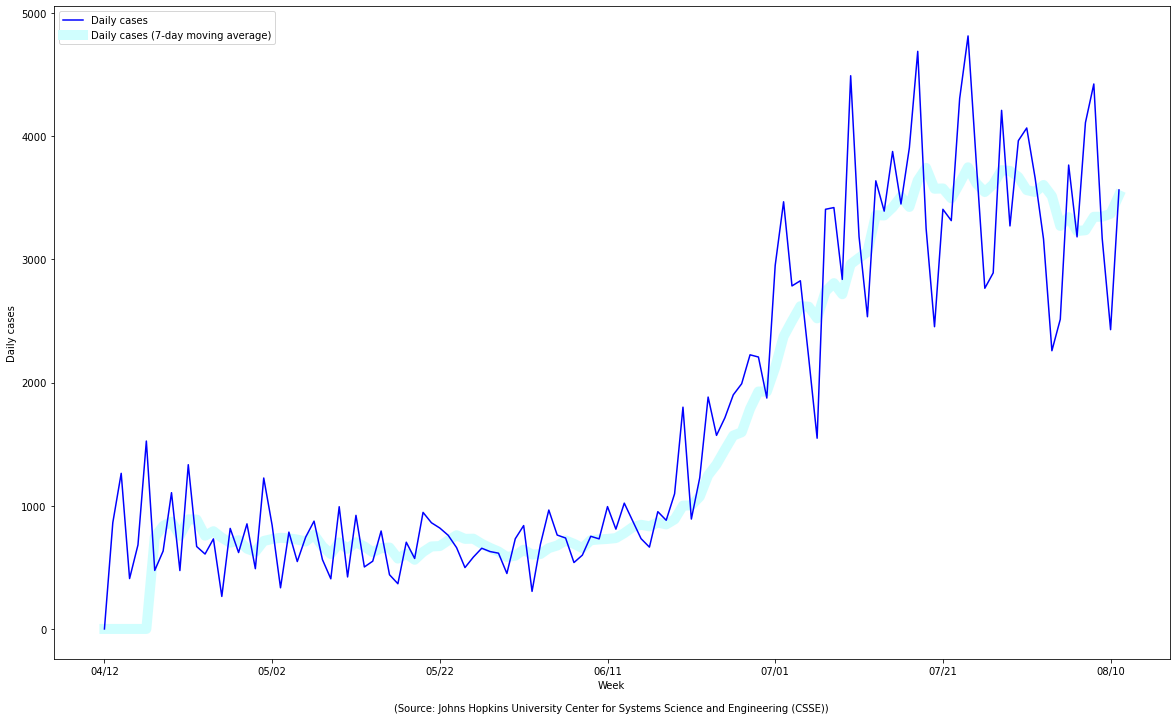

In [52]:
plot_daily_stats(df, SOURCE, region='Georgia', metric=MetricType.CASES, moving_average=True, image_file="jhu-ga-daily-cases.png")

#### Mississippi

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed22e910>)

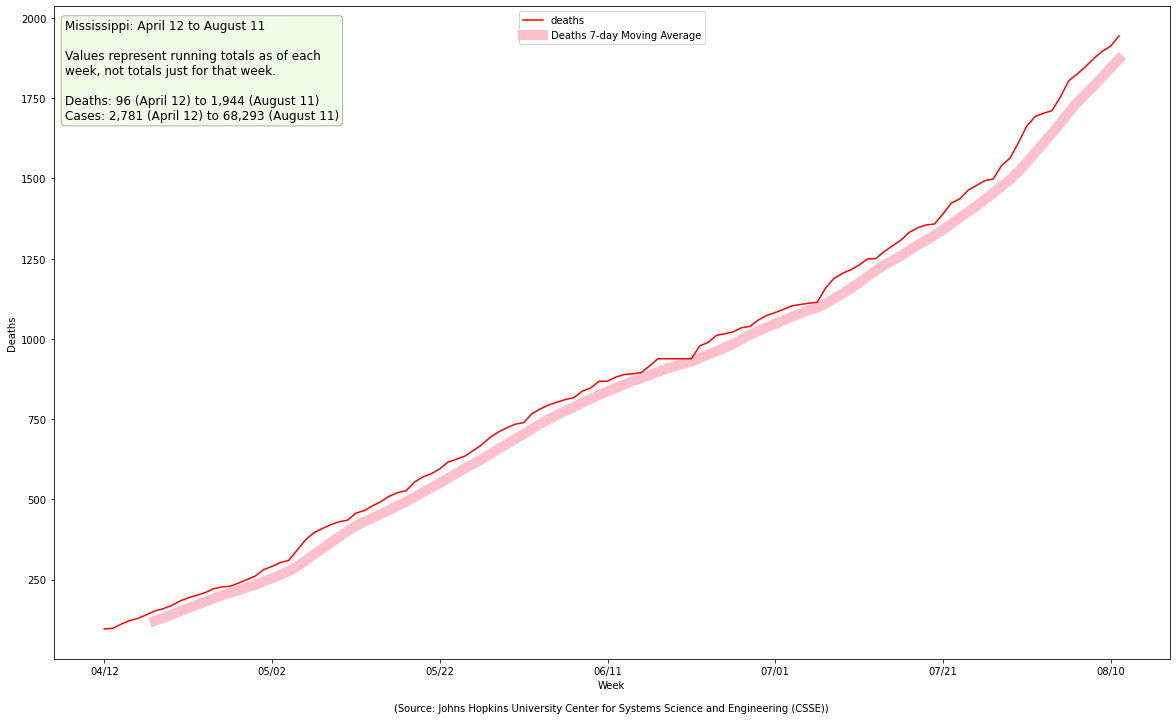

In [53]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b188be5e0>)

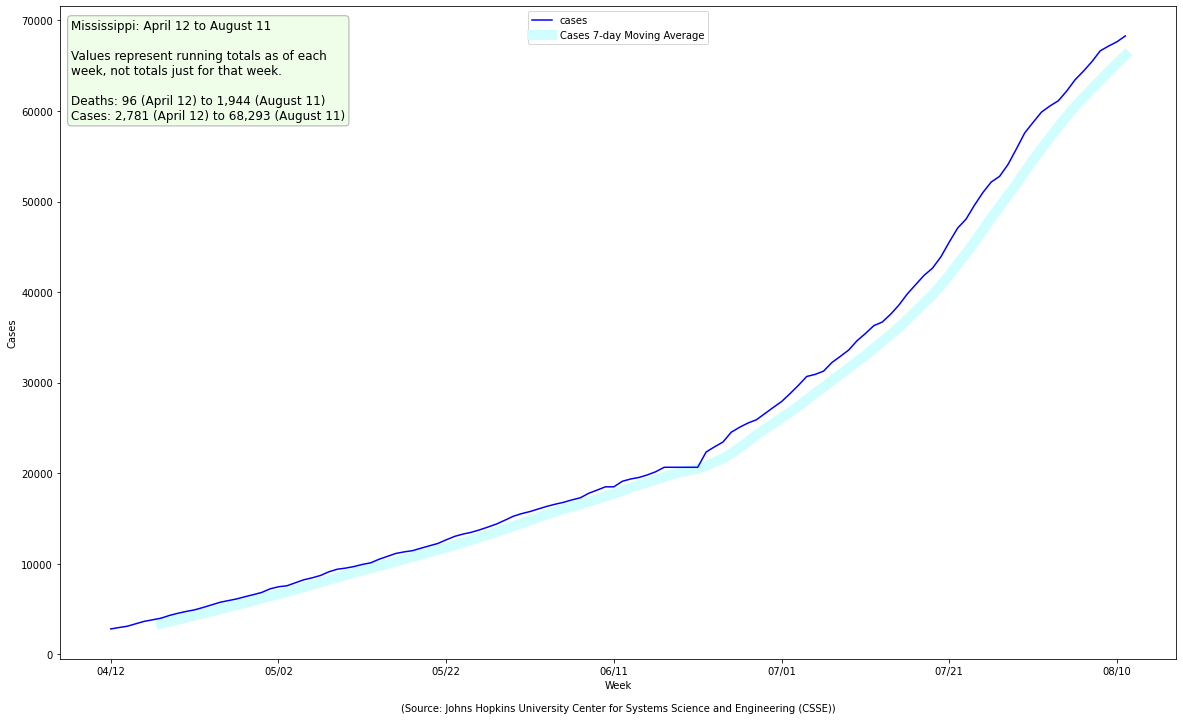

In [54]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed3305e0>)

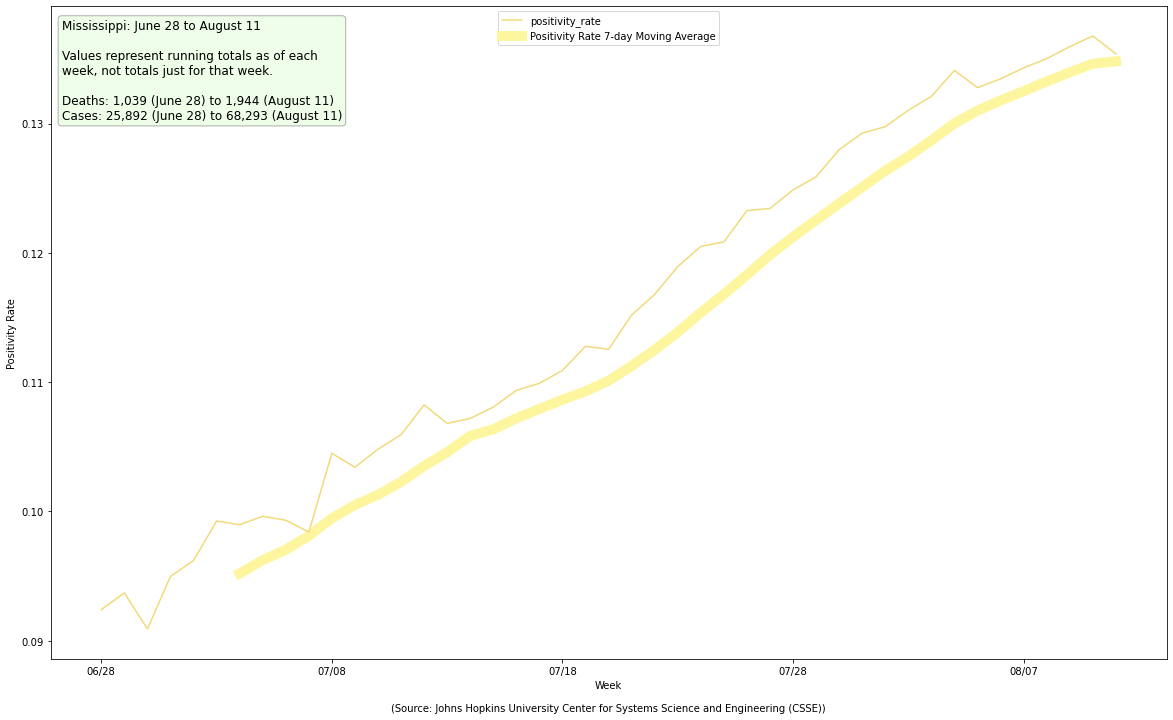

In [55]:
plot_state(df_positivity_dates, SOURCE, 'Mississippi', image_file='jhu-ms-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aeeae2280>)

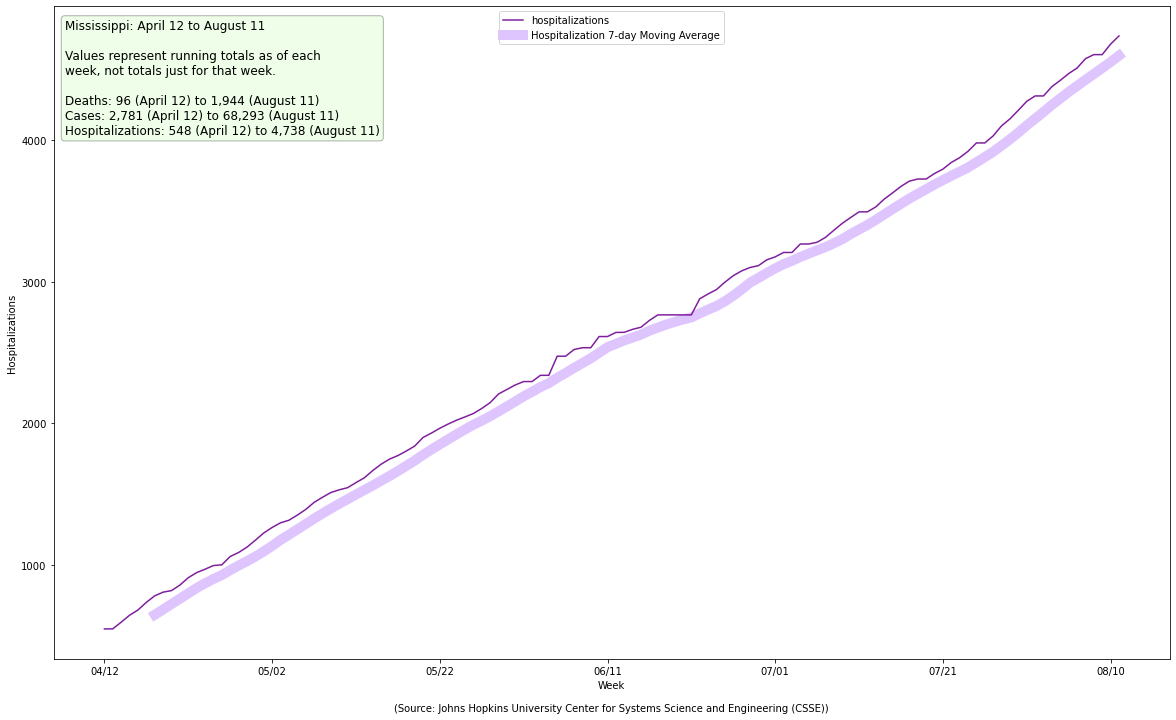

In [56]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Arizona

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed4c0f70>)

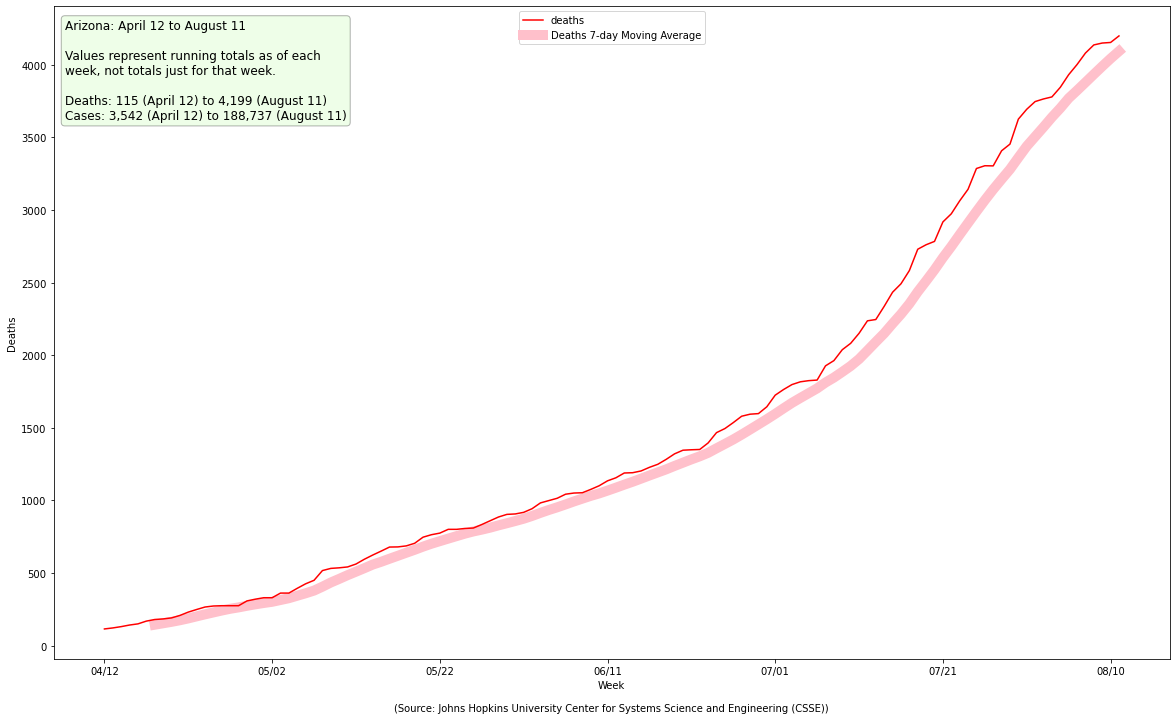

In [57]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed4e0b20>)

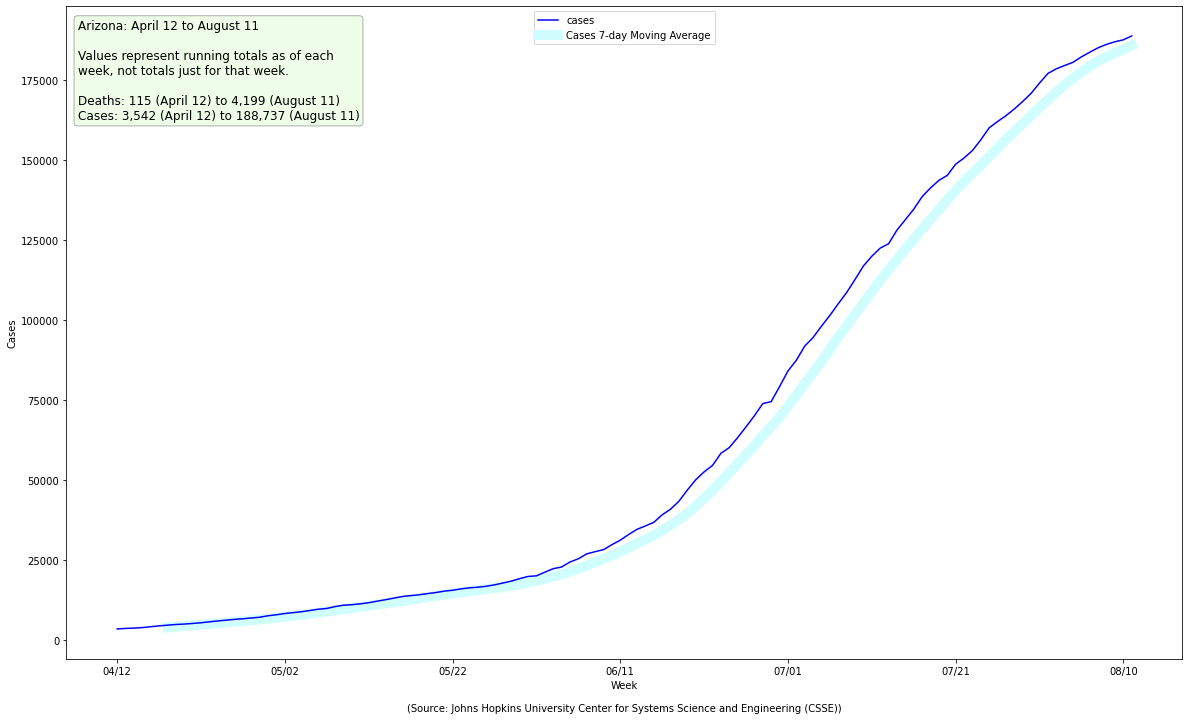

In [58]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee692d00>)

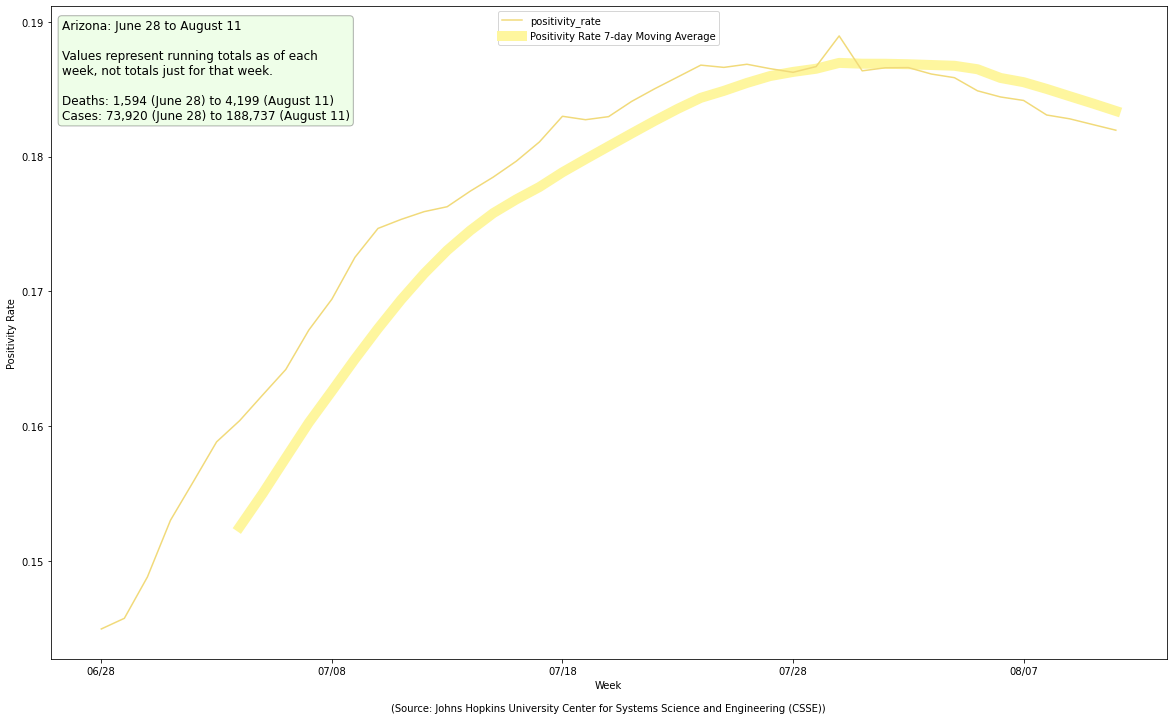

In [59]:
plot_state(df_positivity_dates, SOURCE, 'Arizona', image_file='jhu-az-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b18518580>)

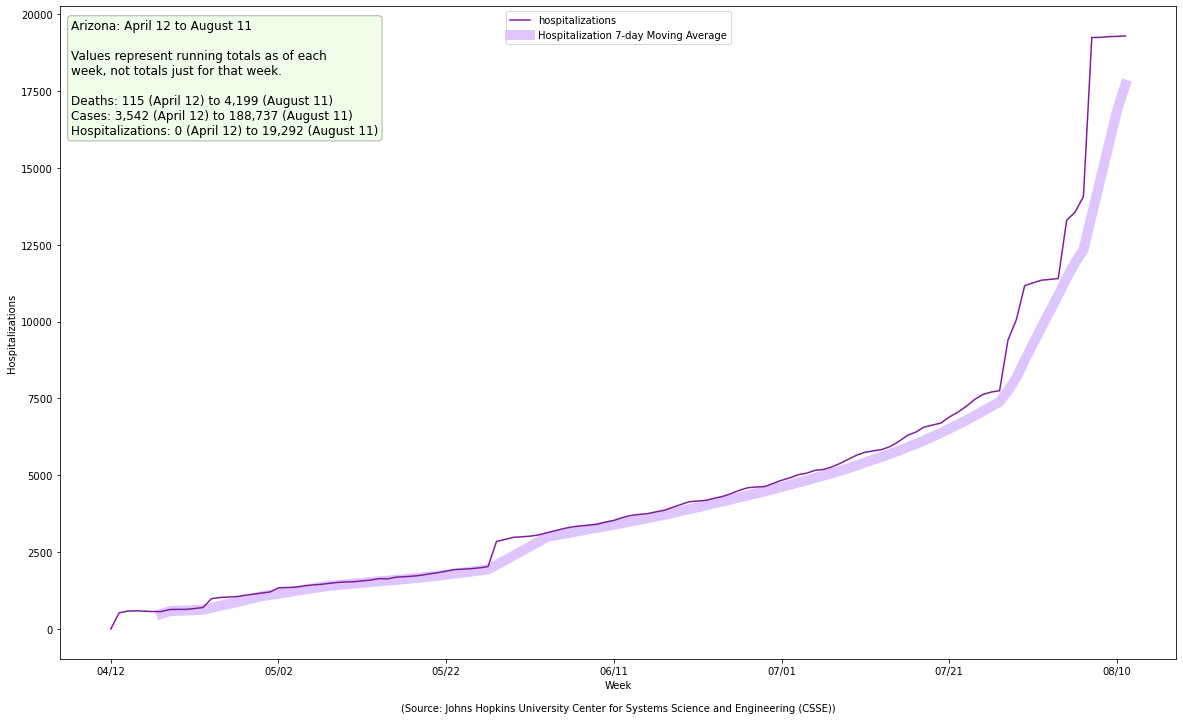

In [60]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Florida

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b1851f4f0>)

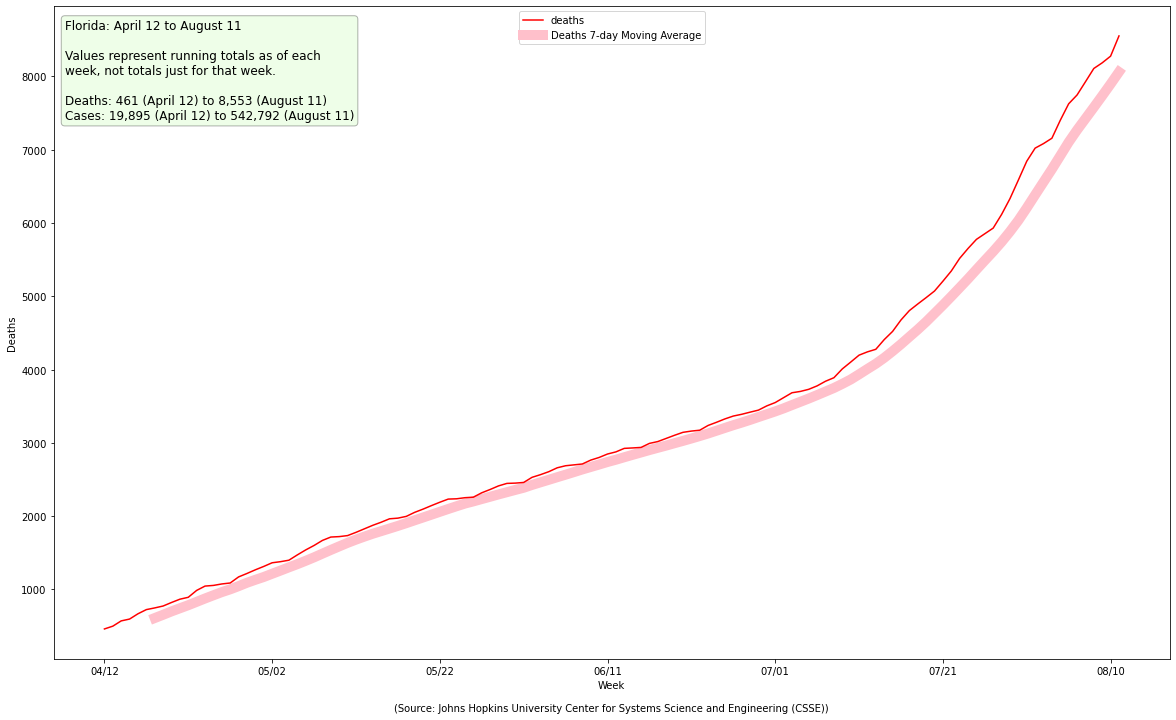

In [61]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed7e40d0>)

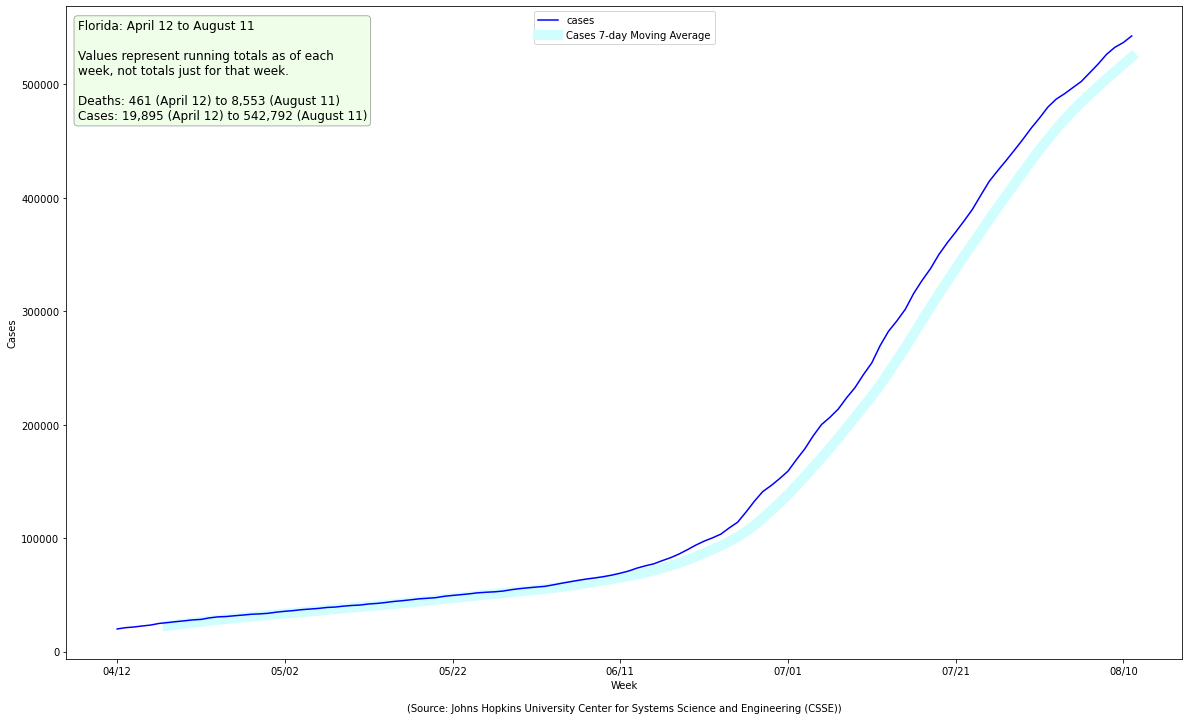

In [62]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b182f0670>)

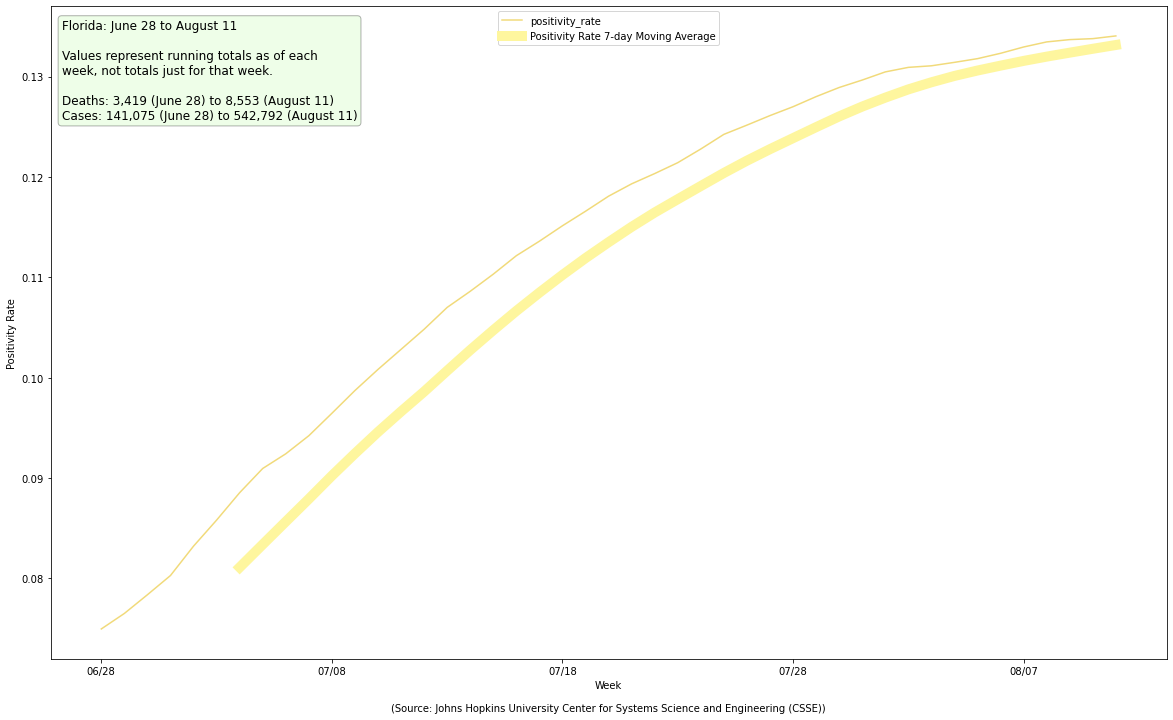

In [63]:
plot_state(df_positivity_dates, SOURCE, 'Florida', image_file='jhu-fl-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b182f0eb0>)

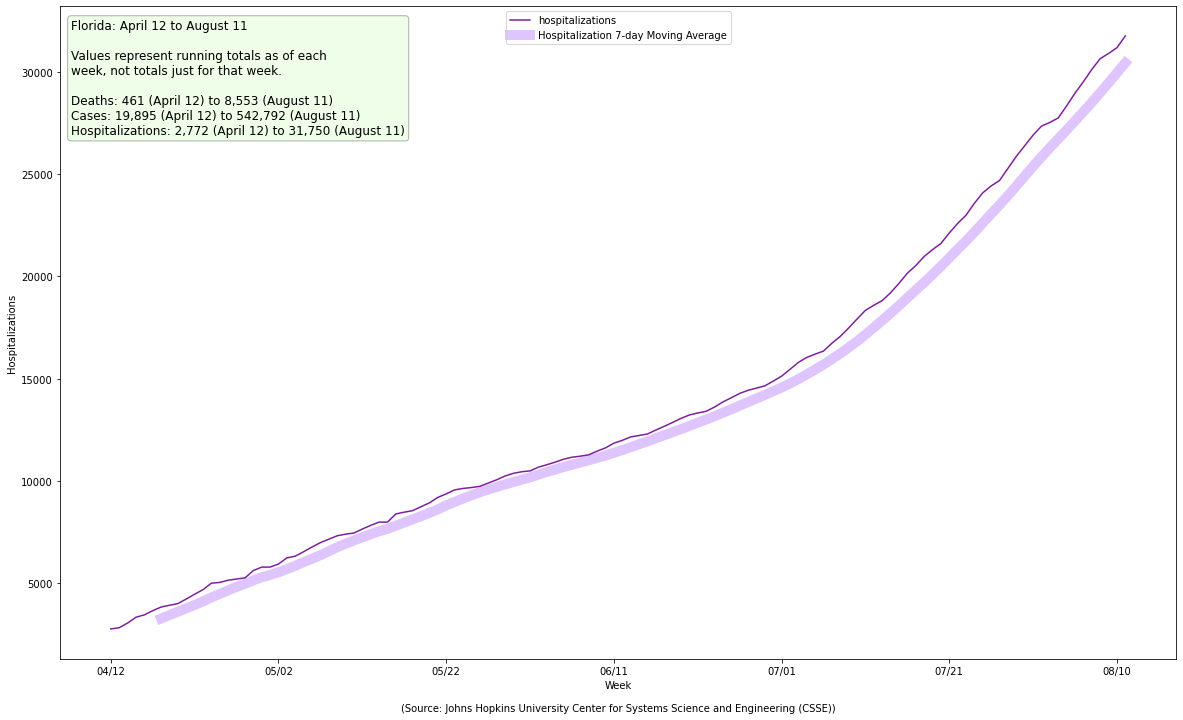

In [64]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

### South Carolina

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aedcd00a0>)

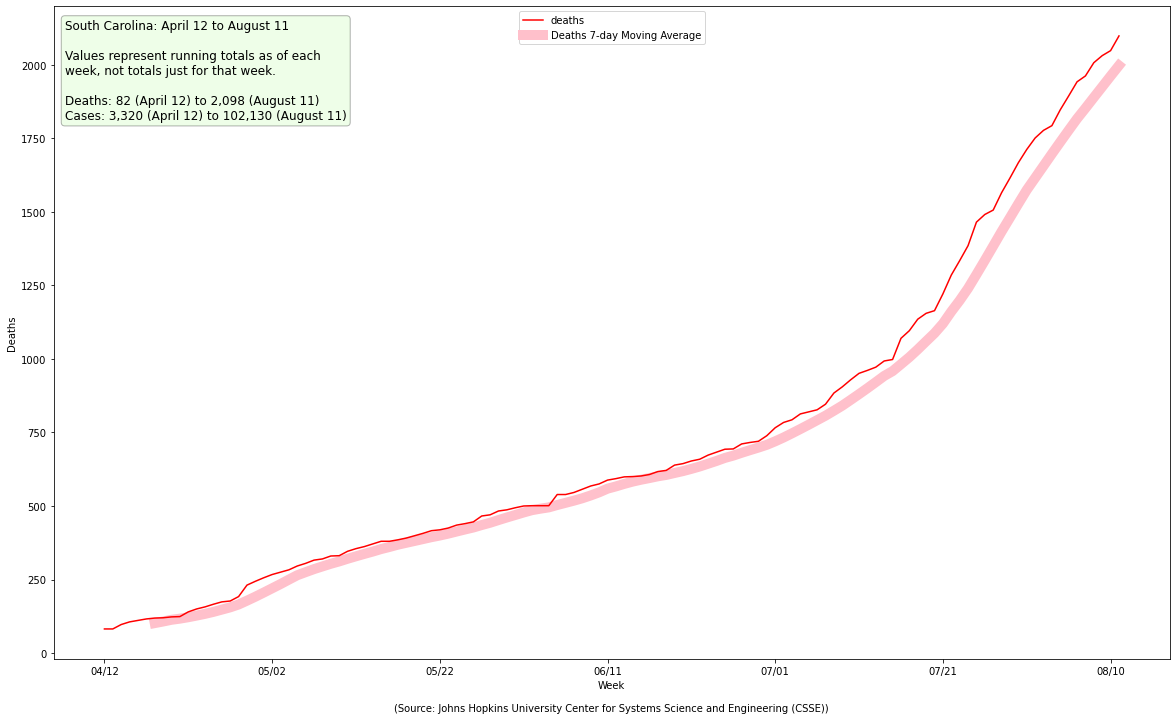

In [65]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aef075670>)

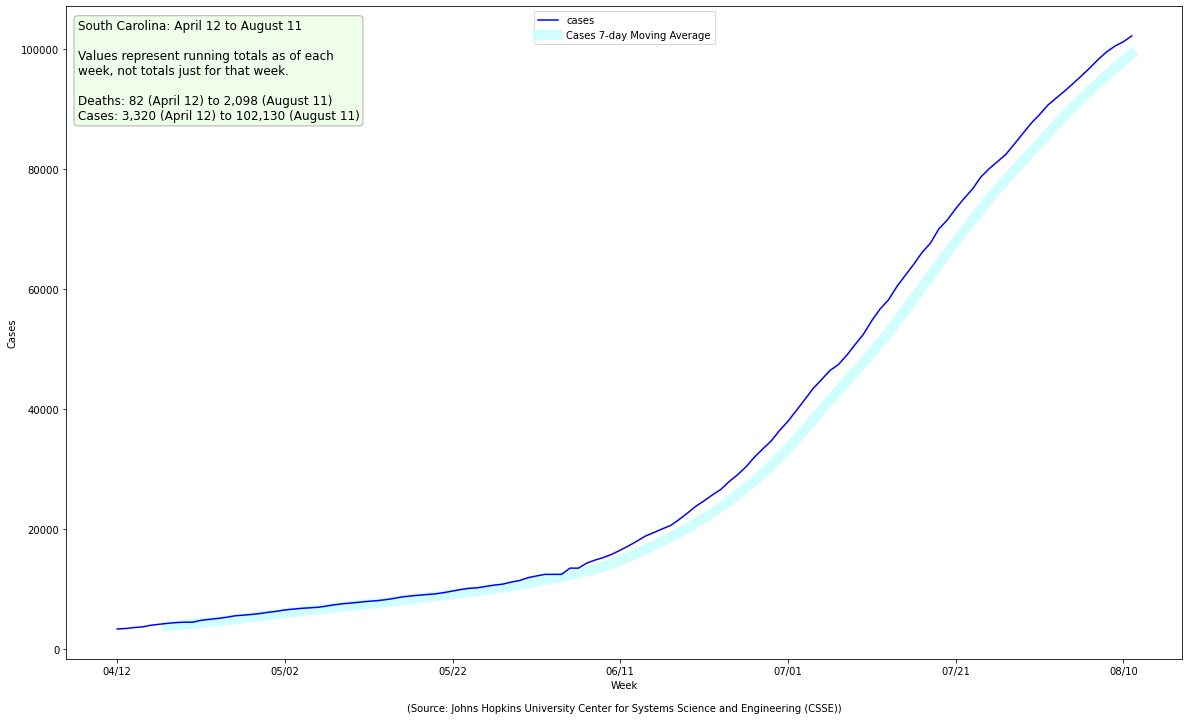

In [66]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aecaecfd0>)

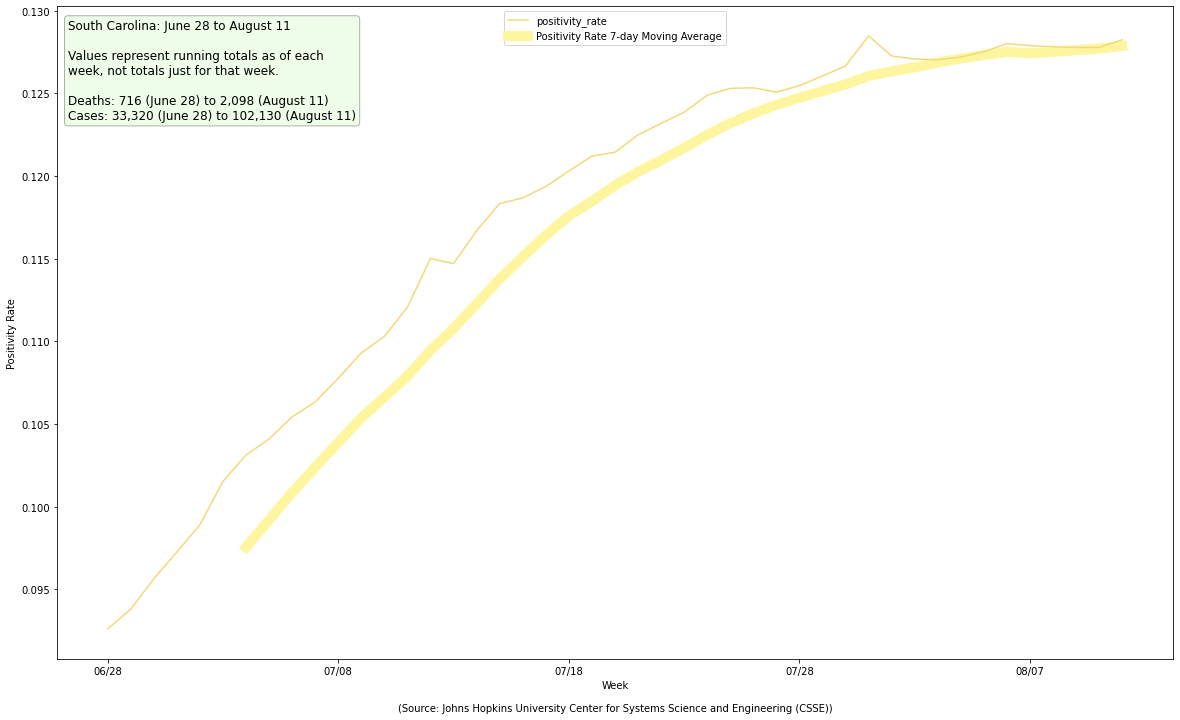

In [67]:
plot_state(df_positivity_dates, SOURCE, 'South Carolina', image_file='jhu-sc-pos.png',
           metrics={MetricType.POSITIVITY}, moving_average=True)

#### Oklahoma

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aecfacf70>)

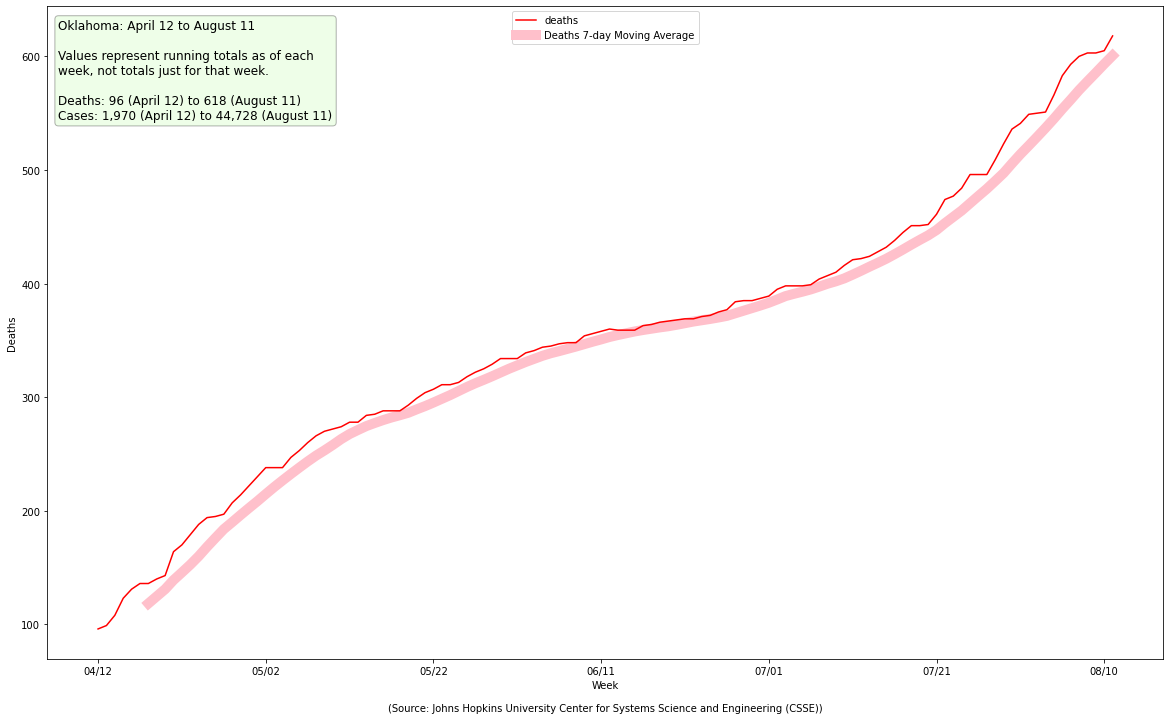

In [68]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aeeab66d0>)

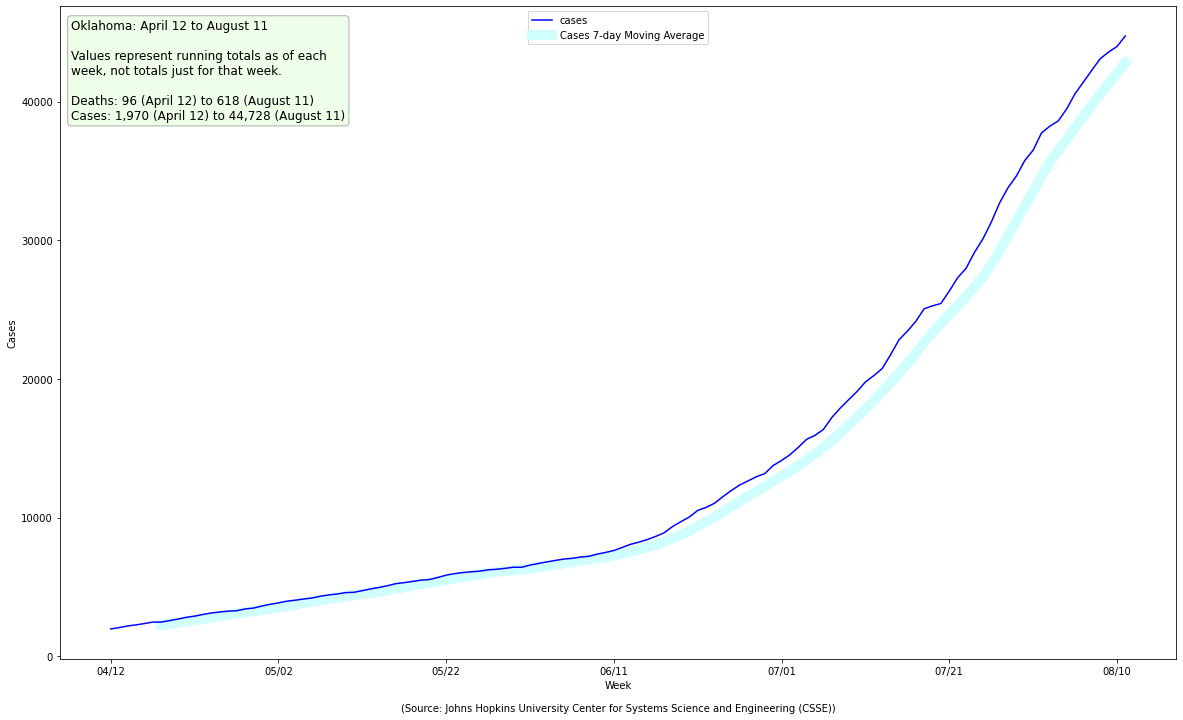

In [69]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee97c370>)

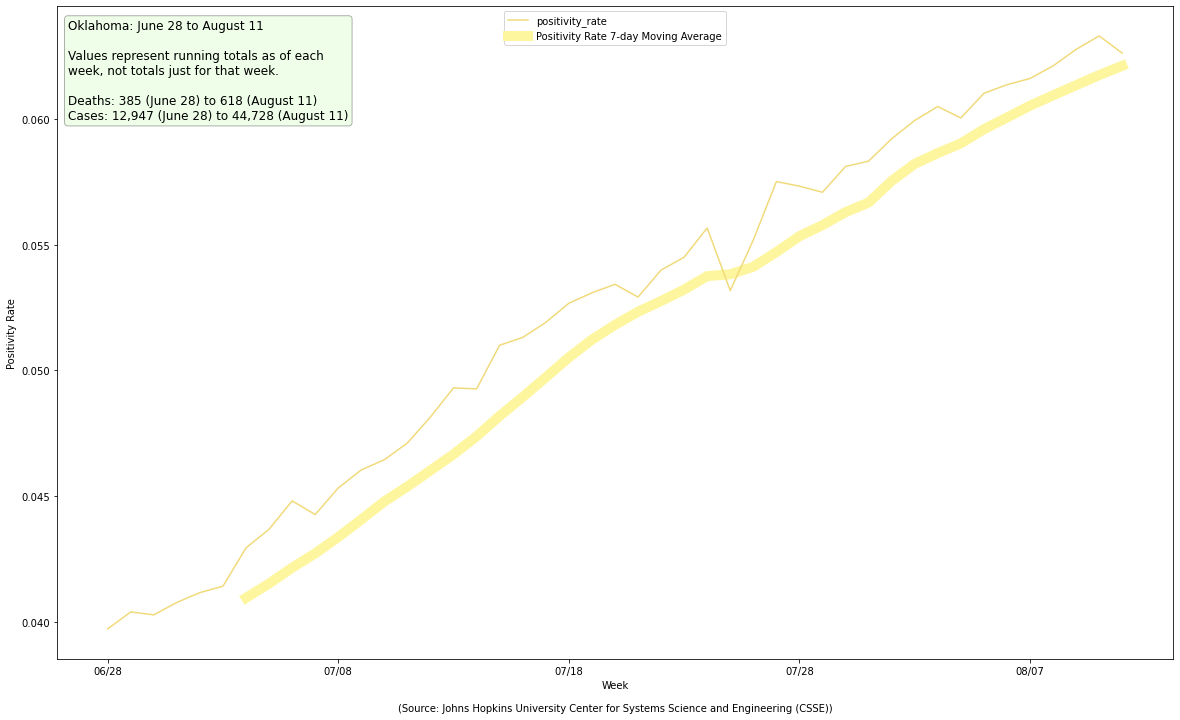

In [70]:
plot_state(df_positivity_dates, SOURCE, 'Oklahoma', image_file='jhu-ok-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed2551c0>)

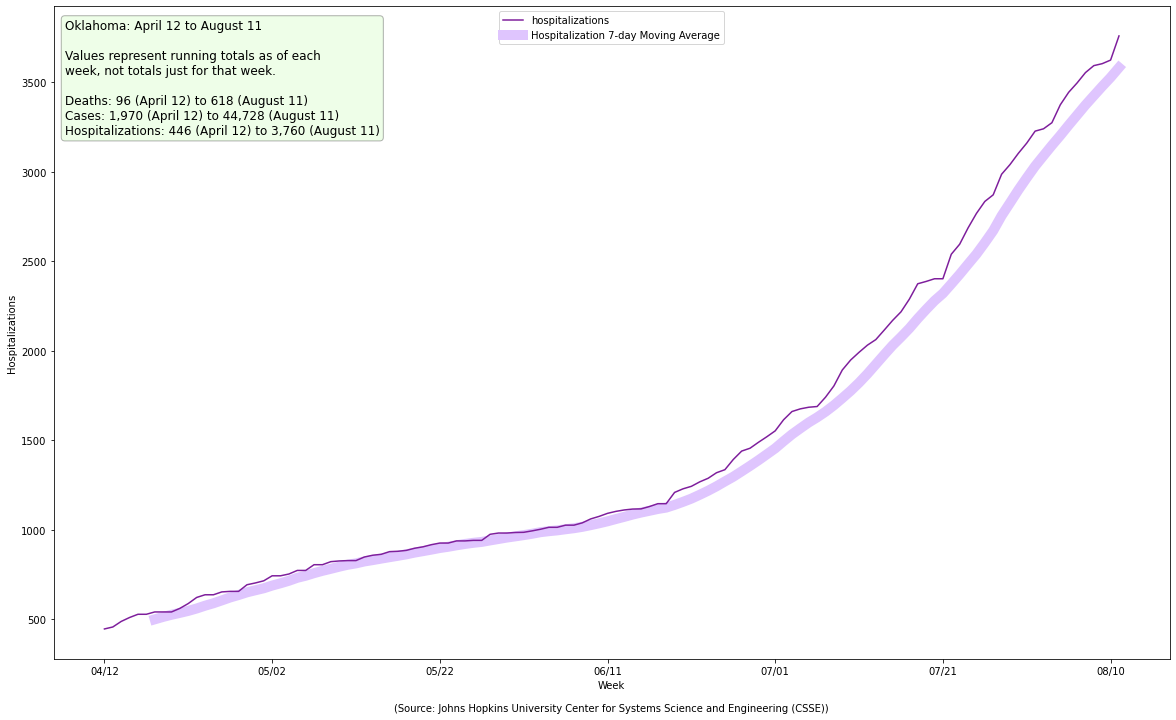

In [71]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

## Multistate

### Northeast states

Data from some of the states that were hardest hit early on.

In [72]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aecb6d100>)

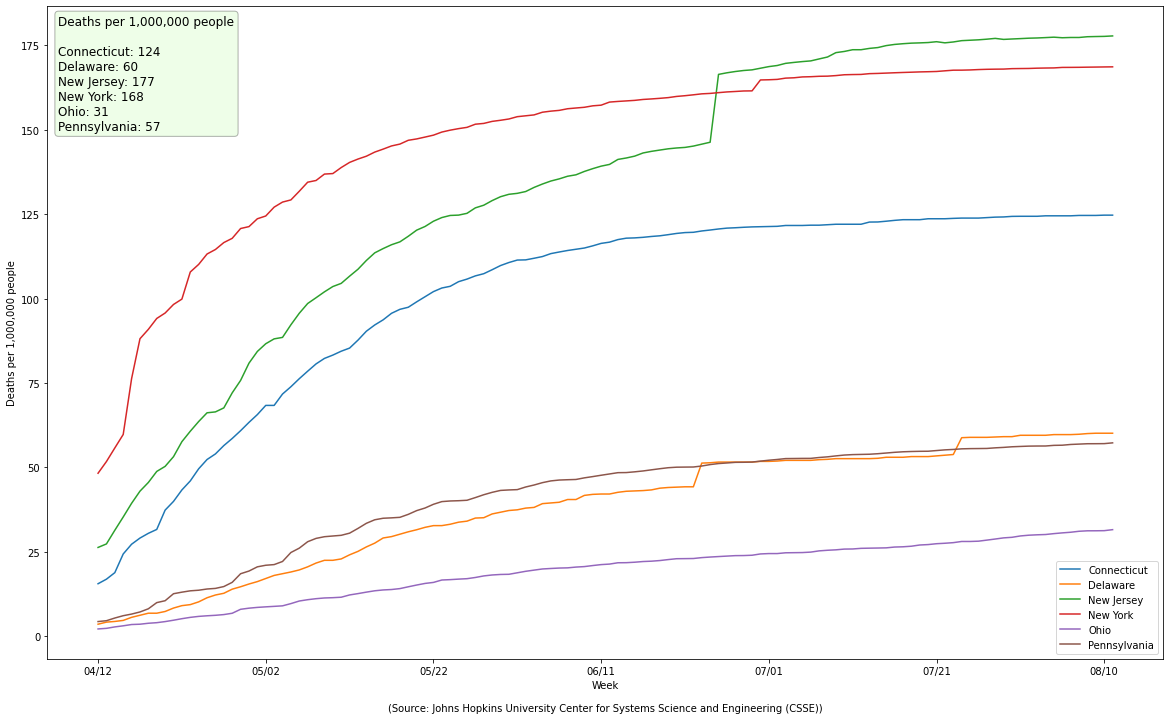

In [73]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS,
            image_file='jhu-ne-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed7b9850>)

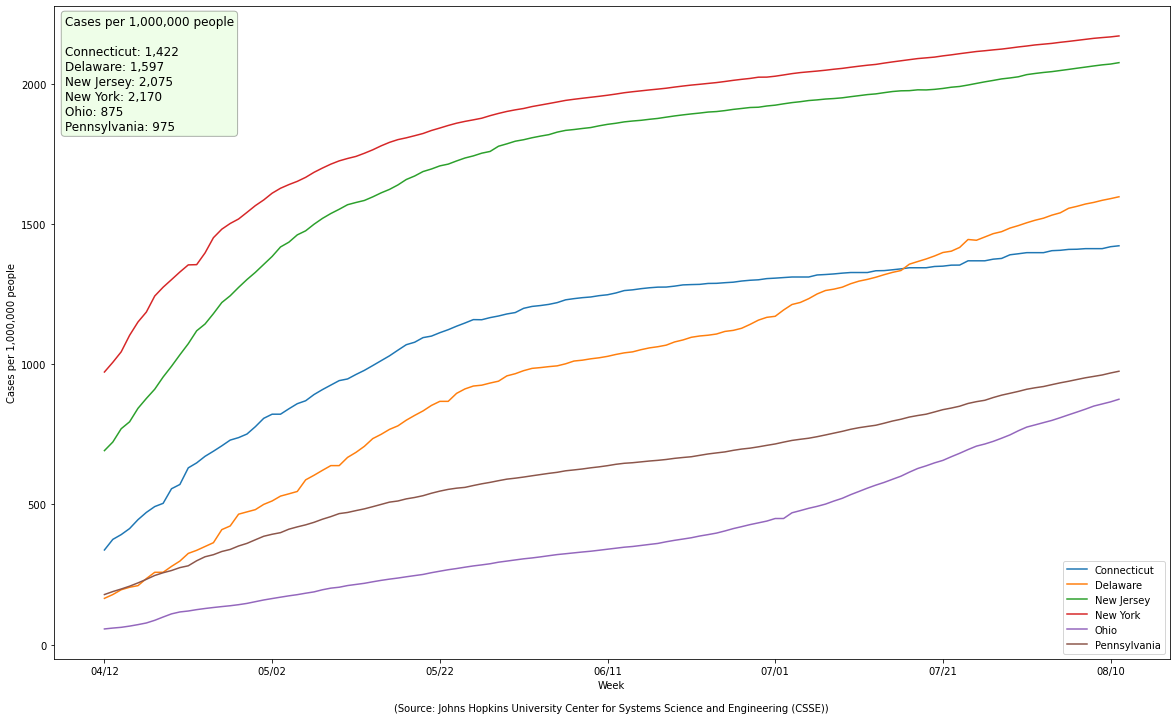

In [74]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES,
            image_file='jhu-ne-states-cases-per-capita.png')

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [75]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aeefd2700>)

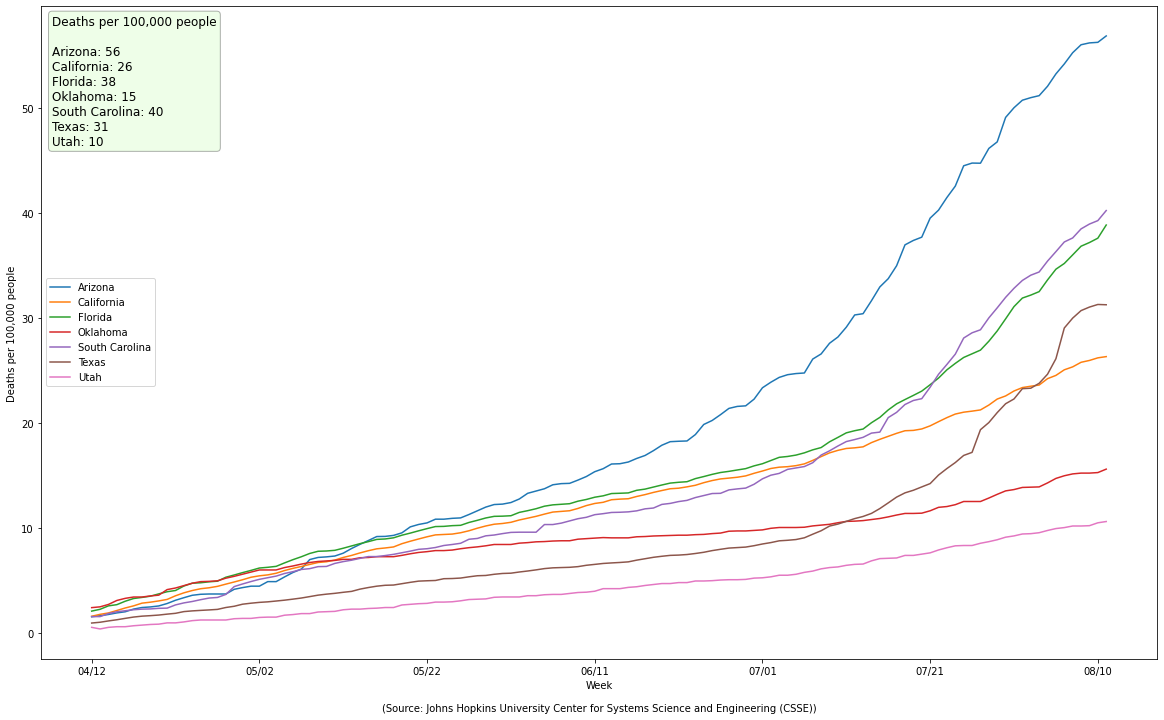

In [76]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='jhu-s-sw-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed0146d0>)

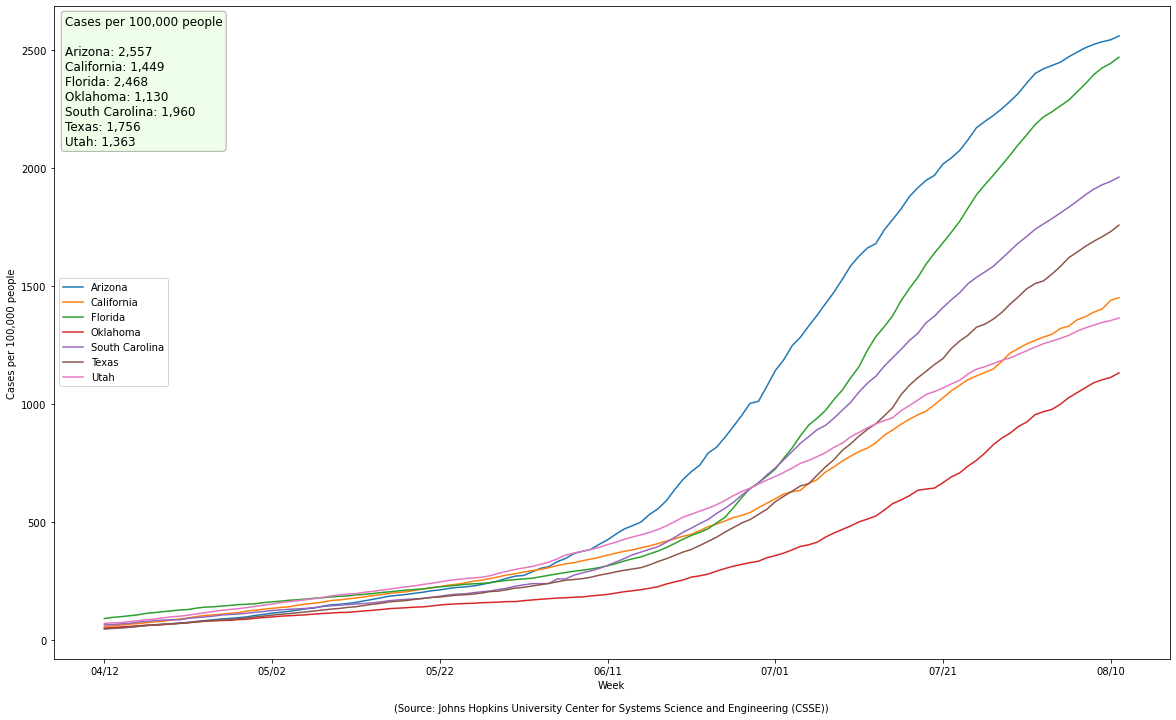

In [77]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-cases-per-capita.png')

How are some of these states doing, compared to Pennsylvania (my home state)?

In [78]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aedee4d00>)

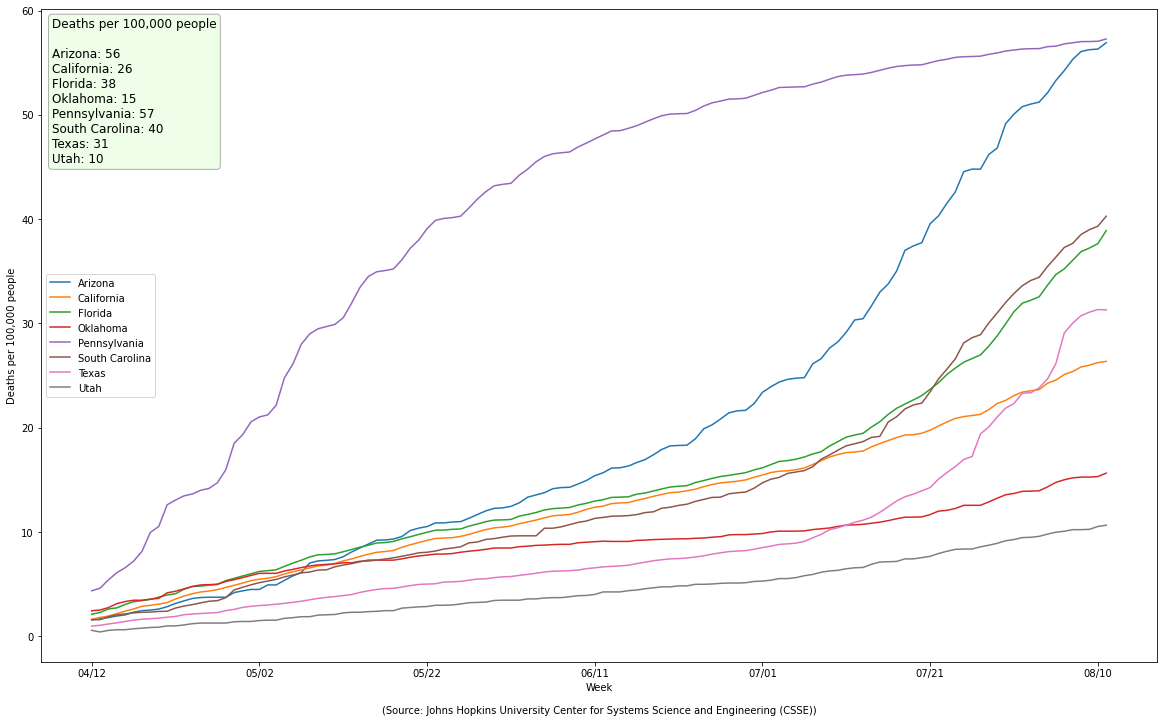

In [79]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS, 
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aef1baf10>)

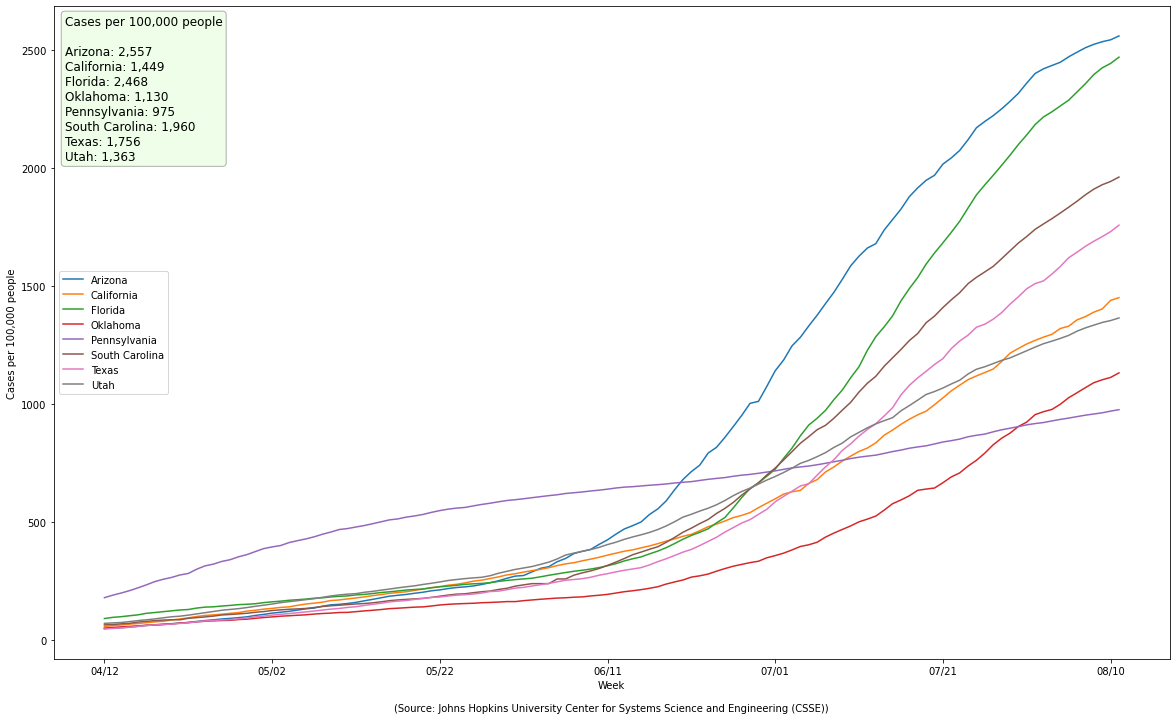

In [80]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-cases-per-capita.png')

## Per-capita rates for all states

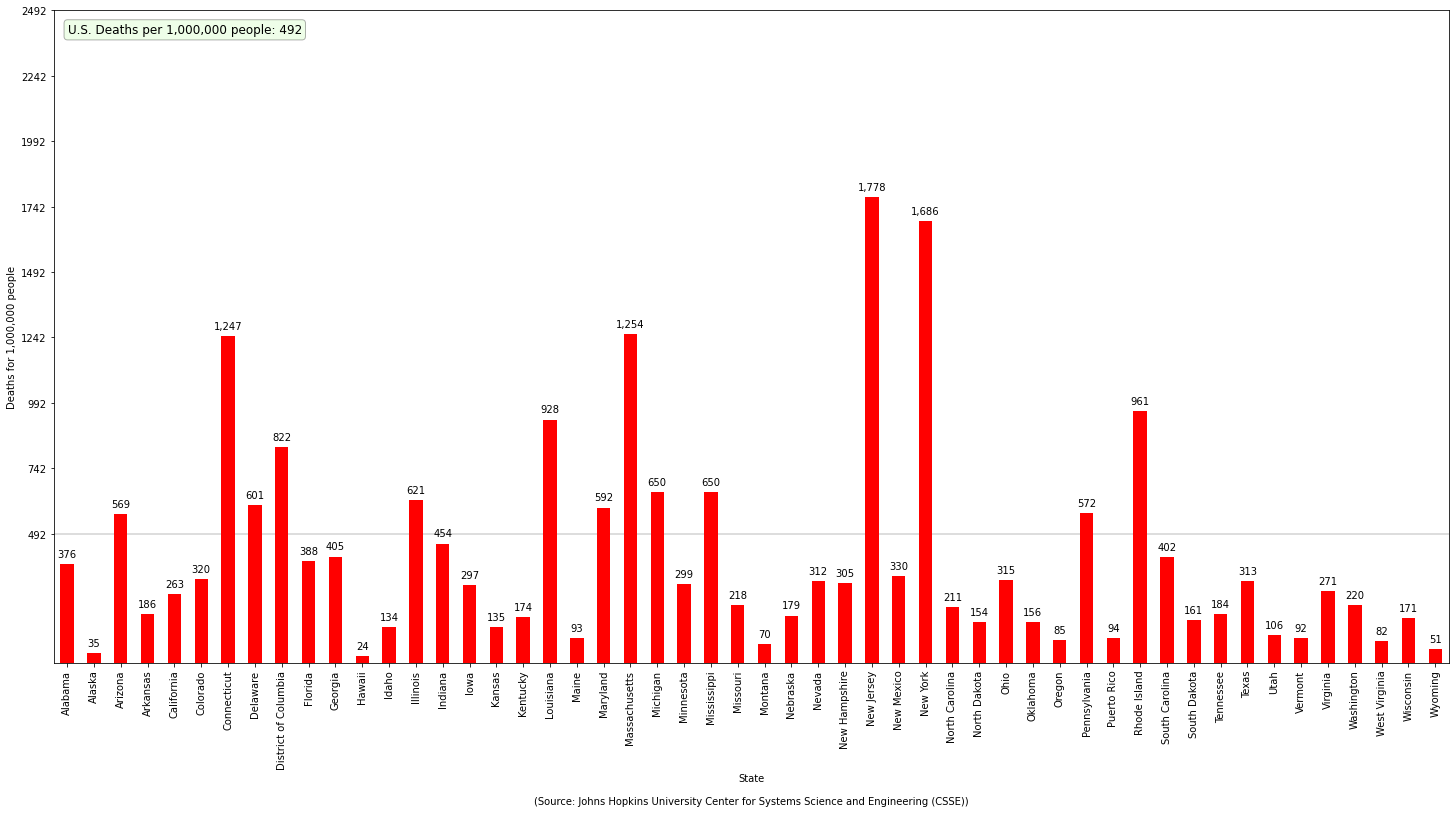

In [81]:
plot_states_per_capita(df, SOURCE, populations, image_file='jhu-state-deaths-per-capita.png');

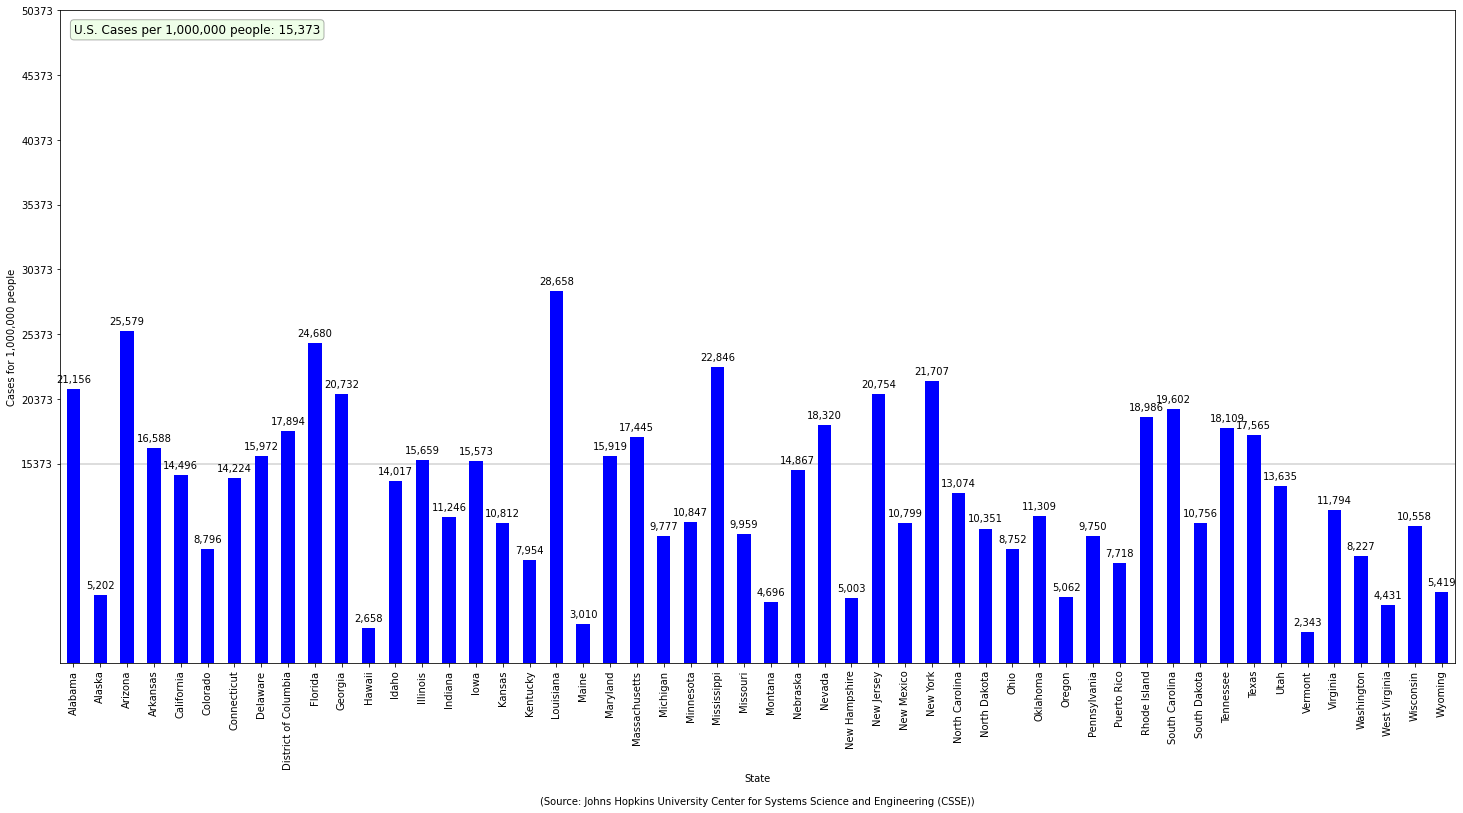

In [82]:
plot_states_per_capita(df, SOURCE, populations, metric=MetricType.CASES, image_file='jhu-state-cases-per-capita.png');

## Counties

### Some select Pennsylvania counties

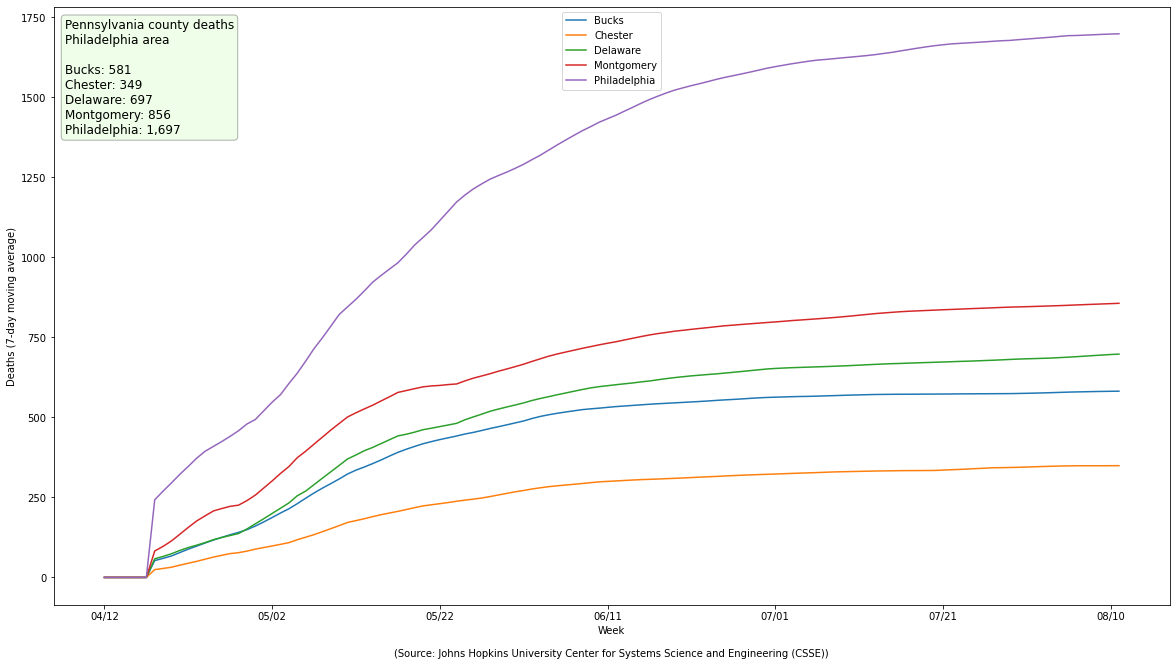

In [83]:
philly_area_counties = ('Montgomery', 'Philadelphia', 'Chester', 'Bucks', 'Delaware')
plot_counties(df_counties, 'Pennsylvania', philly_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Philadelphia area", metric=MetricType.DEATHS, image_file='jhu-pa-phl-area-deaths.png')

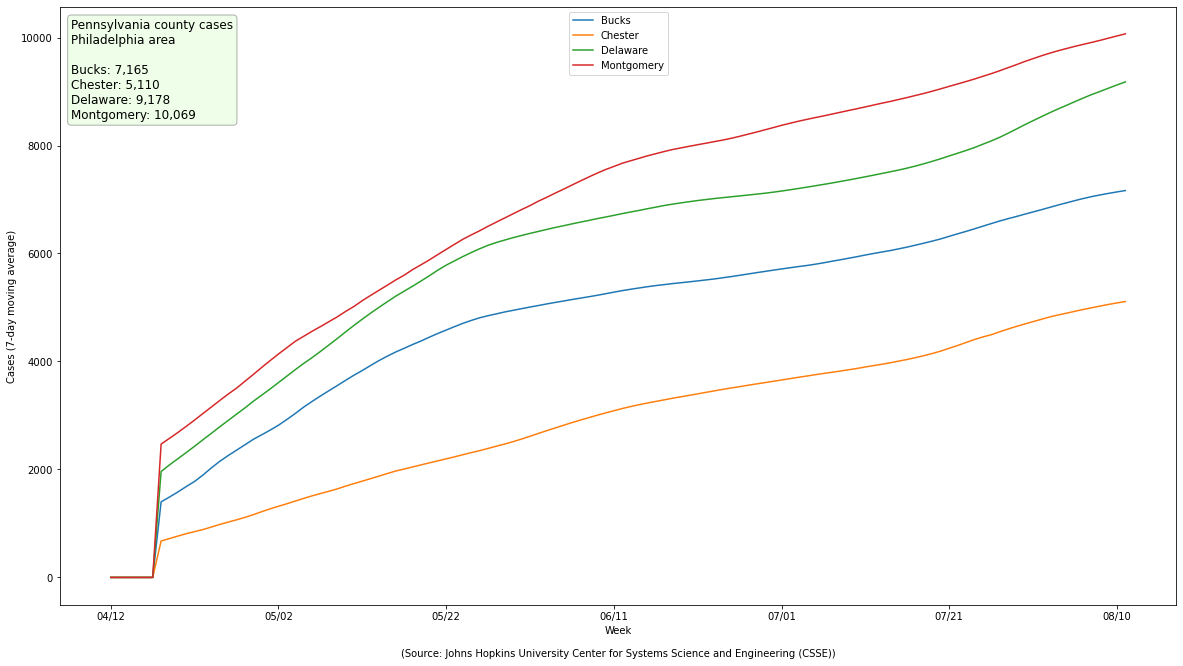

In [84]:
without_philly = set(philly_area_counties) - {'Philadelphia',}
plot_counties(df_counties, 'Pennsylvania', without_philly, source=SOURCE, moving_average=True,
              textbox_heading="Philadelphia area", metric=MetricType.CASES, image_file='jhu-pa-outside-phl-cases.png')

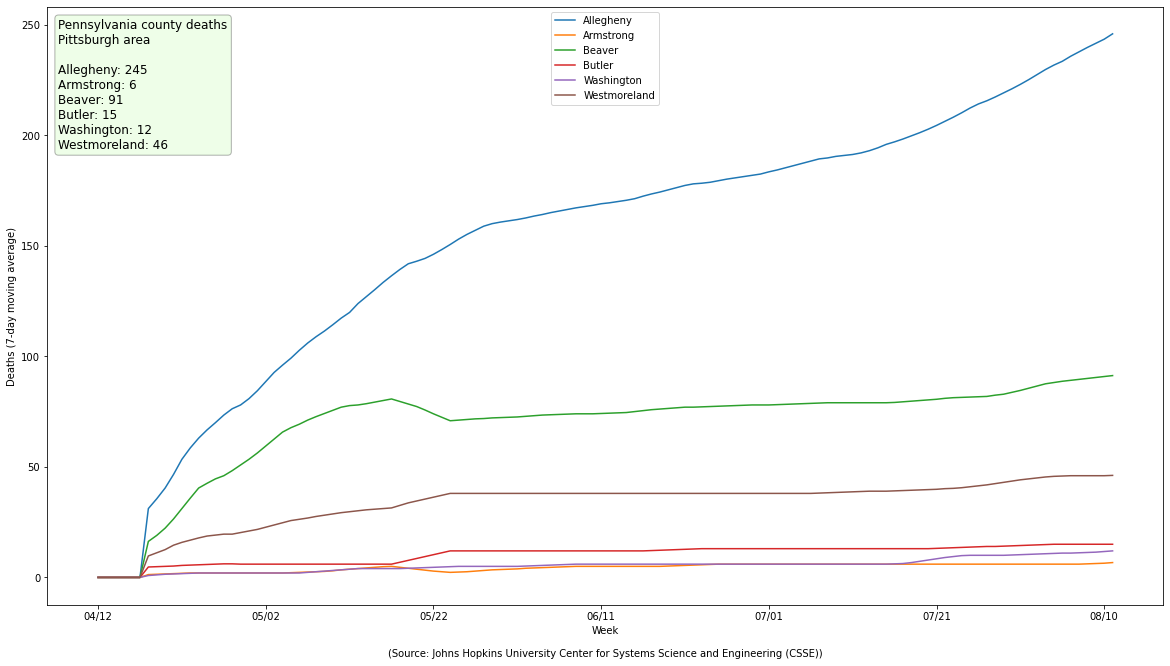

In [85]:
pgh_area_counties = ('Allegheny', 'Butler', 'Beaver',
                     'Washington', 'Westmoreland', 'Armstrong')
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Pittsburgh area", metric=MetricType.DEATHS, image_file='jhu-pgh-area-deaths.png')

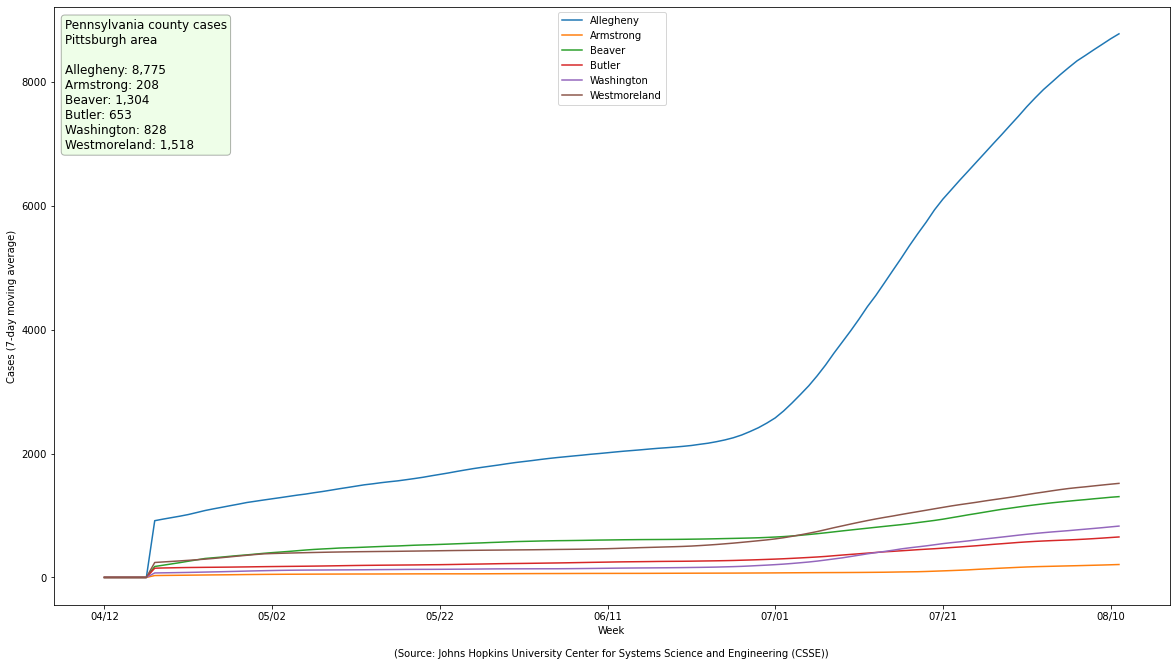

In [86]:
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Pittsburgh area", metric=MetricType.CASES, image_file='jhu-pgh-area-cases.png')

#### Some daily stats for certain counties

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b1826f7c0>)

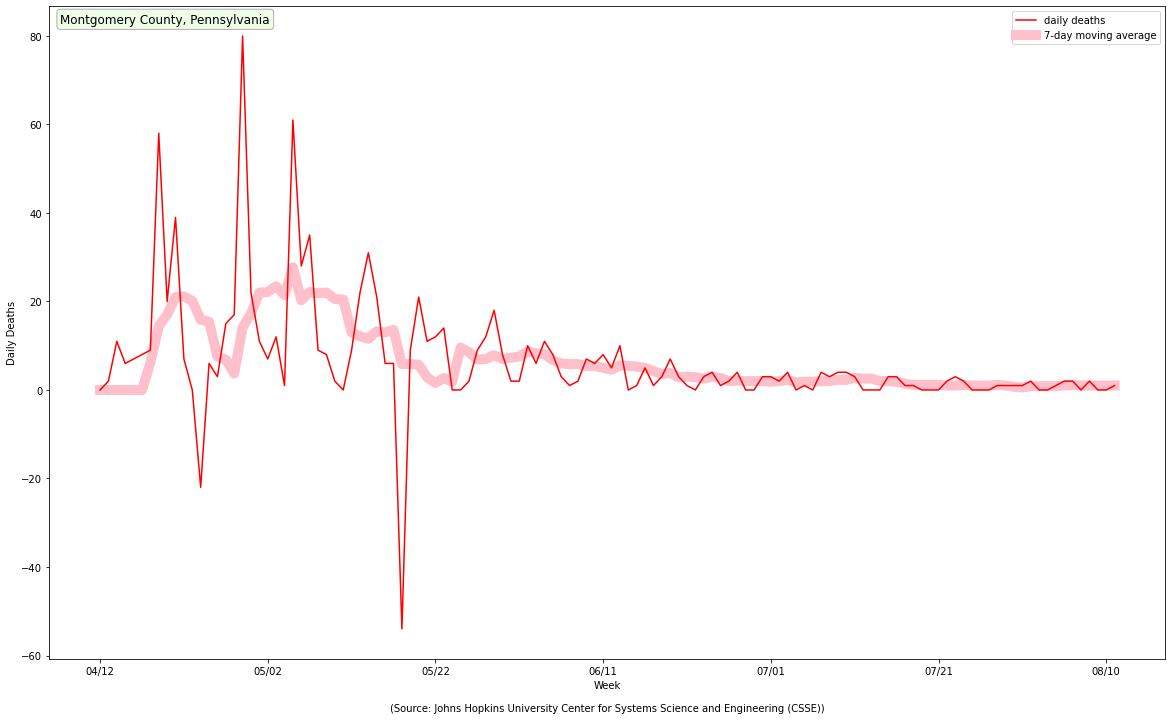

In [87]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Montgomery', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-pa-montgomery-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aed0a4e20>)

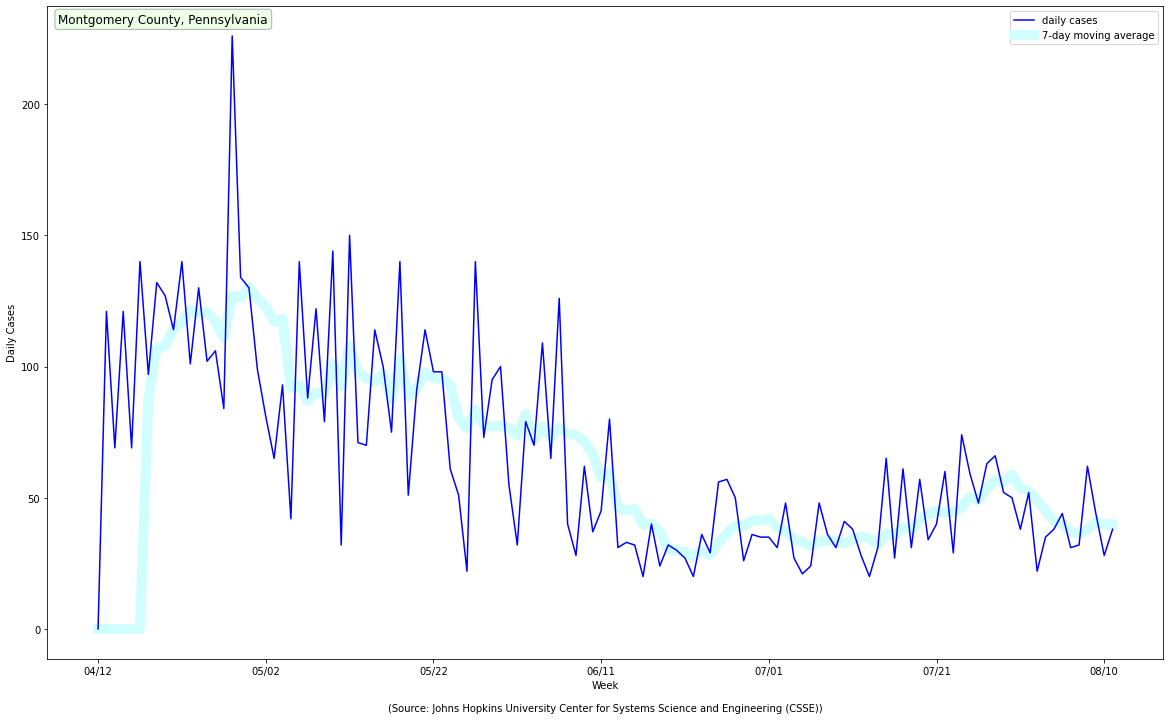

In [88]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Montgomery', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-montgomery-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aedc2f340>)

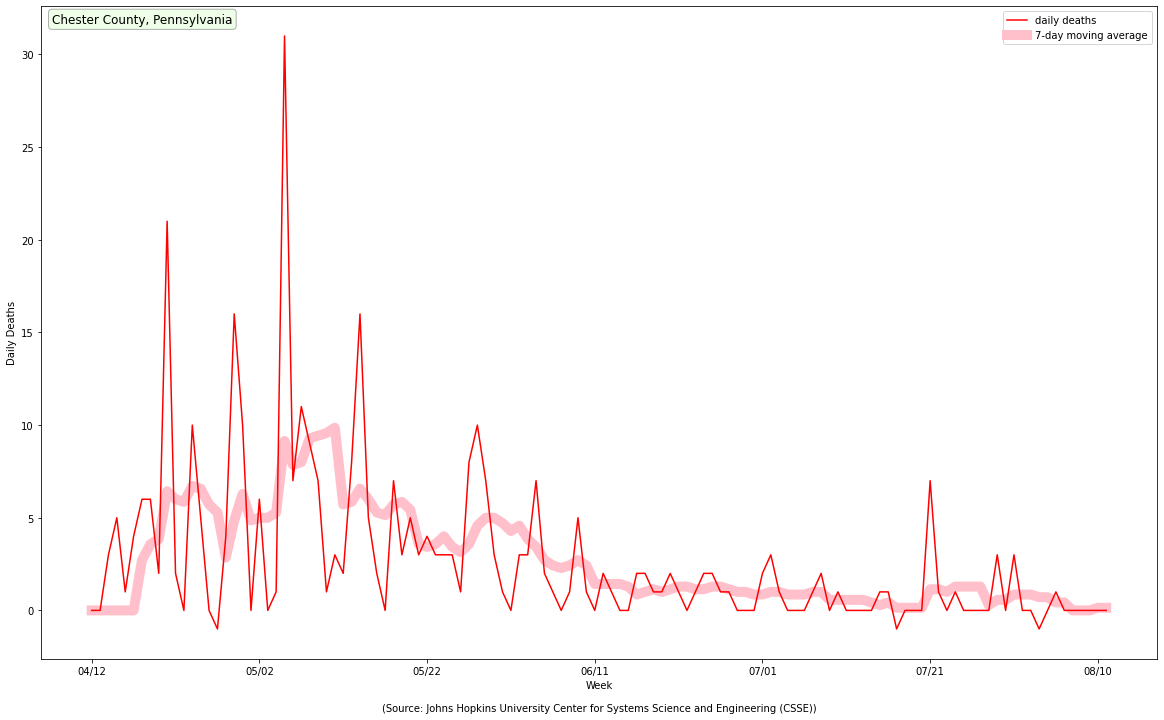

In [89]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Chester', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-pa-chester-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aeeec26d0>)

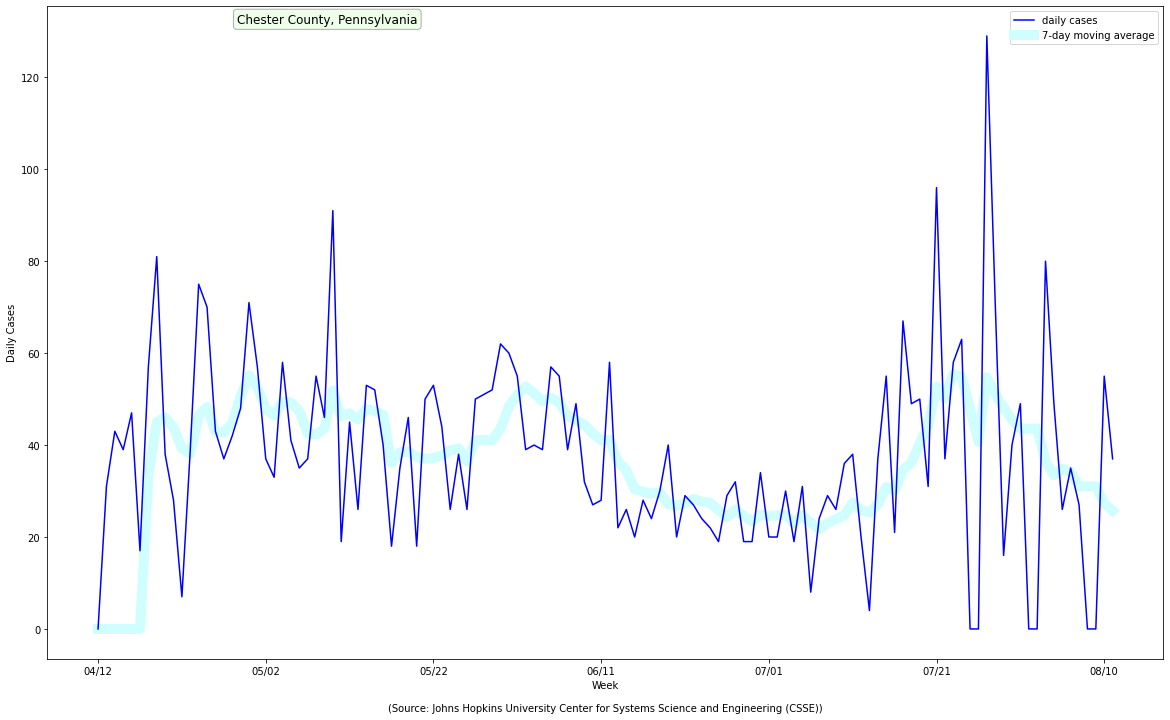

In [90]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Chester', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=(0.17, 0.99), image_file='jhu-pa-chester-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aeeea0610>)

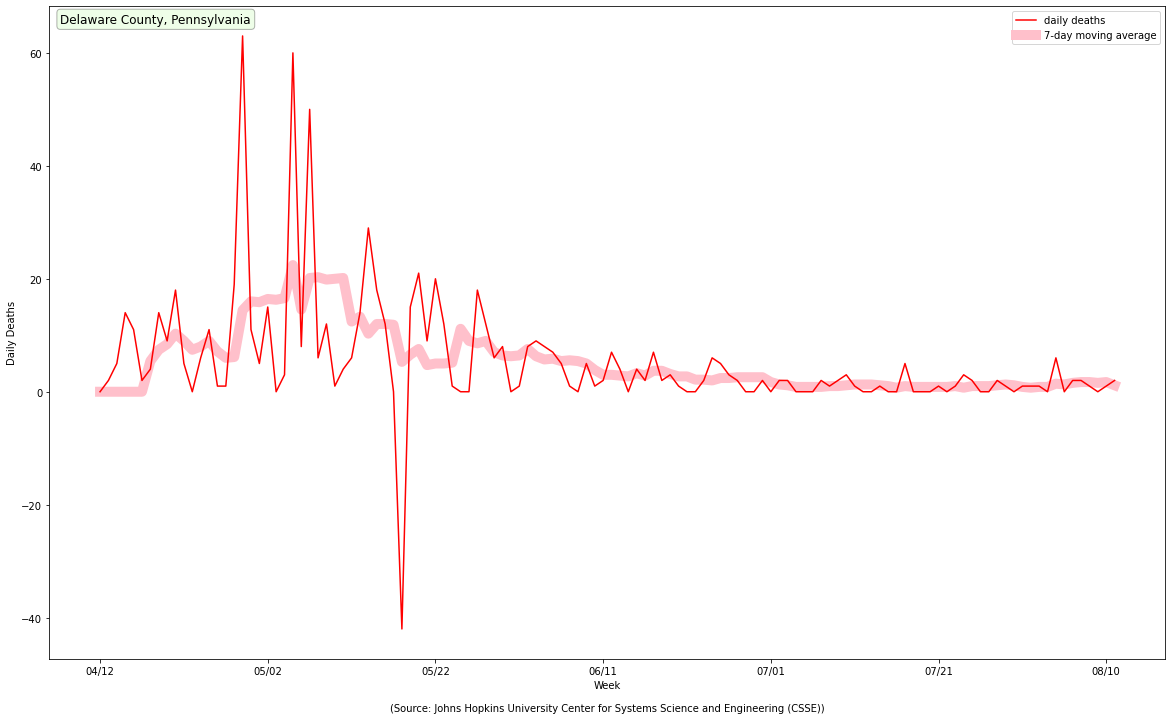

In [91]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Delaware', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-pa-delaware-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aeecb5b50>)

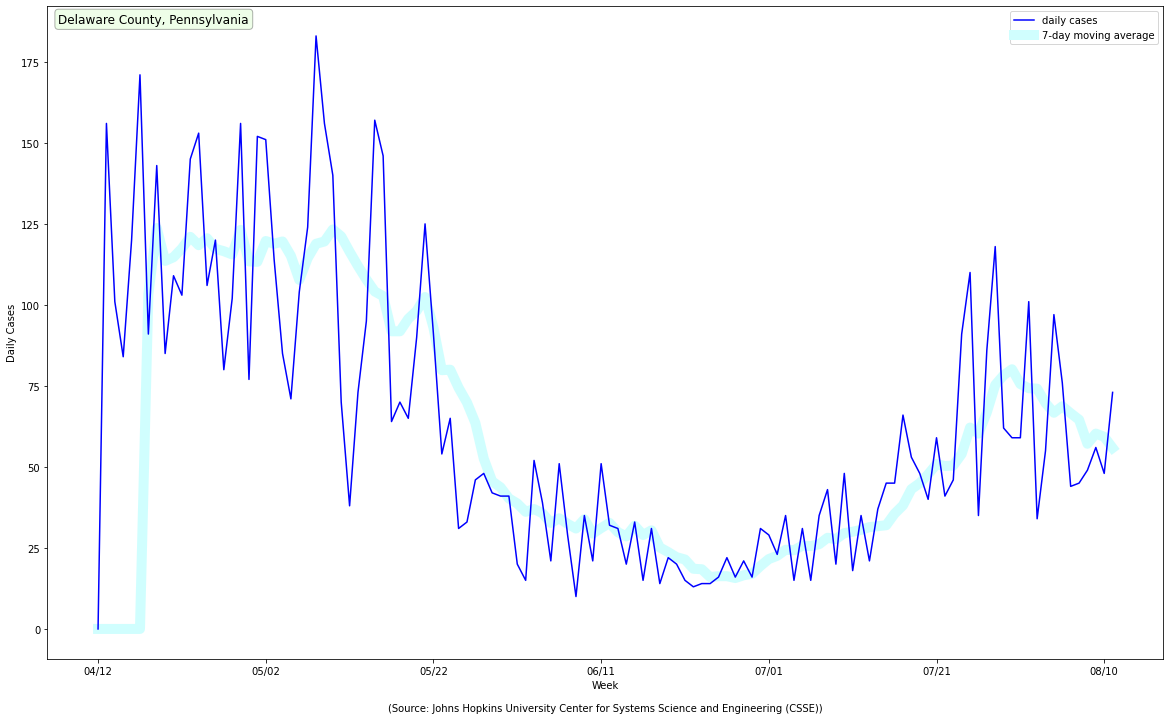

In [92]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Delaware', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-delaware-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee887b80>)

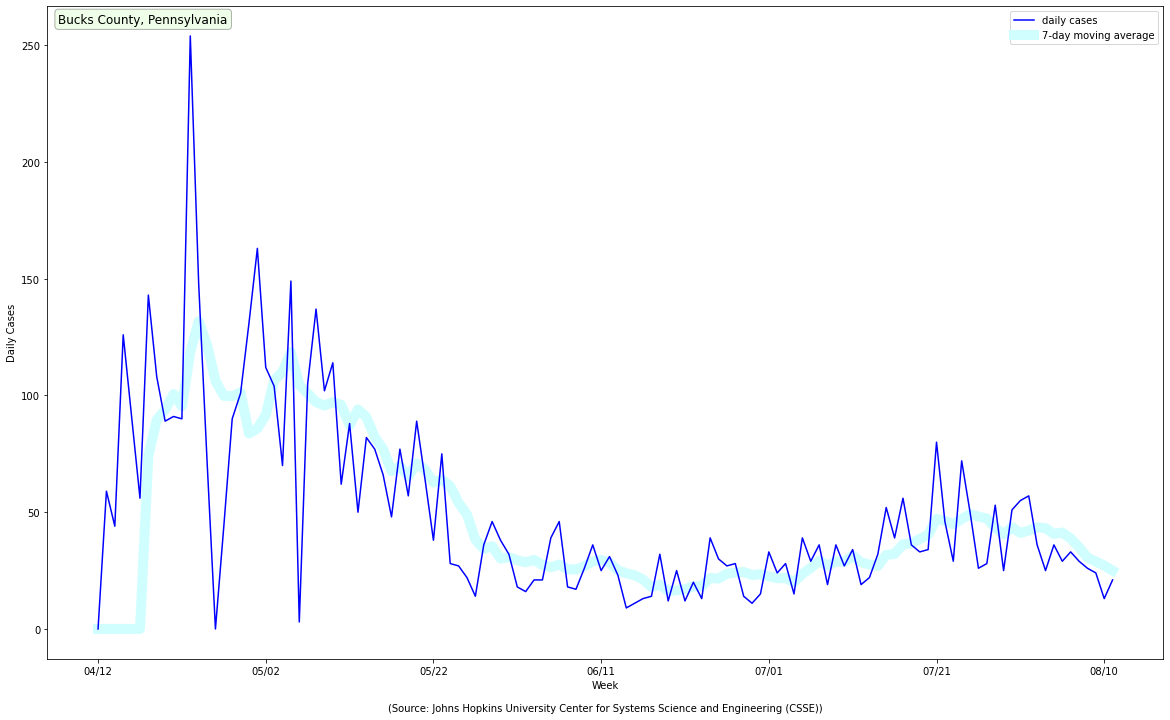

In [93]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Bucks', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-bucks-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aef36bc40>)

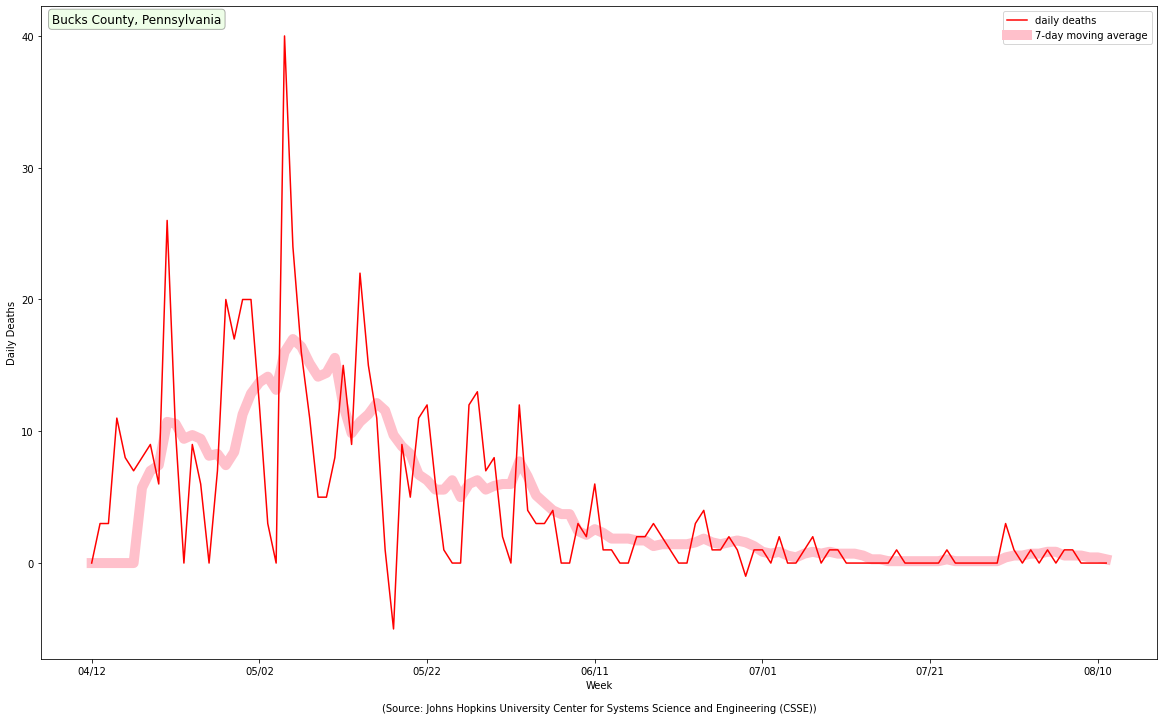

In [94]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Bucks', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-pa-bucks-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aee5a5490>)

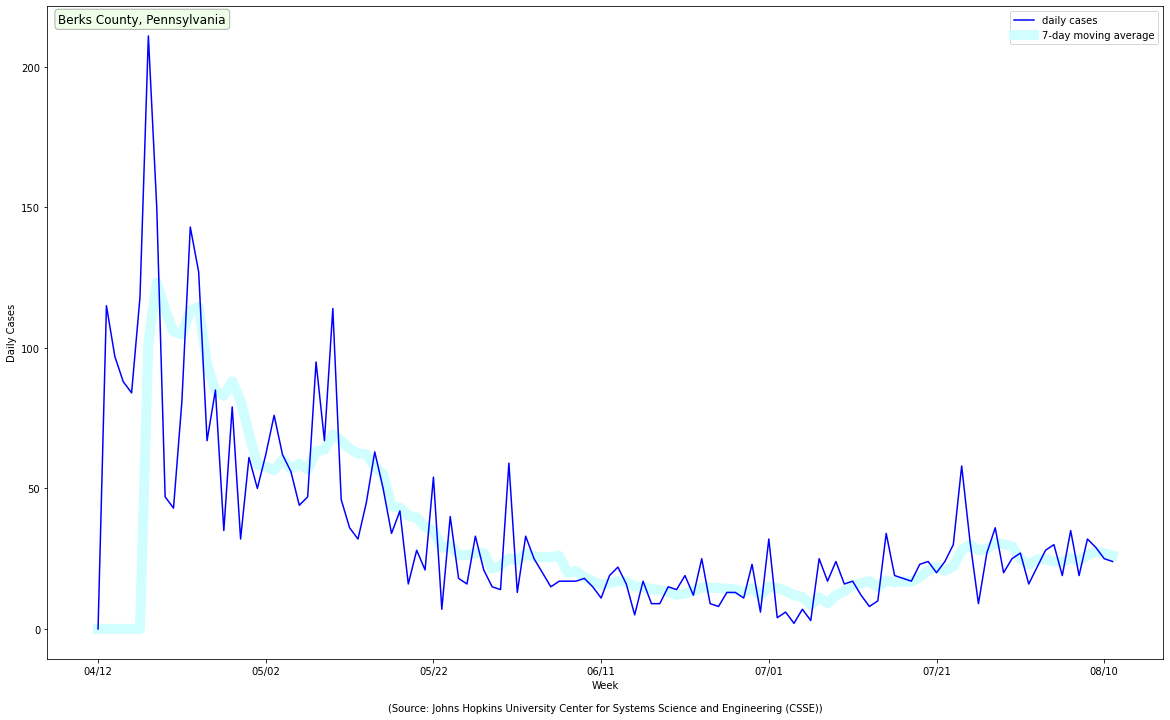

In [95]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Berks', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-berks-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aecc8fa00>)

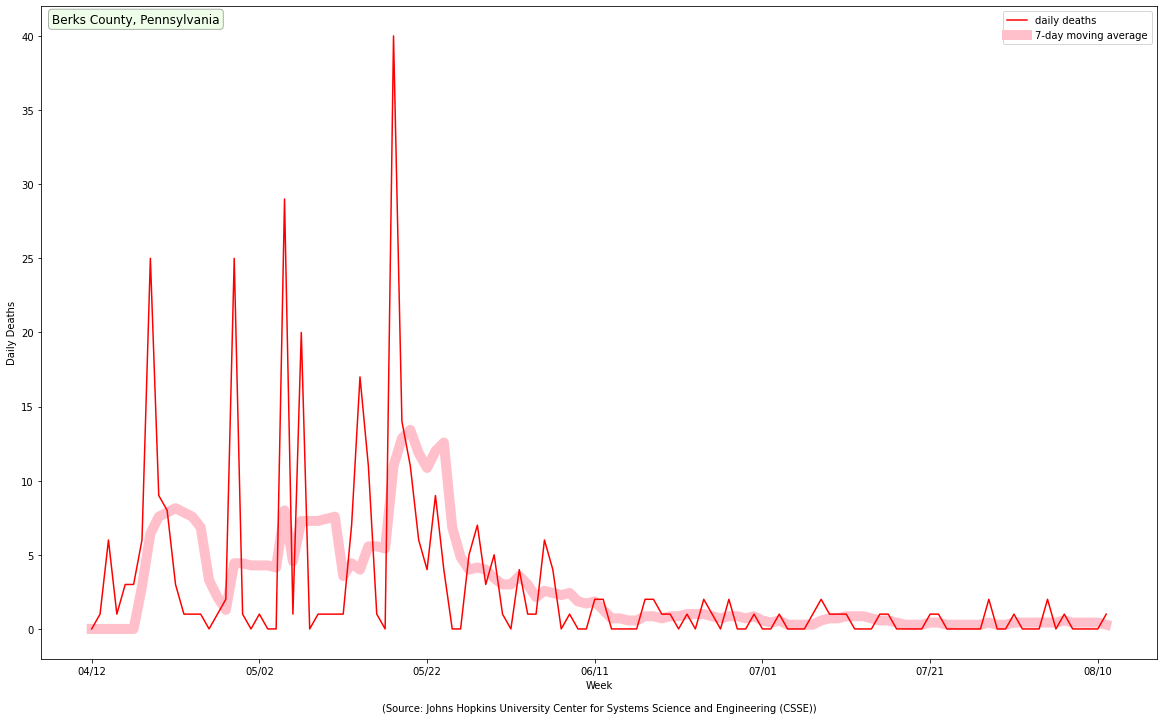

In [96]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Berks', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-pa-berks-county-daily-deaths.png')

### Florida 

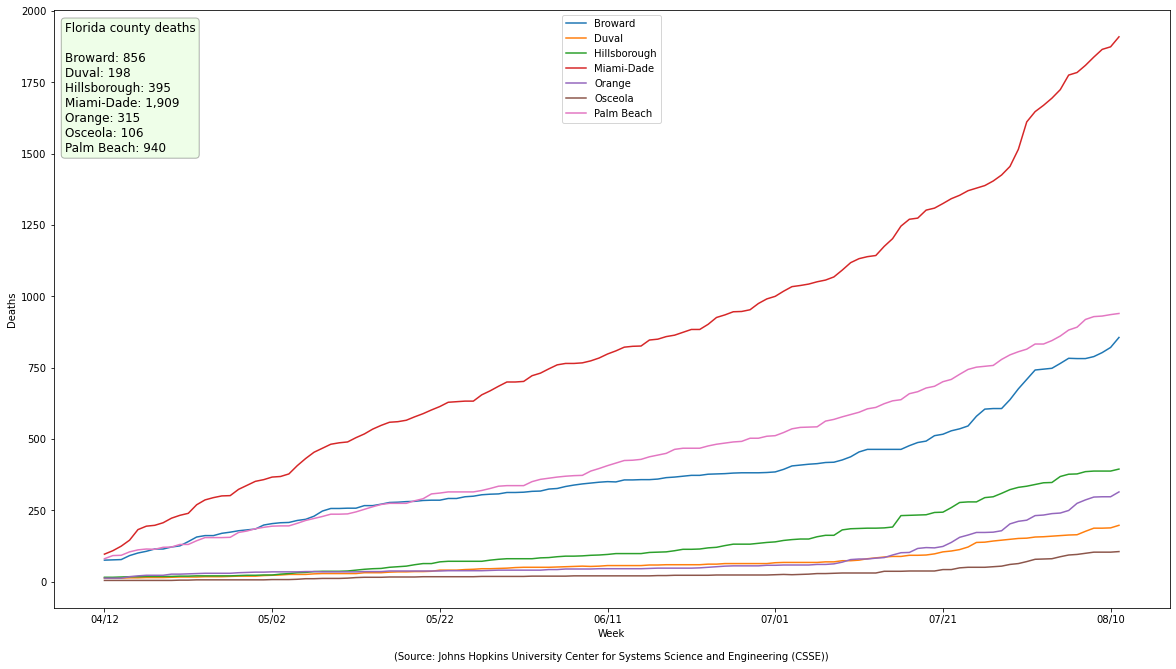

In [97]:
# Osceola and Orange are near Orlando.
# Hillsborough contains Tampa.
# Broward and Palm Beach are near Miami.
# Duval contains Jacksonville.
fl_counties = ('Osceola', 'Orange', 'Miami-Dade', 'Palm Beach',
               'Broward', 'Hillsborough', 'Duval')
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='jhu-fl-county-deaths.png', source=SOURCE, metric=MetricType.DEATHS)

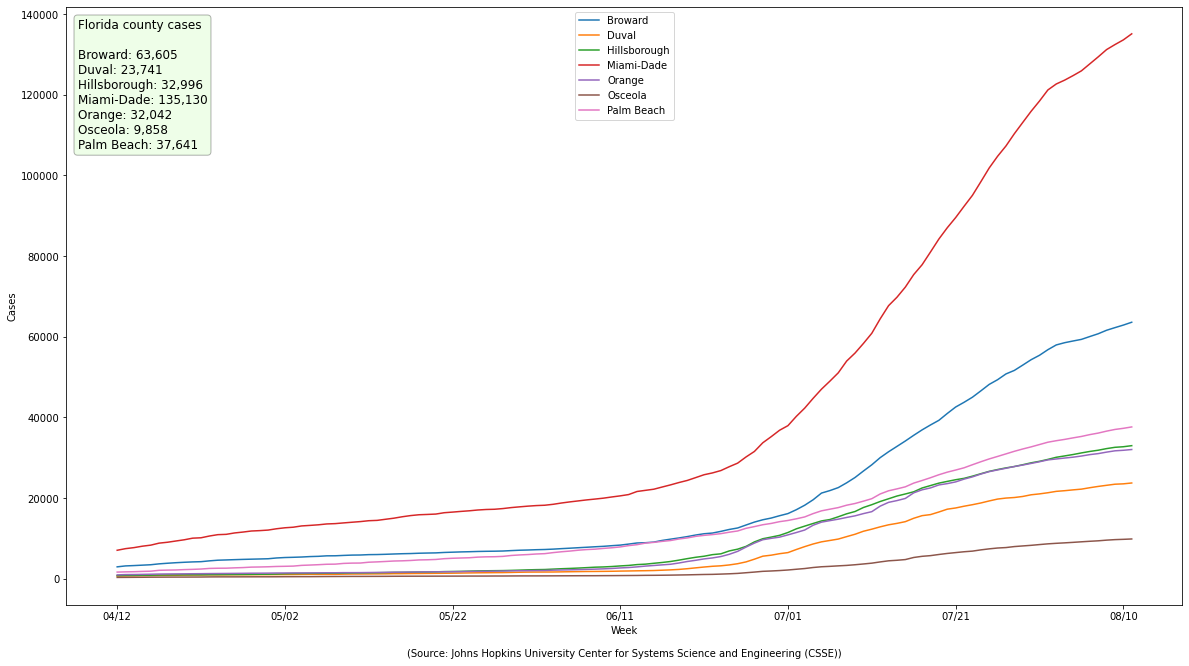

In [98]:
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='nyt-fl-county-cases.png', source=SOURCE, metric=MetricType.CASES)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b185ba310>)

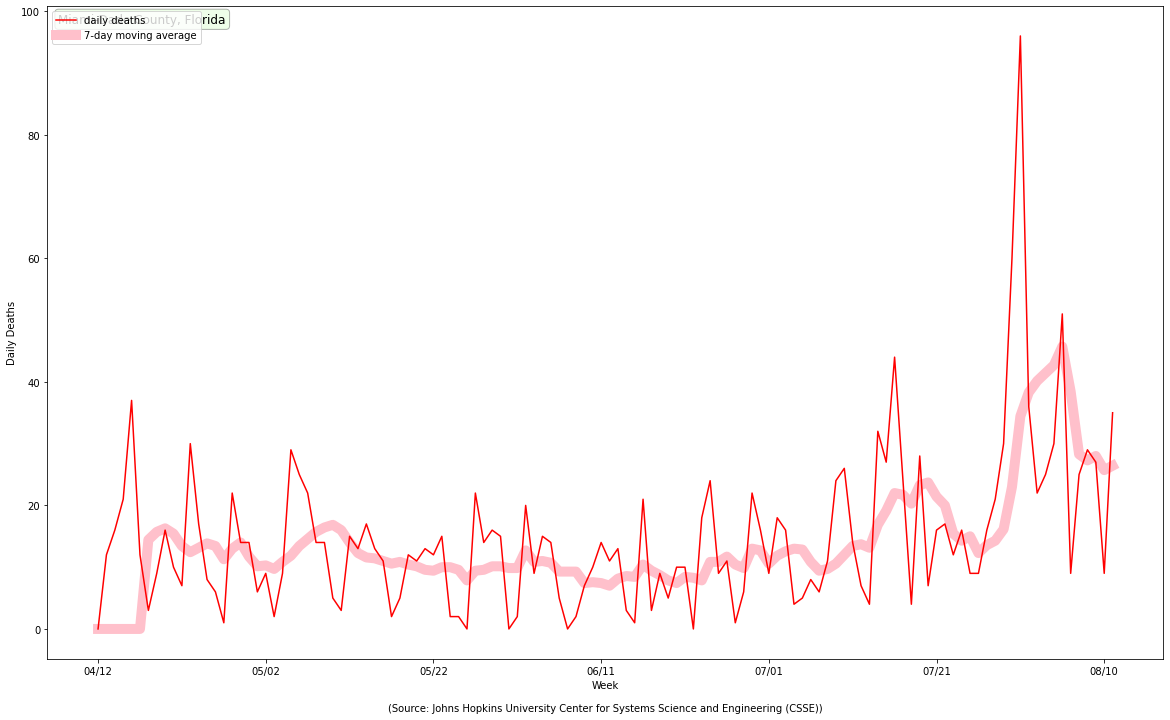

In [99]:
plot_county_daily_stats(df_counties, 'Florida', 'Miami-Dade', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-fl-miami-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6aef2a6f70>)

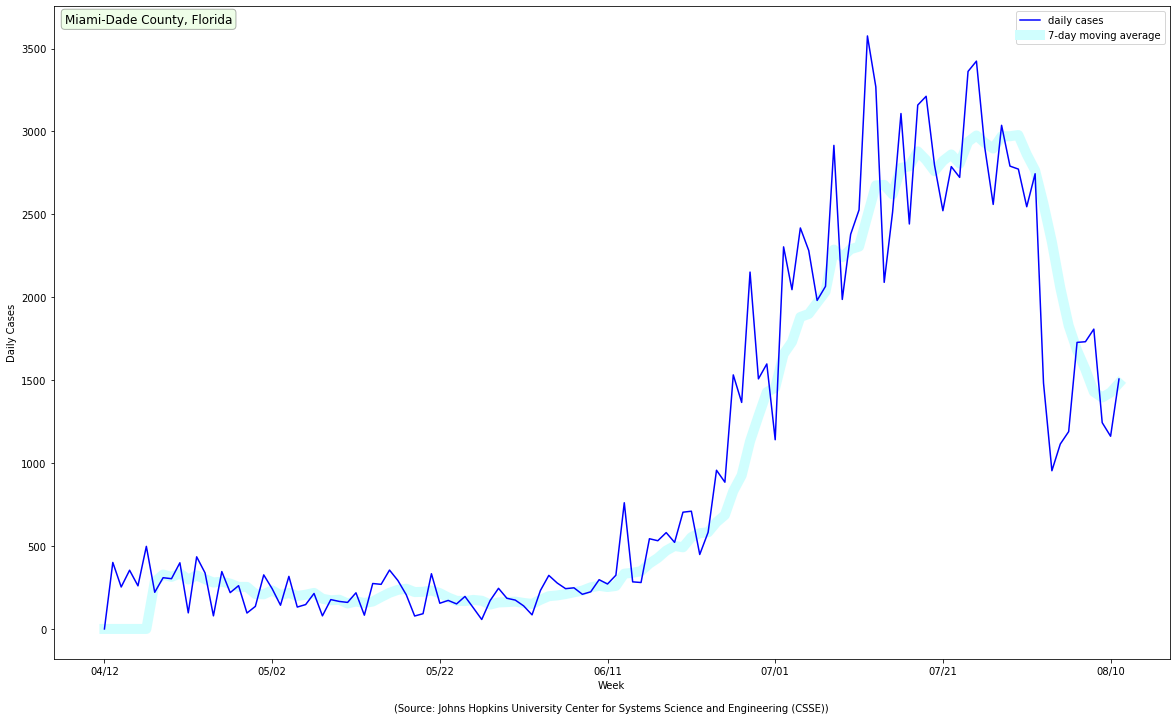

In [100]:
plot_county_daily_stats(df_counties, 'Florida', 'Miami-Dade', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-fl-miami-county-daily-cases.png')

### New York City

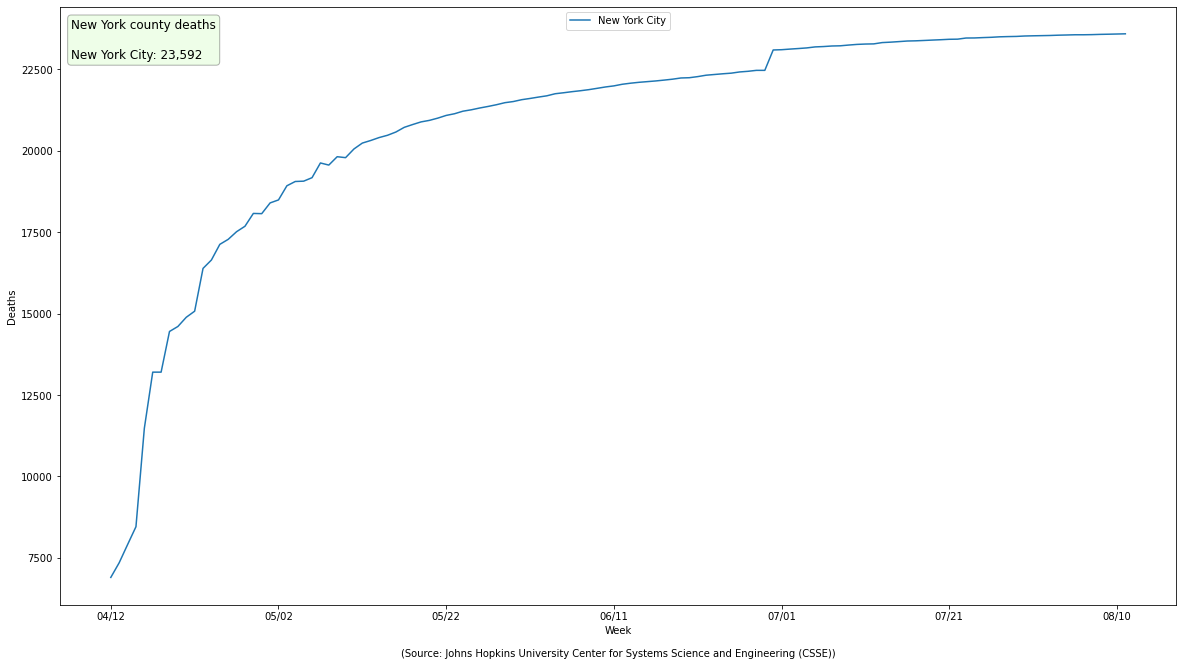

In [101]:
# The NY Times data coalesces the five New York City counties
# into "New York City".
plot_counties(df_counties, 'New York', ['New York City'], source=SOURCE, 
              image_file='jhu-nyc-county-deaths.png', metric=MetricType.DEATHS)